In [77]:
import numpy as np
import random
import pygame as pg

random.randrange(10,50)

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


45

In [384]:
from scipy.spatial import distance
import enum 
import copy 

SENSE_FACTOR = 2

class Block:
    def __init__(self):
        self.content = None
    
    def set_content(self, content):
        self.content = content
        
class State(enum.Enum):
    FIND_FOOD = 0
    GO_BACK = 1

class Organism:
    color = (255, 255, 255)
    food_found = 0
    state = State.FIND_FOOD
    energy = 0
    
    def __init__(self, size, speed, sense, max_w, max_h):
        self.size = size
        self.speed = speed
        self.sense = sense
        
        self.max_w = max_w-1
        self.max_h = max_h-1
        
        a2 = random.random() 
        b2 = 1-a2
        a = np.sqrt(a2) * (2*(0.5>random.random())-1)
        b = np.sqrt(b2) * (2*(0.5>random.random())-1)
        
        self.direction = np.array([a, b])
        
        # Organism starts at a border
        if random.random() > 0.5:
            x = random.uniform(0, max_w-1)
            y = 0
            if random.random() > 0.5:
                y = max_h-1
        else:
            y = random.uniform(0, max_h-1)
            x = 0
            if random.random() > 0.5:
                x = max_w-1
        self.position = np.array([x, y])
        
    def energy_cost(self):
        return ((self.size**3)*self.speed**2)+self.sense
    
    def get_coordinates(self):
        return self.position
    
    def reproduce(self, energy):
        offspring = copy.deepcopy(self)
        mutation_chance = 0.1
        
        offspring.size += (mutation_chance>random.random())*self.size *random.randrange(10,50)*0.01 * (2*(0.5>random.random())-1)
        offspring.speed += (mutation_chance>random.random())*self.speed*random.randrange(10,50)*0.01 * (2*(0.5>random.random())-1)
        offspring.sense += (mutation_chance>random.random())*self.sense*random.randrange(10,50)*0.01 * (2*(0.5>random.random())-1)
        offspring.energy = energy      
        offspring.state = State.FIND_FOOD
        
        return offspring
    
    def attributes(self):
        return np.array([self.size, self.speed, self.sense])
    
    def closest_border(self):
        borders = [[self.position[0], 0], [self.max_w, self.position[1]], [self.position[0], self.max_h],[0, self.position[1]]]
        distances = distance.cdist([self.get_coordinates()], borders, 'euclidean')[0]
        closest_idx = np.argmin(distances)
        
        return distances[closest_idx], borders[closest_idx][0], borders[closest_idx][1]
    
    def walk(self, env):
        distances = []
        step_size = self.speed
        direction = self.direction
        
        if len(env["food"]) > 0:
            distances = distance.cdist([self.get_coordinates()], env["food"], 'euclidean')[0]
            closest_idx = np.argmin(distances)
        
        if self.state == State.GO_BACK:
            dist, x, y = self.closest_border()
            step_size = dist if abs(dist) < step_size else step_size
            
            d = np.array([x, y]) - self.position
            norm = np.linalg.norm(d)
            if norm == 0:
                return
            direction = d/norm   
        elif (len(distances) > 0) and (distances[closest_idx] <= (self.sense * SENSE_FACTOR)):
            step_size = distances[closest_idx] if abs(distances[closest_idx]) < step_size else step_size
            
            d = env["food"][closest_idx] - self.position
            norm = np.linalg.norm(d)
            if norm == 0:
                return
            direction = d/norm           
        else:            
            #x2=cosβx1−sinβy1, y2=sinβx1+cosβy1
            
            r = random.uniform(-np.pi/2, np.pi/2)
            direction = np.array([np.cos(r*direction[0]) - np.sin(r*direction[1]), 
                                  np.sin(r*direction[0]) + np.cos(r*direction[1])])
            print(r, direction, self.direction, np.linalg.norm(direction))
            self.direction = direction
        
        if self.energy >= self.energy_cost():
            self.position += step_size*direction
        
        self.energy -= self.energy_cost()   
    

In [385]:
import numpy as np
import random
import pygame as pg


SCREEN_WIDTH, SCREEN_HEIGHT = 800,600
ENV_WIDTH, ENV_HEIGHT = 50, 40

BACK_COLOR = (100, 100, 100)
BLOCK_COLOR = (200, 200, 200)
MAZE_COLOR = (255, 255, 255)
UNVISITED_COLOR = (200, 200, 200)


BLOCK_SIZE = 10  # Pixel size/Wall thickness

ENV_WIDTH_PX = BLOCK_SIZE * ENV_WIDTH 
ENV_HEIGHT_PX = BLOCK_SIZE * ENV_HEIGHT 
ENV_TOP_LEFT_CORNER = (SCREEN_WIDTH // 2 - ENV_WIDTH_PX // 2, SCREEN_HEIGHT // 2 - ENV_HEIGHT_PX // 2)

MINUTES_PER_DAY = 100
DAY_ENERGY = 40*MINUTES_PER_DAY


pg.init()
screen = pg.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))

def init_organisms(n, attr):
    organisms = []
    for _ in range(n):
        o = Organism(attr[0], attr[1], attr[2], ENV_WIDTH, ENV_HEIGHT)
        o.energy = DAY_ENERGY
        organisms.append(o)
    return organisms


def draw(color, x, y):
    pg.draw.rect(screen, color, (x+1, y+1, BLOCK_SIZE-1, BLOCK_SIZE-1))

def draw_environment(screen, env):
        screen.fill(BACK_COLOR)
        pg.draw.rect(screen, (0,0,0), (ENV_TOP_LEFT_CORNER[0], ENV_TOP_LEFT_CORNER[1],
                                               ENV_WIDTH_PX, ENV_HEIGHT_PX))
        draw_xy, color = np.array([0,0]), None
        for o in env["organisms"]:
            color = o.color
            draw_xy = o.position*BLOCK_SIZE + ENV_TOP_LEFT_CORNER
            draw(color, draw_xy[0], draw_xy[1])
        for xy in env["food"]:
            color = (0,255,0)
            draw_xy = xy*BLOCK_SIZE + ENV_TOP_LEFT_CORNER
            draw(color, draw_xy[0], draw_xy[1])

def kill(env):
    kill_counter = 0
    
    for o in env["organisms"].copy():
        dist_to_border, _, _ = o.closest_border()
        if (o.energy <= 0) or (dist_to_border > 1):
            env["organisms"].remove(o)
            kill_counter += 1
    #print("{} organisms killed".format(kill_counter))
            
            
def sleep_and_reproduce(env):
    babies = []
    for o in env["organisms"]:
        if o.food_found >= 2:
            babies.append(o.reproduce(DAY_ENERGY))
        o.food_found = 0
        o.energy = DAY_ENERGY
        o.state = State.FIND_FOOD
    env["organisms"].extend(babies)
    #print("{} babies born".format(len(babies)))
                
def do_one_step(env, m):
    minutes_left = MINUTES_PER_DAY - m
    
    attributes = np.array([o.attributes() for o in env["organisms"]])
    max_attr = np.max(attributes)
    
    for o in env["organisms"]:
        o.walk(env)
        pos = o.get_coordinates()
        
        for i, food in enumerate(env["food"]):
            if np.linalg.norm(food-pos)<=0.01:
                env["food"].pop(i)
                o.food_found += 1
                dist_to_border, _, _ = o.closest_border()
                if (o.food_found > 1) or (dist_to_border/o.speed >= minutes_left-5):
                    o.state = State.GO_BACK
                break
            
        pos = o.get_coordinates()%np.array([(ENV_WIDTH-1), (ENV_HEIGHT-1)])
        #min(max(x,0),ENV_WIDTH-1)
        #min(max(y,0), ENV_HEIGHT-1)
        o.position = pos
        o.color = o.attributes()*255/max_attr
                
def run_simulation():
    pg.display.update()
    
    env = {"food" : [], "organisms" : []}
    n_food = 10
    for f in range(n_food):
        x, y = random.randrange(1,ENV_WIDTH-1), random.randrange(1,ENV_HEIGHT-1)
        env["food"].append(np.array([x, y]))
        
    organisms = init_organisms(10, (2, 1, 2))
    env["organisms"].extend(organisms)
    # Main game loop
    run = True
    
    time_keeper = {"day":0, "minute":0}
    stats = {"population":[len(organisms)], "attributes":[[o.attributes() for o in organisms]]}
    while run:
        for event in pg.event.get():
            if event.type == pg.QUIT:
                run = False
        
        if len(env["organisms"]) == 0:
            run = False
            continue
        
        # do one simulation step
        do_one_step(env, time_keeper["minute"])
        time_keeper["minute"] += 1
        if time_keeper["minute"] >= 100:#24*60:
            time_keeper["minute"] = 0
            time_keeper["day"] += 1
            kill(env)
            sleep_and_reproduce(env)
            for f in range(n_food):
                x, y = random.randrange(1,ENV_WIDTH-1), random.randrange(1,ENV_HEIGHT-1)
                env["food"].append(np.array([x, y]))
            pg.time.wait(500)
            
            attributes = np.array([o.attributes() for o in env["organisms"]])
            
            stats["population"].append(len(env["organisms"]))
            stats["attributes"].append(attributes)
        
        
        draw_environment(screen, env)
        pg.display.update()
        pg.time.wait(10)
        pg.event.pump()

    pg.quit()
    return stats
    
stats = run_simulation()

-1.3881646016603937 [1.34532454 1.42786759] [-0.7282172   0.68534642] 1.9618114023638278
0.622698478365638 [1.17875904 1.4560415 ] [ 0.85514959 -0.51838131] 1.8733738872861119
0.8230262075266506 [1.60418605 1.10134748] [ 0.44765954 -0.89420408] 1.9458620557670963
0.13822984449659348 [1.08411797 0.89104487] [-0.76049443 -0.64934446] 1.4033077789443498
0.6599446149465389 [0.41010797 0.49998016] [-0.54204548  0.84034915] 0.6466596515218364
-1.1218538507545606 [1.73916357 0.06893154] [0.42380125 0.90575521] 1.740529081598877
-0.0270769502356758 [0.98043501 1.01871288] [-0.69808228 -0.71601755] 1.4138701265994542
0.6299720816998926 [1.34252151 0.47489211] [-0.69595324 -0.7180871 ] 1.4240388044546088
-0.7055340152367243 [0.53932148 1.57926484] [-0.93258922 -0.36093953] 1.6688154767389698
-1.2673484018941807 [ 0.53874792 -0.72093066] [1.60418605 1.10134748] 0.8999946367890577
-0.9734174283289293 [ 1.25559036 -0.22320463] [1.08411797 0.89104487] 1.2752754408852258
-1.0274879395717293 [1.403948

0.3327705244262551 [0.82926112 1.47197845] [1.48164327 0.15523166] 1.6894953556582184
0.9950343085355624 [-0.26432624  1.59941089] [1.11441361 0.79342514] 1.621105662395269
1.193045093924531 [-0.28720839  0.65171925] [0.65310006 1.35937349] 0.7121984512929365
1.4675262033902197 [-1.01504849 -1.46858492] [-1.16379314  1.40994878] 1.7852353045065739
-0.9629894271865317 [ 1.1798744  -0.19964173] [1.13916975 0.8401177 ] 1.1966454864024714
-0.5070219891622831 [0.88999264 1.15012575] [-0.3068098  -0.19346224] 1.4542613777266398
-1.524766832431489 [ 0.57972475 -1.44842438] [1.22386134 1.36732415] 1.5601326805540283
-1.1277037862537576 [1.69298297 0.48645023] [0.1893885  0.70730514] 1.7614837910976398
-1.4782899998192027 [1.31815087 0.94094504] [-0.84353643  1.06737042] 1.6195367478885043
-1.1000918959099846 [ 1.61078055 -0.8393871 ] [0.82926112 1.47197845] 1.8163657925124406
0.3409861251446049 [0.73982054 1.41337645] [1.2937772  0.48443788] 1.5952954009372926
1.5425442005949894 [ 0.29356863 -

-0.07218114695385514 [1.04602676 0.90596887] [1.28699671 0.69768709] 1.3838177498755186
1.4420711611717922 [ 0.08957485 -0.29957169] [0.09262068 1.39960277] 0.3126769104525039
1.5262956808801835 [-0.50998789 -0.11322228] [-1.0591641   0.31627828] 0.5224049549004846
-0.48223043229298956 [1.29033278 0.39088642] [1.11332012 0.92409286] 1.3482399205713804
-0.07986623851130026 [1.091482   1.04176994] [-0.57693447  1.16039005] 1.5088464307706484
0.840306199937658 [-0.0071478   1.05692843] [0.67066916 1.21474086] 1.0569525995616842
1.1618515261116191 [-0.2465519   1.97244993] [1.55412421 0.01191237] 1.9877994287539789
0.8094233304402714 [-0.02078057  1.46291852] [1.03131656 0.94441616] 1.4630661080337877
1.0286335807235933 [-0.32788878  1.47635691] [1.04602676 0.90596887] 1.5123295879094438
-1.4001483672505752 [0.584892   0.78822565] [ 0.08957485 -0.29957169] 0.9815285660309333
-0.35220362773921066 [0.944045  1.1778603] [-0.50998789 -0.11322228] 1.5094952276950115
-0.5785545039935522 [0.95827

-0.7341518870543869 [ 1.65777027 -0.32483488] [1.03300779 1.63372499] 1.6892956991404589
0.9633624862748449 [-0.19086251  0.96273404] [0.73559692 1.30124999] 0.9814710058470285
1.547201966336217 [-0.73694634  1.82843995] [1.1533768  0.35712811] 1.9713656579323788
-1.456366893983977 [-0.64034825 -0.57842331] [ 0.88045853 -0.81074306] 0.8629133243068527
1.151749128276554 [-0.52984578  1.7286346 ] [1.23852552 0.64177586] 1.8080138600702558
-0.6559326383153316 [1.32033495 0.95369839] [-0.00975865  0.49716184] 1.6287495220720376
0.47775008997993895 [0.32787389 1.38368862] [1.16851254 1.14538755] 1.4220040373339176
-0.34681344909508227 [0.81580293 1.17358923] [-0.54397291 -0.48219709] 1.4292816693491388
0.7537640191158248 [0.55814237 1.91902216] [ 1.65777027 -0.32483488] 1.9985417048477778
-0.1261336386092513 [1.12084516 1.01670791] [-0.19086251  0.96273404] 1.5132709062366894
-0.5240591186609718 [1.74450981 0.95165913] [-0.73694634  1.82843995] 1.987201443033018
-1.05363847661709 [0.2084813

-0.390420566202609 [1.01352384 1.57792031] [-1.65199246  0.55346677] 1.8753834447336248
1.2976721969544585 [-0.76989984 -0.83379246] [-1.03953263  1.10090389] 1.134881323673409
0.7159821678137903 [0.0440847  0.43614219] [0.1679367 1.7445734] 0.43836454295378147
-0.7194694595342288 [-0.1584894  -0.06924249] [ 1.73111356 -0.69284974] 0.17295493989051716
1.0743624613809364 [-0.16372033  0.67863275] [0.55222068 1.35053564] 0.6981022541537965
1.1290516800441615 [-0.04072309 -0.0784318 ] [-0.46331242  1.00623843] 0.0883737360534632
-0.9943273628572816 [-0.22190809 -0.03103862] [ 1.55290531 -0.2526731 ] 0.22406828387304745
1.0152474963784055 [-0.48381871  0.8255939 ] [1.01352384 1.57792031] 0.956914746396002
-1.4569643553751208 [-0.50316509  1.24936589] [-0.76989984 -0.83379246] 1.3468816683385285
1.141385008057032 [0.52123523 0.92892862] [0.0440847  0.43614219] 1.0651734813044493
0.2705703615857429 [1.01781455 0.95695511] [-0.1584894  -0.06924249] 1.3970359890376636
-0.5912740009267733 [1.38

1.4947561089183008 [-0.80420859  1.07718368] [0.92215957 0.98679364] 1.344275316724192
1.2438200484276614 [0.01103465 0.30055597] [0.09185751 1.11201522] 0.30075846429405184
-1.3823924394466933 [ 0.34127961 -0.10214576] [1.2171206  0.33991152] 0.35623802239568586
-0.6162435412627681 [0.27133719 0.2098004 ] [ 1.20124689 -0.78839744] 0.34298700051457603
-1.082985122778669 [-1.09560421 -0.10874126] [ 1.89737001 -0.62963359] 1.1009873912858608
0.5190402308296358 [1.02978824 0.89918151] [-0.1933964  -0.06710303] 1.3671105275194255
0.2905152833749496 [1.30099998 1.23999085] [ 1.0575834  -1.22284399] 1.7972696701360096
0.5619041698535061 [0.33063679 0.38568128] [-0.80420859  1.07718368] 0.5080066331822032
-0.43868795724063103 [1.13145687 0.98647959] [0.01103465 0.30055597] 1.5011117996672436
-0.26771560377329906 [0.96848644 0.90838731] [ 0.34127961 -0.10214576] 1.3278303638864117
-0.11859292167830171 [1.02436059 0.96751737] [0.27133719 0.2098004 ] 1.4090438155233176
1.3472078306504374 [ 0.240

1.288484427260049 [-0.5207016   0.69947753] [0.84678639 1.36560405] 0.8720085868319571
-0.707742594351447 [ 1.14235246 -0.20849378] [1.59922896 1.13036181] 1.1612229759986243
0.8771560171194119 [0.55118669 0.69197447] [-0.24446051  0.50158546] 0.8846668474969691
-0.3065939931546011 [1.00201942 0.49647995] [1.68766399 0.43484069] 1.1182733365767004
-0.8472252403385432 [1.95292551 0.40644509] [-0.15683185  1.52649394] 1.9947720804353917
1.2959566231093804 [0.03620194 1.41645299] [0.58779589 0.58484453] 1.4169155418059758
-1.330056696847435 [ 0.06532286 -0.08024111] [1.80937138 0.70619908] 0.10346841020450723
-1.3853393338178026 [1.5752437  1.22651063] [-0.5207016   0.69947753] 1.9964270679208136
-0.030480111886813432 [0.99303901 0.96516781] [ 1.14235246 -0.20849378] 1.3848015656935588
1.2474373881564902 [0.01286685 1.28467483] [0.55118669 0.69197447] 1.2847392679612328
0.187185916614661 [0.88966106 1.18215084] [1.00201942 0.49647995] 1.4795193135660183
1.289220310501161 [-1.31198552  1.4

-0.5060470312202268 [0.99926197 1.00181125] [-0.00357975 -0.00145518] 1.414973593446229
-0.6758655868788145 [1.04352414 0.01209901] [1.49474424 0.7950729 ] 1.0435942815843904
-1.155725334453025 [ 0.67833898 -0.707196  ] [1.61367678 1.14064662] 0.9799336452455808
0.5105272329299222 [0.83907074 1.69766421] [ 1.53618117 -0.25765573] 1.8937010025435619
-0.565776084790107 [1.38133251 0.30790444] [0.99926197 1.00181125] 1.4152330704052456
-0.004331904053684665 [1.00004219 0.99547957] [1.04352414 0.01209901] 1.4110506583145341
0.6017922605141721 [0.13515816 1.37283364] [1.10168898 1.18236319] 1.3794708833274894
0.7469787227543856 [1.37838002 1.34898393] [ 0.67833898 -0.707196  ] 1.9286495599351565
-1.5223805317369004 [-1.03790631 -0.00323282] [ 1.38816171 -0.36045096] 1.0379113414285446
0.5537354657339524 [0.08639881 1.03782809] [0.83907074 1.69766421] 1.0414182148892521
-1.412106876625156 [ 0.05049551 -0.02178463] [1.38133251 0.30790444] 0.054994238742368674
0.4137009538842926 [0.51534453 1.

0.7758738630035054 [0.16765695 1.55715883] [1.02123092 0.72684407] 1.5661585129169089
-1.1600740864979688 [ 1.37987378 -0.54460121] [0.9577494  1.04437327] 1.483456138363132
1.0689852699087043 [-0.52092771  1.50765181] [1.17486431 0.91698606] 1.5951111707989998
-0.16180129484106254 [1.12841692 0.8376951 ] [0.94584105 0.86876249] 1.4053675052426708
-0.08178192024520503 [1.06894278 1.00730954] [-0.11851429  0.84425257] 1.4687788076494868
0.5482134567849277 [0.39063806 1.37044804] [0.94014483 0.91212004] 1.4250354101354215
1.1176646541324224 [-0.00316     0.01751619] [0.16765695 1.55715883] 0.01779895026296181
0.7914035280743104 [0.87845731 1.79611585] [ 1.37987378 -0.54460121] 1.999429771882613
-0.9942602080834431 [1.86626568 0.56682583] [-0.52092771  1.50765181] 1.9504458700210967
-1.4825385695895847 [ 0.8444565  -0.67180551] [1.12841692 0.8376951 ] 1.0790873117631197
-1.5179991915017668 [ 0.94729592 -0.95696651] [1.06894278 1.00730954] 1.3465342377102238
1.2470139868167744 [-0.1067901 

1.436086772870317 [ 0.04210967 -0.18798325] [0.08627547 1.31443066] 0.19264196523474533
-1.3771555191688045 [1.78274376 0.81850797] [-0.45494182  0.97046703] 1.9616652665980892
-0.16853049239811702 [1.05673989 0.96952593] [0.17114611 0.33932726] 1.4341128669061942
1.1294902442353876 [0.12009957 0.28348831] [-0.21794943  0.89909263] 0.30787907604561104
-0.39761588599895004 [0.70232954 1.09418884] [-0.34474145 -0.73548617] 1.3001984425644248
0.5383857361214783 [1.10077783 1.01755219] [ 0.04210967 -0.18798325] 1.499041126228175
1.130906048637348 [-1.22976129  1.50378402] [1.78274376 0.81850797] 1.9425959982506906
-1.0475335854202372 [ 1.29717573 -0.36724666] [1.05673989 0.96952593] 1.3481598498376202
0.5583965260011441 [0.84011352 1.0545098 ] [0.12009957 0.28348831] 1.3482513232887392
-1.3923916991614242 [ 1.55763419 -0.78209646] [0.70232954 1.09418884] 1.7429570082775665
0.9448684128022782 [-0.31388152  1.43477904] [1.10077783 1.01755219] 1.4687111725371167
-1.3578177907535134 [0.7922501

0.1346976042707415 [0.76873016 1.09491247] [0.8954621 1.6772491] 1.3378263559752144
-1.2317155523705983 [ 1.39963849 -0.33150302] [0.8124747 0.8404421] 1.4383609256031744
0.4217326741908307 [0.51866342 1.57610195] [1.56620005 0.6507522 ] 1.6592495607987614
0.4394168112354553 [0.21882111 1.28614036] [1.23369348 1.57400096] 1.3046224395372465
0.9924266546424589 [0.01860772 1.92202365] [ 1.85515993 -0.29188642] 1.9221137249427986
0.2527919742657845 [0.70791299 1.15504696] [0.76873016 1.09491247] 1.354722949916222
0.7637273024916404 [0.73153375 1.84481341] [ 1.39963849 -0.33150302] 1.9845599328899213
-0.0257871292257279 [1.04054251 0.98579974] [0.51866342 1.57610195] 1.4333631255321508
-0.15721830898641231 [1.200238   0.94523027] [0.21882111 1.28614036] 1.5277537457352564
-1.418030210864743 [ 1.40385283 -0.94105346] [0.01860772 1.92202365] 1.6900841381830571
-1.054815067825061 [ 1.67245738 -0.33404864] [0.70791299 1.15504696] 1.705491773931195
-0.9963595500302671 [ 1.71041433 -0.93015701] 

-0.6171729777887477 [1.34110478 1.29952642] [-0.65382631  0.70484706] 1.8674396832647921
1.3192613856017874 [-1.1773875   1.61101865] [1.72047183 0.42697204] 1.9954003128797246
-0.6324588392265715 [0.78357138 0.99306566] [-0.02646331 -0.34470454] 1.2649756986466036
-0.07384719239043402 [1.10160937 1.0220206 ] [-0.36883659  1.38336861] 1.5026873628149588
0.017724745613074244 [0.97723284 1.01840975] [1.0531088  1.27476423] 1.411432764356669
-1.1018386467850816 [ 1.08334578 -0.85718649] [1.34110478 1.29952642] 1.3814509624523716
0.20723119727433836 [0.64269545 0.70320894] [-1.1773875   1.61101865] 0.9526595670357515
0.3510700914561755 [0.62078531 1.21147176] [0.78357138 0.99306566] 1.3612634669061396
0.3833983165076651 [0.53023555 1.33411738] [1.10160937 1.0220206 ] 1.4356249275900228
0.0463064521800578 [0.95183483 1.04412497] [0.97723284 1.01840975] 1.412864639534388
-1.0969400654069803 [-0.43454761 -0.33820011] [ 1.08334578 -0.85718649] 0.5506459310330166
-1.0674562979096613 [1.45586517

0.5614160565857325 [0.84776004 1.74488411] [ 1.55466478 -0.36791302] 1.9399272303046458
-0.7679560049195925 [1.71812441 1.02210584] [-0.73649281  1.38428992] 1.9991627805728067
-0.014041026293212688 [1.0021284  0.99155279] [0.60144968 0.15412373] 1.4097653179297447
0.6747608190034531 [-0.23842756  1.645205  ] [1.66751847 1.086995  ] 1.6623920127714729
-1.1122976792648456 [ 1.51970881 -1.17094857] [0.84776004 1.74488411] 1.9184982170287772
1.0934898423035282 [-1.20219024  1.39074072] [1.71812441 1.02210584] 1.838320185298253
0.8047868635070112 [-0.02392395  1.42001749] [1.0021284  0.99155279] 1.4202190019981689
-0.09658333661151697 [1.15796642 1.01042813] [-0.23842756  1.645205  ] 1.5368315562938637
1.298813814984109 [0.60655222 0.96981116] [ 1.51970881 -1.17094857] 1.1438703081044777
1.4625930543276962 [-1.08100817 -1.42936476] [-1.20219024  1.39074072] 1.7921111308698494
-1.158181964765928 [ 1.99689104 -0.04607049] [-0.02392395  1.42001749] 1.9974224227760276
-0.9998953029883296 [ 1.2

-0.2469785020030537 [1.282717   1.14148052] [-0.76450131  1.23575966] 1.717073288141307
-0.41710695835996514 [1.19863349 0.48517673] [1.1582744  0.76344994] 1.293104293219438
0.9837411999882297 [-0.5973254   1.38570901] [1.282717   1.14148052] 1.5089688845229672
-0.829256860693199 [0.93693129 0.08194831] [1.19863349 0.48517673] 0.9405082491922471
-0.8147946254189182 [1.78789653 0.89521175] [-0.5973254   1.38570901] 1.9994944583568337
-1.1971507677807842 [0.53214567 0.09437438] [0.93693129 0.08194831] 0.5404493868889069
-1.267928105289986 [ 0.2653099  -0.34525662] [1.78789653 0.89521175] 0.4354210316801628
-1.2603824596223145 [0.90204992 0.371394  ] [0.53214567 0.09437438] 0.9755139929055091
-0.3774314478582883 [0.86504833 0.89155253] [ 0.2653099  -0.34525662] 1.242245761229792
-0.28566042730832986 [1.07287747 0.73953966] [0.90204992 0.371394  ] 1.3030675230230349
0.8256988947670805 [0.08412926 1.39612205] [0.86504833 0.89155253] 1.3986545362841234
1.4063542874552541 [-0.80052107  1.504

1.5067436623806851 [-1.38713627  1.18979831] [1.33682439 0.84964669] 1.8275029557655786
-1.080346990903659 [1.43750302 1.17199449] [-0.27814959  0.46586344] 1.854719928660227
1.5487783865471072 [-0.08908082  0.0405566 ] [0.76997471 1.72096846] 0.09787864596836789
0.646045309596667 [0.47550764 0.90600947] [0.08317183 0.8519906 ] 1.0232109580153808
1.4998854771348036 [0.95619039 0.83435313] [-0.11064536  0.02005162] 1.2690331753914879
1.2043560623866365 [-1.09015698 -0.85760386] [-1.38713627  1.18979831] 1.3870568195374784
-0.8674341025611098 [ 1.16856398 -0.42177873] [1.43750302 1.17199449] 1.2423522323810512
0.36414109026446506 [0.98470615 0.96745865] [-0.08908082  0.0405566 ] 1.380442843230181
1.038457199601781 [0.07248046 1.06307008] [0.47550764 0.90600947] 1.0655380881556726
1.1976117339075585 [-0.42814106  1.45171907] [0.95619039 0.83435313] 1.5135365917283143
0.31032320177497863 [1.01587172 1.28921564] [ 0.95138295 -0.1906812 ] 1.6413629455581886
0.12370941302691363 [1.09681456 0.

1.0627107602606927 [ 0.08449378 -0.72965916] [-0.2453951  1.9404634] 0.7345350119984503
-0.10336989276685649 [0.87053648 0.82345278] [ 1.65183842 -1.11420778] 1.1982938863252064
-0.9477698838208841 [ 1.89541181 -0.17270216] [0.42537477 1.42373055] 1.903263506690469
-0.6246282434765705 [0.55845761 0.84517156] [ 0.08449378 -0.72965916] 1.013010296935773
-1.26052715172519 [ 1.31735193 -0.38203797] [0.87053648 0.82345278] 1.37163009705603
0.7500558792467449 [0.2777537  1.98052239] [ 1.89541181 -0.17270216] 1.9999040070235663
0.7801725437715819 [0.29395101 1.21241146] [0.55845761 0.84517156] 1.247537066849622
1.498723563284602 [0.14910768 1.76018445] [ 1.31735193 -0.38203797] 1.7664887207797955
-1.5249994752070544 [ 1.03262551 -1.40367397] [0.2777537  1.98052239] 1.7425888948791426
-0.6030422252230186 [1.65204488 0.56807886] [0.29395101 1.21241146] 1.7469876618500761
-0.12011341048473545 [1.20968983 0.95982467] [0.14910768 1.76018445] 1.5442191874613238
0.7894941044150161 [1.58057858 1.1741

-0.19262193801139804 [1.31624041 0.89733179] [0.26443504 1.67754158] 1.5930138600101211
-0.08873052700493411 [1.07272434 0.88030656] [1.31624041 0.89733179] 1.3876876999585124
-0.4695467122416943 [1.2774804  0.43311811] [1.07272434 0.88030656] 1.3489060278065352
-1.056025935789159 [ 0.66153363 -0.07830458] [1.2774804  0.43311811] 0.6661518982465654
-0.2939405726330313 [0.95813893 0.80650665] [ 0.66153363 -0.07830458] 1.2523909851262178
1.357908217968228 [-0.62252969  1.4217449 ] [0.95813893 0.80650665] 1.552063717779436
-1.3721127662719623 [1.58550171 0.38311456] [-0.62252969  1.4217449 ] 1.631132254648066
-0.13896334221716722 [1.02903985 0.78003479] [1.58550171 0.38311456] 1.2912696439854507
-1.51229493700366 [ 0.93905388 -0.61863845] [1.02903985 0.78003479] 1.124515776652294
-1.1864854337125148 [-0.22892985 -0.15504951] [ 0.93905388 -0.61863845] 0.27649453672495594
1.0532700444016783 [1.13365402 0.7478995 ] [-0.22892985 -0.15504951] 1.3581329501054706
1.1995646866528187 [ 0.01784495 

-0.019947977749688484 [1.00630793 0.98477809] [0.76207552 0.3220134 ] 1.4079927296341692
-0.9799723359578424 [ 0.40326974 -0.00227476] [1.40147527 0.2129354 ] 0.4032761593128558
0.22890711568373212 [1.02782276 1.20077829] [ 0.88835224 -0.21164131] 1.5805973961569098
-0.9185198510427224 [-0.17123517 -0.12452631] [ 1.14106862 -0.80001161] 0.21172691363048085
1.3450552188463645 [-1.21471862  1.30200055] [1.37451579 0.9095977 ] 1.780659082360086
-0.8874466695215842 [0.99426068 0.67427933] [0.37245616 0.05455059] 1.2013354757338846
1.5160303270396347 [-0.11599508 -1.79461107] [-0.77995315  1.73092717] 1.7983558431988325
0.03648742238226066 [0.96260666 1.03135634] [0.878169   1.01098954] 1.4107825770456517
-0.7690248007089135 [1.58673493 0.43772226] [0.43555403 0.90700172] 1.6460038045587009
0.4023567126961274 [1.0489126  0.79738136] [-0.50101463 -0.17203073] 1.3175866801466967
-0.7211110635405348 [ 1.18893611 -0.04982653] [1.35267274 0.94179255] 1.1899797307508797
1.1378324186791144 [0.6815

-1.1973084958836464 [0.98207544 1.02108228] [-0.01774022 -0.01478308] 1.4167149307112066
-1.3009482239479888 [ 1.98534956 -0.21331554] [0.03862623 1.33334592] 1.9967765027666389
0.8918776079297301 [-0.09671808 -0.39577803] [-0.49875151  1.72250911] 0.40742439143945214
-1.4521136855367534 [ 0.81022607 -0.35171371] [1.0487627  0.59703907] 0.8832716508449918
-0.6623403456141158 [0.23282991 0.12768203] [ 1.41320768 -0.55627534] 0.2655418414369792
0.6850371079211679 [0.16222312 0.56659401] [0.02958623 1.44929786] 0.5893599142887721
0.5478656234767803 [0.77764653 1.24462955] [0.48449611 0.3439608 ] 1.4675955963030225
-0.7176832749415777 [0.02522357 0.0180021 ] [ 1.30341454 -0.84210894] 0.030988770725290927
1.2103737680111988 [0.5001308  0.79448377] [-0.06049668  0.42991396] 0.9387945871780484
1.3487491156318732 [-0.96756672  0.49908273] [1.23832779 1.54940679] 1.088700573993056
-1.5496742345527736 [ 1.04881315 -1.01035298] [0.98207544 1.02108228] 1.456304288226438
-0.05579147065706347 [0.981

0.598770353127184 [0.29706867 1.02738394] [0.47216899 1.21102869] 1.069470691462025
-0.8626630204730723 [ 0.23139667 -0.00482096] [1.7105685  0.15859549] 0.23144688111384576
-1.4631588735496295 [ 1.08161591 -0.88631816] [1.01357272 0.99834853] 1.3983750774136154
-0.20647711130384194 [1.20738919 0.72076196] [1.22481437 1.16981061] 1.4061601808016542
0.16529621108109582 [0.88708359 1.21908764] [1.36019059 0.53153337] 1.5076776750026677
1.1614167587943123 [-0.00916932  0.18313721] [0.12212539 1.31650445] 0.1833666067569144
-0.2513625382416196 [0.82792461 0.69697215] [ 1.19070949 -0.50909558] 1.0822334918535785
0.4298463739439877 [1.16174876 1.57705914] [ 1.70406447 -1.00384874] 1.958768927300403
-0.8961683598226907 [ 1.40317522 -0.15799802] [1.0032269  0.99980347] 1.4120425196369375
0.49463408968131306 [0.50263641 1.02004406] [0.29706867 1.02738394] 1.1371601674563796
-0.35822087005955283 [0.99483953 0.91720228] [ 0.23139667 -0.00482096] 1.3531318200759115
-1.3825629519204992 [-0.86561534

0.03621872217240529 [1.02232126 0.98222281] [-0.48387953 -0.62058289] 1.4177102672828827
-0.6963685418340755 [0.72188419 0.21369245] [1.2881983  0.14091957] 0.7528487528283133
1.1209801200377432 [-1.20592806  1.29938555] [1.63925677 1.09675947] 1.7727564102995415
0.11778930404331467 [0.76895894 0.98090138] [0.06749307 1.97908526] 1.2463809116330076
-0.04264763822974804 [0.98963944 0.93978092] [ 1.41201106 -0.20043428] 1.3647616641702547
0.42862971280345064 [0.55403814 1.06382398] [0.38030372 1.04400436] 1.1994497626659046
0.255501207925674 [0.72993529 1.23417541] [1.03835223 0.92876023] 1.4338739352979277
-0.5320601759174675 [0.93608748 0.48552674] [1.00919256 0.14451564] 1.0545122053045906
1.1429939816852146 [-0.50973668  1.35344043] [1.02232126 0.98222281] 1.4462477271283276
0.5780041041381812 [0.79100471 1.39763147] [0.72188419 0.21369245] 1.6059458851343311
-1.191173754193016 [1.13365834 1.01399209] [-1.20592806  1.29938555] 1.5209737646809014
0.5686412839418429 [0.37660973 1.27189

1.1504590434435489 [0.72194876 1.69196399] [ 6.64261795e-01 -1.45607986e-05] 1.8395521673145232
0.49022360803340836 [1.52055183 0.89089124] [ 0.07649356 -1.11851137] 1.762318093346831
0.783722157245661 [0.05715343 0.92522572] [0.53621168 1.31062685] 0.9269892891180083
-0.687355860777511 [0.75623605 1.21787241] [-0.3542501  -0.31415939] 1.433564153787177
0.15629538084116912 [0.84108324 1.18352867] [1.2451354  0.89895138] 1.4519508028903474
-0.7477467065923017 [1.17985761 0.99945527] [-0.02111151  0.24201827] 1.5462777318937506
0.9477226544284716 [-0.61814686  1.65583761] [1.52055183 0.89089124] 1.7674568533239867
0.30477911160038396 [0.7215812  0.97792203] [0.05715343 0.92522572] 1.2153233772759895
0.43206885694693353 [0.44483662 1.18568242] [0.75623605 1.21787241] 1.2663816276197348
-1.2408377182002852 [ 1.49785014 -0.76219374] [0.84108324 1.18352867] 1.6806232036238653
0.5317565873461159 [0.30275981 1.44910408] [1.17985761 0.99945527] 1.4803939101337724
-0.8502797611296521 [1.85178997

-1.0122726529070742 [1.03471657 0.25724366] [0.755582   0.31473367] 1.066214177321863
-1.0636929860350923 [0.02285016 1.6501767 ] [-0.89936886 -0.55133535] 1.6503348997427307
-0.13989879666210925 [0.91878391 0.77505444] [ 1.61030665 -0.4001244 ] 1.2020288137614628
-1.4834639864940182 [ 1.33904087 -1.10244641] [0.81563089 1.17186878] 1.734479332153722
0.8227486166197155 [0.44892688 1.72983169] [1.03471657 0.25724366] 1.7871354249556732
1.073223644188729 [ 0.01967495 -0.17435654] [0.02285016 1.6501767 ] 0.17546312293975194
-0.32661999285857646 [1.20576208 0.67251949] [0.91878391 0.77505444] 1.3806319728909942
-0.7087697599416709 [-0.12182234 -0.10293331] [ 1.33904087 -1.10244641] 0.1594865167107298
-1.1843438598465594 [ 1.7499085  -0.96691795] [0.44892688 1.72983169] 1.9992773859990909
0.9093022061790235 [1.15771941 1.00534791] [ 0.01967495 -0.17435654] 1.5333097063113343
-0.380204699539231 [1.1496635  0.52494123] [1.20576208 0.67251949] 1.2638391708362606
-1.0773312607910213 [0.88073386

-1.0274115804121395 [1.24841939 0.53938498] [0.40415301 0.33083512] 1.359958506834586
-1.374476700874127 [ 0.14039363 -0.06929682] [1.41940565 0.39059844] 0.15656443220736596
1.4645035000574245 [-0.88661814  1.12290926] [1.00068296 0.98462931] 1.430739991856975
0.1895178529654009 [0.80481242 1.16183726] [0.94440209 0.95076333] 1.4133608396686805
-0.8898955322299981 [1.33485272 0.15735169] [0.80513727 0.69629788] 1.3440949920463772
0.4992092819739331 [0.4393268  1.33065407] [0.91628748 0.95269877] 1.4013023548816976
-0.04591978937424024 [1.03454745 0.95492749] [0.96811343 0.7740218 ] 1.4078973479156718
0.6735133045873942 [0.95776024 1.05332991] [0.08045565 0.06055301] 1.4236602739785487
-1.4595592818373337 [-0.01343981  0.00838407] [1.46377711 0.37671131] 0.015840484724970683
-1.4630841226824236 [ 1.45464505 -0.88913739] [0.75103087 1.072571  ] 1.7048629056199003
-0.8360039011565922 [ 1.69234828 -0.56511089] [0.94628366 1.70365053] 1.7842065537003637
-0.6208322498671462 [1.38264744 0.16

-0.7399493609123069 [1.67450527 0.94726445] [-0.3216667   1.05302108] 1.9238705331602206
0.22794897379611756 [0.86345884 1.20117563] [0.91819789 0.50436901] 1.4793187812542883
0.3684803147742537 [1.00907211 0.98841296] [-0.03133284 -0.02480156] 1.412510782089916
1.5256086479181015 [-0.09636585 -1.10731064] [-0.44314813  1.35896614] 1.1114959418951225
0.6772472693905098 [1.15177643 0.96570582] [-0.03347592 -0.22536123] 1.5030557783954905
-0.595441142673577 [0.98329901 0.99545597] [ 0.00739743 -0.02803311] 1.3992174690892913
0.6675546944653967 [0.2365842  1.59268534] [1.18094493 0.73030601] 1.6101610695103596
0.19345309228636554 [0.79085597 1.17602992] [1.01061708 0.98864904] 1.4172154195085764
-1.1895340258353768 [ 1.47843703 -0.61455786] [0.87139272 1.1114828 ] 1.6010800776941545
0.9460291640443796 [-0.76898422  1.79974277] [1.86802106 0.64605317] 1.9571435188763897
0.5694197460281036 [0.83588169 1.11651056] [0.2266868  0.27472937] 1.3947379840368708
-0.9719300889299535 [-0.69351502 -0

-1.2181519388252176 [ 1.20692384 -0.79713951] [1.10500802 1.14282314] 1.4464081516371354
1.0968926901929512 [-0.00778624  0.10220163] [0.11606378 1.45462098] 0.10249779588699068
0.09980245568952717 [0.89445526 1.09254715] [0.97986442 1.01137934] 1.4119877753275798
1.5078901860068537 [-0.86915106  1.05498109] [0.95603427 0.99970007] 1.3668974613148663
0.058078299427964275 [0.98143354 1.02805823] [0.48601681 0.31283803] 1.4213076790500547
0.3661249894622727 [0.52419518 1.28803037] [1.04429279 1.13471175] 1.3906123859078774
-1.276158878092146 [ 1.58823172 -0.2771775 ] [-0.36081235  1.86247119] 1.6122367582528832
0.6062474632154031 [1.19221149 1.39106811] [ 0.74143858 -0.48798812] 1.8320586026518695
0.9761084521671828 [0.18026442 0.89879815] [0.28500992 0.9186732 ] 0.9166969941304991
-0.7928247413089279 [1.4500079  0.02340094] [0.9377634  1.00279428] 1.4501967146251518
1.197236657273296 [-0.22697923  1.48705052] [0.83756759 0.72748018] 1.5042735203741469
1.5523977930708588 [ 0.1136891 -0.1

-1.2049244607855156 [ 1.32609069 -0.61806666] [0.98461375 1.04297376] 1.463052604198278
-0.7436101879243677 [0.55728193 0.84574197] [ 0.06938805 -0.61476301] 1.012838894235872
-0.9526088027152327 [0.53194354 0.05387264] [1.25890277 0.17813451] 0.5346645588027762
0.7459244814012171 [0.74409851 1.84167898] [ 1.7479651  -0.67166266] 1.9863192235638214
1.3199820922536598 [-0.61401048  0.93841386] [0.88990025 1.17799899] 1.1214407856179835
-1.2688429664330392 [ 0.43926398 -0.45394127] [1.61665792 0.88519147] 0.6316767501141652
-1.5338515248334657 [ 1.81335661 -0.73999395] [0.38559078 1.14369713] 1.958533443287522
-0.6746583529784529 [0.69914792 0.24084684] [1.27519133 0.0696191 ] 0.7394694113596448
0.8448358666795399 [-0.0844692  1.4059318] [0.99587556 1.00547559] 1.408466995696331
-1.2223642107292583 [-0.49049017 -0.44494219] [ 0.95842045 -0.87881492] 0.6622342189599654
1.1952009081466803 [-1.00046935  1.62545508] [1.52206617 0.71544487] 1.9086757602036313
-0.3232274238071233 [0.78856179 0

-0.41278791229103007 [0.6137447  1.36766464] [-1.03088475 -0.73070298] 1.4990627467804067
0.7965804265379344 [0.28175606 0.82475264] [0.1527857  0.99261988] 0.8715522942559921
0.033012415870538714 [1.01581878 0.99343474] [-0.19507348 -0.47982495] 1.4208449566516164
1.3626879478671463 [ 1.36619724 -1.07991957] [-0.86813342 -1.26631385] 1.7414709819236232
-0.7156034957423087 [0.19763065 0.16502534] [ 1.04243536 -0.79183315] 0.2574708441293769
0.9046165956935837 [-0.16841789  1.40615999] [1.00154525 0.9984221 ] 1.416209908052419
-0.9901315132503643 [ 1.34158161 -0.23819882] [1.00694051 0.93445352] 1.362563724408007
-1.0082076782932674 [ 1.45243517 -0.24447693] [0.9023658  0.98644564] 1.4728668985100122
-0.25483670992696084 [1.30543452 0.85612046] [0.37193633 1.23652561] 1.5611218832273321
-0.9492148988277277 [ 1.73343642 -0.20294322] [0.66029663 1.24010185] 1.745275846497871
-0.8499849405277073 [0.7143127  0.05354645] [1.32905806 0.34291486] 0.7163168654249034
-1.0786897629838372 [1.66974

-1.2086531185912333 [-0.52047396  0.23304214] [1.8871601  0.10907732] 0.5702646541035332
0.494893799273854 [0.58620624 1.26118529] [0.67459673 0.74106125] 1.3907645755254925
-1.1751120811795046 [ 0.65383253 -0.60445799] [1.5790499  1.02764115] 0.8904304762129731
0.9834340133257622 [-0.24500828  1.09020024] [0.82758674 1.2192455 ] 1.1173923298351407
-0.03881590702130544 [1.02091312 0.94744613] [1.34814523 0.5740905 ] 1.3928093077196808
0.7108654070630758 [0.44159045 1.51696004] [0.88269279 0.53001998] 1.579927180249564
-0.11843512390357702 [1.03162985 0.83782079] [1.36687166 0.37758759] 1.3289860105650628
1.5609652495820212 [-1.21841382  1.22970812] [1.17045162 0.83623354] 1.7311020473537586
0.3643420689027348 [0.57045749 1.24018838] [0.87863727 1.06612214] 1.3650966887094553
-0.5770388783578126 [0.20431819 0.11947425] [ 1.59962837 -0.71140284] 0.23668549116446297
1.1740250361668205 [0.94960972 1.4643503 ] [ 1.28249201 -0.92459768] 1.7453023880318042
-0.5264777733301096 [0.62123493 0.30

-0.24457507552627344 [1.10882277 0.94885532] [0.18443929 0.45001354] 1.4593883528387248
0.23671582298286342 [0.85705253 1.17492549] [0.77705262 0.53403468] 1.4543001536277291
-1.499372352808437 [ 1.54159633 -0.8616814 ] [0.66574148 1.0617678 ] 1.7660730664074211
0.20654706957799118 [0.780945   0.92199818] [-0.26176887  1.0619779 ] 1.2082862824087917
-0.7262937094148767 [1.41972017 0.07574292] [1.00064534 1.01533825] 1.421739195175226
1.22412575947055 [-0.28873058  1.78199838] [ 1.77792805 -0.23228864] 1.8052378131222464
-0.2379582767718451 [1.16357383 0.71895036] [1.11052445 0.83884581] 1.3677696012955627
-0.17384688077394173 [1.15794518 0.81309985] [0.99346314 0.99912445] 1.4149093259927454
0.5226591572833028 [0.39450572 1.30181927] [0.86808023 1.01135886] 1.360282385752726
-0.5254364143666903 [1.32218521 0.43459458] [0.92032011 0.86040399] 1.3917780606188315
0.045225601781310854 [1.021363   1.05820725] [ 1.29366698 -0.51024382] 1.470709000313662
0.6244410797832893 [0.0497764 1.267546

-0.906429418215822 [1.69519426 0.77009548] [-0.88277961  1.67487527] 1.861915854254738
0.09540790310607927 [0.86893108 0.96425742] [-0.28475519  1.37383688] 1.2980114040502178
-1.492399101983431 [-1.56269492 -0.41639021] [ 1.50909682 -0.80554239] 1.6172186701849154
-0.7487771205420459 [ 1.84675603 -0.03386304] [0.55014697 1.59664033] 1.847066464092145
-0.9926459738999076 [1.17094315 0.97562123] [0.00972323 0.17310714] 1.524120947601881
-0.3824897734670063 [1.31076932 0.56147046] [0.97349058 1.01710851] 1.4259611770602119
0.6074769834647102 [0.59288381 1.8762989 ] [ 1.78589759 -0.20776115] 1.9677420505738061
0.011490822664506739 [0.98823524 0.99717273] [-0.24002759  1.02353267] 1.4039096575224748
0.3463328288213472 [0.50423794 1.07987557] [0.58190743 1.43087279] 1.1917999649384747
-0.9964569309028478 [1.26520479 0.89477608] [0.06906087 0.27183507] 1.549634595486728
0.7112393510393384 [-0.28840697  1.45480981] [1.44972332 1.30913546] 1.4831217596237438
0.03655209420472372 [0.96050579 1.0

0.1107340590047754 [1.03289856 1.1412769 ] [ 1.28856618 -0.38899124] 1.5392830844557828
0.13829580207439185 [0.87960308 1.08542705] [0.66759125 0.8416789 ] 1.3970874950732795
0.8223639988133504 [0.16179259 0.85939892] [0.32400731 1.13353147] 0.8744960488129705
-0.11507167867135637 [1.18949955 0.89149178] [0.77972685 1.69243069] 1.4864947937799111
0.631375008878805 [-0.0106008   0.76804817] [0.64619541 1.88542063] 0.7681213285307307
-0.5438062957719609 [0.81411623 0.08985346] [1.91048399 0.57375994] 0.8190597574609089
-1.2157068429496545 [1.79164442 0.56965189] [0.03313977 0.75250464] 1.8800247369231535
-0.32526410399480077 [1.33777211 1.13157368] [-0.61172279  1.12398338] 1.7521681462531586
1.5525660584509233 [1.09614508 1.49090987] [ 0.35278291 -0.15771968] 1.8504989269066263
-0.7908119961598639 [0.80501455 0.62425876] [ 0.47643257 -0.1582809 ] 1.0186988838447517
-0.26859146167572434 [1.23724847 0.80422255] [0.61271019 0.94368082] 1.4756550054846436
0.735270100033854 [-0.03475662  1.5

1.0326170916556179 [0.41809564 1.94382446] [ 1.42090097 -0.31005988] 1.9882800371283489
-1.0121716562537988 [0.01442544 0.00806678] [ 1.03999113 -0.49558674] 0.016527738004793152
1.3030195859915579 [-0.00246537  0.9754373 ] [0.39293642 0.81644773] 0.9754404173966023
-0.2891370819188981 [0.88601713 0.77302844] [ 0.77787599 -0.30751343] 1.1758398383725193
-0.8525332829373709 [1.34462422 0.0293035 ] [0.95182597 0.83956107] 1.344943486954531
0.6233517246465747 [0.14219631 1.22157556] [0.87653845 1.27157675] 1.2298238247871331
0.8533258669356392 [-0.04944058  0.2400528 ] [0.38200102 1.93485148] 0.24509123816112713
-0.5158922355260072 [1.46486197 0.17988377] [1.19910108 1.37202025] 1.4758654312019839
1.2150668537824059 [0.92409377 0.75606285] [-0.20190986  0.03784046] 1.1939766883643093
0.7577538436569817 [0.03342725 1.17989874] [0.79572844 1.20248017] 1.1803721530470457
0.3543869627709171 [0.5068461  0.60427566] [-0.82558799  1.31918441] 0.7886964211273351
-0.8716707127856873 [1.63065104 0.

1.0421516342334227 [0.68542476 1.46183327] [0.48080785 0.1850354 ] 1.6145474933753716
-1.3513552826703945 [0.70735456 1.7382501 ] [-0.61516163  0.02475021] 1.8766629625643774
1.3547392563591636 [-0.7681163   1.18763052] [1.00359693 1.00342387] 1.414379336612884
0.613407220444723 [0.41214368 0.52116476] [-0.53872794  0.91787059] 0.6644359408062579
-0.059138795206324035 [1.0574835 0.960919 ] [0.63233741 0.98438786] 1.4288585201922295
0.19349926353206515 [0.72825398 1.00396859] [0.21380027 1.41766894] 1.2402849626998598
0.5873027085028175 [0.66801072 0.78340079] [-0.28149538  0.55166306] 1.029541216293824
-0.9676737222181113 [ 1.67936966 -0.26278025] [0.7339388 1.210136 ] 1.6998046686599966
-0.0033696191733993963 [1.00003403 0.99598207] [1.19240277 0.01249422] 1.4113994247014905
0.7666347924419754 [0.13087609 0.90889719] [0.43568432 1.24017698] 0.9182715610664326
0.3135217225493725 [0.61506389 1.18695968] [0.81015901 1.15021014] 1.3368533495910182
-0.3715180796350719 [1.00422693 0.4410816

1.2566542860849133 [0.94952163 1.06847421] [0.05545338 0.03825222] 1.4294154268170738
-1.0368616351557967 [1.84501202 0.00239478] [-0.38343479  1.89588383] 1.8450135718321246
-0.03157455600960768 [1.02440458 0.94286509] [1.79977026 0.82413622] 1.392264098785591
-0.1332458906181806 [1.1221323  0.86065572] [0.98419038 0.98384955] 1.4141814488201692
0.10109894032931654 [0.85443867 1.13240636] [1.40559598 1.34422201] 1.4185942360766783
-1.5220300031865597 [ 0.42717896 -0.03233811] [0.93985032 0.19147508] 0.4284012315171769
1.054203639346599 [1.16807188 0.8896506 ] [-0.09057237 -0.1645753 ] 1.4682881547433801
-0.8232643887313615 [1.70133519 0.24110264] [0.48147397 1.08454003] 1.7183340512310614
-1.014645724776626 [ 0.51676343 -0.07901376] [1.43701985 0.41017518] 0.5227691761993697
0.9128954047718953 [-0.03136085 -0.41094822] [-0.31079617  1.86460486] 0.4121431073296782
0.35881308152243063 [0.47170067 1.48117434] [1.62187771 1.03738534] 1.5544706329760385
0.805066903807556 [-0.12952574  0.54

-1.2763054906479734 [-0.3475512   0.27836203] [1.93576198 0.35319183] 0.44528334255533425
-0.36613890732648 [1.34241622 0.44485295] [1.27113156 1.27109804] 1.4142048855179552
1.0295670324186341 [-0.32772445  1.88131459] [1.40013484 0.46058366] 1.9096460136885123
-1.3691175092628627 [ 1.72006672 -0.88164702] [0.53574817 1.30346232] 1.9328556607862708
-1.4456059451828016 [0.70097222 1.03971774] [-0.05842803 -0.20748388] 1.2539437951311867
0.7113789215965824 [0.10850975 1.37891169] [0.96313482 1.0241821 ] 1.3831745371946256
0.9237438567147129 [-0.48579621  1.85864162] [1.67209644 0.58188463] 1.921079545642822
0.6023341186667674 [-0.06868937 -0.04713032] [-1.67863469  1.06755553] 0.08330363805793924
1.4961806890827587 [0.65083763 1.3292937 ] [0.25252366 0.18872753] 1.480071399545063
0.7037635493408829 [-0.15915211  1.84373723] [1.80163394 0.67506469] 1.8505935193627272
-0.5508744688412239 [1.34748771 0.43136254] [0.8625086  0.86413942] 1.4148486707974939
0.1585734478321703 [0.83479448 1.15

-0.37024443040034827 [0.84608241 1.52093863] [-1.48005767 -0.02024244] 1.7404337893823096
0.5332353505967289 [0.38918193 0.6618119 ] [-0.25803788  1.20999241] 0.767761395944422
-0.11519124424518923 [0.95557751 0.83584919] [ 1.42729465 -0.26861606] 1.2695559240359853
0.8883451278910783 [0.3552446  0.63294408] [-0.1576587   0.77443043] 0.7258215597055419
-1.082294549970224 [1.8345516  0.43737109] [-0.52975535  1.54862656] 1.8859674009138454
0.5187624737959751 [0.84317996 1.38913664] [0.77665264 0.14809106] 1.6250086339796357
-0.5080310623206092 [0.17968539 0.27200764] [ 0.82682687 -1.62053681] 0.32599845827887697
0.9422617616533242 [-0.05629678  0.59600906] [0.42256648 1.44437758] 0.5986619447695168
-0.8441585955118731 [ 1.48706474 -0.01228964] [0.87742413 1.00293896] 1.4871155219519554
-1.1388769340431701 [ 1.23265223 -0.45472456] [1.06023196 0.93964978] 1.3138515663225492
0.1798416518122179 [0.83951774 0.8197091 ] [-0.94749458  0.81473434] 1.173334154933129
0.7415809046469817 [1.593723

-0.8196362118260289 [1.68384628 0.87468684] [-0.97685989  1.72427898] 1.8974760468930785
-1.5474631824453082 [0.9798083  0.06540547] [0.64034543 0.28858616] 0.9819888947255092
-0.41777275210480314 [1.30971502 0.48282337] [1.06539198 1.00371507] 1.3958767283880185
0.13513455581947453 [1.03521873 1.18361385] [ 1.37687595 -0.38852229] 1.572456537532817
-0.4182874102808074 [1.40845558 0.50783776] [0.90555972 1.19511918] 1.4972128497432164
-1.5440635968355585 [ 1.1668999  -0.98996622] [0.90870843 1.01989974] 1.5302576560776813
-0.9087522886564999 [-0.11562652 -0.08301245] [ 1.12171806 -0.76356616] 0.14233958924920223
-1.3414876831058342 [ 1.20177877 -0.74693109] [0.99959729 1.00040917] 1.4149834873296419
1.1384213871963782 [-0.53573558  1.82406569] [1.35335894 0.52831503] 1.9011123763313804
-0.9498765335260293 [0.99559036 0.91780519] [ 0.08662928 -0.0010801 ] 1.3540925145125835
0.3294301549008285 [0.7036297  1.33790685] [1.13149179 0.69731192] 1.511651246478455
1.4335618043974803 [ 0.518951

-1.5474893606812303 [ 0.89947153 -1.56980244] [0.96336315 1.40935324] 1.8092342971273527
1.178352489686103 [1.59123816 0.59348705] [ 0.77515171 -1.50228011] 1.6983126186476882
-1.218977535620328 [-0.72524247  0.00863204] [ 1.60282251 -0.29467719] 0.7252938362215298
-0.6201617628912761 [0.13744701 0.06484719] [ 1.6993993  -0.58818651] 0.15197643986156964
-1.3669833462319763 [-0.85669204  0.22003488] [ 1.66813235 -0.15120628] 0.8844979392019588
-1.263490160688643 [1.17710933 1.02914415] [-1.10148234  1.20748393] 1.563561340804766
1.2074490547265921 [ 0.0979724  -0.44241805] [-0.00879707  1.67069542] 0.4531360960362647
-1.0628415179126876 [ 0.75946925 -0.42036581] [1.5311499 0.8980441] 0.8680443270850957
-0.8936090128016743 [ 1.01251993 -0.48304782] [1.58955168 1.16453435] 1.1218430405329565
1.19166435880402 [-0.19594125  1.66813576] [0.93469601 0.57969618] 1.6796040849368203
-0.7929438591966057 [1.24782139 0.5918044 ] [0.46123209 0.40275218] 1.3810469464403228
1.148657581992833 [ 0.01565

0.6795724020527771 [1.2732229  1.51017085] [ 1.51231255 -1.26237774] 1.9752753100129328
-0.9986571692028801 [ 1.51576915 -0.5467237 ] [0.98146329 1.28470976] 1.6113543780670447
-0.9618605609229618 [ 1.40676254 -0.24650132] [0.98655306 1.00721424] 1.4281959711490402
1.5645649708979077 [-1.22568913  1.3072123 ] [1.1912933  0.77554321] 1.7919592223115914
1.0073970996708526 [-0.1873486   0.97467301] [0.70397627 1.23229865] 0.9925154775157353
0.4761696983502426 [0.33348754 0.49494104] [-0.60881502  1.4172601 ] 0.5968086546923073
-1.4170390532446584 [ 1.79503708 -0.1732779 ] [0.38345185 0.8608775 ] 1.803381092729725
1.4237917107707414 [-0.89366553  1.53998917] [1.14041562 0.70144252] 1.7805068692213146
1.4673416143052833 [0.60319    1.67239897] [ 1.15886188 -0.56016493] 1.7778516466172223
-1.1464041626696158 [ 1.76451612 -0.73895212] [0.08771443 1.97437251] 1.9129995770941115
-0.4683856496033809 [0.50509705 0.31558407] [ 1.51576915 -0.5467237 ] 0.5955806690536727
0.26309741530390895 [0.99709

0.38066286529105087 [0.60716159 1.40225346] [1.21082472 0.76877216] 1.5280575808956713
-1.551209817718921 [ 1.75860532 -0.76526641] [0.44995072 1.09186378] 1.9178960727537182
1.21158567068204 [-0.26464801  0.63729799] [0.61561417 1.33058743] 0.6900632600386097
-0.8446930741306578 [1.29818994 1.04027103] [-0.10307416  0.36316934] 1.663568735123679
-0.14509756214114344 [1.20935796 1.0338966 ] [-0.38890811  1.46485168] 1.5910653166078148
-0.1209885174037455 [1.01011474 0.84944761] [1.24717356 0.17753136] 1.3198079523423512
-0.48182485195725944 [1.31848148 0.17777828] [1.47148644 1.23227973] 1.3304129177771962
-1.5427947094896708 [0.69194867 0.18113909] [-0.94704784  1.63328625] 0.7152652171946137
-0.031253554707465936 [1.01459403 0.95917047] [1.30295074 0.49350103] 1.3962123888593552
0.9082880340922439 [-0.10442466  0.8167391 ] [0.60716159 1.40225346] 0.823387677182899
-0.8255871454654504 [-0.47195917 -0.18596879] [ 1.75860532 -0.76526641] 0.5072769012779719
-0.9898199263909729 [1.5556851

-0.041363644146116485 [1.02760674 0.92466226] [1.81186346 0.7353924 ] 1.3823805162319323
-0.3774965619765609 [0.61549468 1.10421338] [-0.4655105 -1.0014543] 1.2641680658288006
-1.4797805688220476 [-0.36698141  0.25692505] [1.62692928 0.26009879] 0.44797972626462296
0.3587834072050329 [0.82420066 1.35431497] [1.02714036 0.30345744] 1.5853945117291883
-0.2495849491869555 [1.2687222 0.9886406] [-0.10223584  1.09142865] 1.6084359678107227
1.381281668077189 [1.0683228  1.12257059] [ 0.09108331 -0.05523904] 1.549670394029997
-0.245048741092051 [1.20816541 0.72641582] [1.00886175 0.98303734] 1.4097317492378882
-0.5526648508108345 [1.55851771 0.9112077 ] [-0.15237391  1.07999642] 1.8053467628790363
-0.642056402429444 [1.34954571 0.21594046] [1.02760674 0.92466226] 1.3667128104194153
1.1147840609274575 [-0.16911408  0.96689155] [0.61549468 1.10421338] 0.9815695769342936
-0.36955820810154294 [1.08562372 1.13070138] [-0.36698141  0.25692505] 1.5675026222620194
1.4355405940509907 [-0.55311191  0.5

1.5101270234002224 [ 0.23474408 -0.29250678] [0.32291012 1.61292305] 0.37505332592296275
-0.11583023272587822 [0.99967786 1.0121822 ] [-0.10517577 -0.00214048] 1.4226273708927293
0.19142017012652146 [0.79200999 1.17311856] [1.00527284 0.99616464] 1.4154458606514242
-0.7372764390524584 [1.09170141 0.54966734] [0.60609761 0.25913451] 1.222270898384527
0.9716813788247496 [-0.1801808   0.40680233] [0.65997672 1.81480282] 0.44491938001729275
0.872628211312569 [-0.00599804 -0.02849765] [-0.25441364  1.57903542] 0.02912202350361938
-0.2749498087431921 [1.40449029 0.90876898] [0.02097106 1.51460225] 1.6728580441115415
-1.2373021689882513 [0.60404546 0.6488362 ] [ 0.23474408 -0.29250678] 0.8864870762086147
-0.48938260083754415 [1.358032   0.40986318] [0.99967786 1.0121822 ] 1.4185340095311718
1.2482627664955608 [-0.44451182  0.94151237] [0.79200999 1.17311856] 1.0411706412088475
-1.1393889668538515 [ 0.90727008 -0.13682404] [1.09170141 0.54966734] 0.9175291870445995
-0.14971182806970496 [1.0605

0.6977923235742862 [0.11776838 1.40112479] [0.99714112 1.01360765] 1.4060654544857332
-1.2433835002895073 [ 0.74481053 -0.31672258] [1.25161966 0.65844484] 0.8093552505123115
-1.22747633690114 [-0.70257322  0.11351837] [ 1.70659295 -0.16588892] 0.7116850115722866
0.04283400961611905 [0.96559078 1.04859696] [1.14787452 0.7752442 ] 1.4254547155950925
-0.8363328589670167 [ 1.21416393 -0.22998617] [1.30565016 1.02021721] 1.23575389454219
-0.9323112195783054 [ 1.82653603 -0.73601003] [0.59919181 1.90737141] 1.969249766518576
0.9442066025798477 [0.17150091 0.54772458] [-0.01311099  1.03397423] 0.5739466676961803
0.1782088068907841 [0.7526735  0.98997421] [0.11776838 1.40112479] 1.243610197367803
-0.9058781123639718 [0.4978978  0.33445333] [ 0.74481053 -0.31672258] 0.5998010107168311
-0.8411738357119816 [0.92573522 1.55262466] [-0.70257322  0.11351837] 1.807658435221025
1.1750830026488153 [-0.5207677  1.2385604] [0.96559078 1.04859696] 1.3435888001883491
-1.2830743872858335 [-0.27789203 -0.04

-1.4538302153128917 [ 0.93112465 -0.2854194 ] [0.93521754 0.55441541] 0.9738877456973674
-0.6769853409695937 [1.27677659 0.08334183] [1.19861491 0.92909868] 1.279493770276516
-1.0768245173764628 [ 1.98358667 -0.25555273] [0.11491995 1.58178369] 1.999980822132472
-0.2707536746566952 [0.8806014  0.54949736] [ 1.72571897 -0.04510234] 1.037981777473306
-0.7435592312357544 [0.94980246 0.27442344] [1.03888123 0.31711274] 0.9886520817612892
1.5195935330833645 [0.67817628 0.87373538] [-0.0487362   0.21371591] 1.1060454736261331
0.7466545969968137 [0.18997188 0.66360139] [0.09851824 1.25841717] 0.6902580080173044
-0.8466284469988891 [ 1.48615445 -0.00158684] [0.86721209 0.99066528] 1.486155299198488
-0.9817662808918501 [1.71280423 0.01618635] [0.54291123 1.03780764] 1.7128807058643263
1.0404002901455174 [-0.55274346  1.87259636] [1.99564193 0.06591538] 1.9524708570228515
-0.8313026545619138 [0.87108558 1.56404554] [-0.72243632  0.05543641] 1.7902593509773561
0.8238917533513193 [1.42996701 0.867

-1.2533145348247818 [ 0.30350813 -0.33181296] [1.73454895 0.84312623] 0.4496854767834025
-0.9222498895021197 [ 1.44368583 -0.38837897] [1.07269469 1.20043209] 1.4950140505340241
0.4848350824742953 [0.48751673 1.47763068] [1.18137552 0.74386669] 1.5559771791776917
1.0493408418336396 [-0.76207118  1.584993  ] [1.45105163 0.90008431] 1.7586799869222134
-0.9173413314756406 [ 1.8612306  -0.58768004] [0.57319506 1.80593991] 1.9518061313863044
0.2307406277644639 [0.75216926 1.21833631] [1.06105396 0.95247489] 1.4318177122121905
1.4952916780977468 [-1.12625342  1.63355357] [1.53835775 0.319485  ] 1.9841733863441815
0.3364374574152864 [0.74793389 1.34593188] [1.10411024 0.54962682] 1.5397849653051605
-0.9767489596637832 [ 1.52417171 -0.15868832] [0.82070457 0.9999042 ] 1.5324103158715674
-0.6125003762617208 [0.29975415 0.1324183 ] [ 1.616696   -0.41042479] 0.3276997966620047
-0.21172253655715312 [1.07626124 0.97075459] [0.12426538 0.3621837 ] 1.4493801225360798
0.005489964347900944 [0.99333698 

1.0405612850272448 [1.44855843 1.3362547 ] [ 0.55151877 -0.62898728] 1.9707608104104137
0.8587598085446722 [-0.00665369  1.99913953] [ 1.8669599  -0.03006344] 1.999150597820195
-1.296173352617621 [ 1.23348319 -0.70625825] [1.00321114 1.01103488] 1.4213660655161449
1.5476967741829877 [0.51827376 0.86580559] [-0.0068146  0.3247148] 1.0090723503491812
-0.6442851173045031 [1.41517028 0.10571074] [1.09791134 1.10868436] 1.4191129880616709
-0.6424728101062668 [0.20186267 0.06835646] [ 1.77053996 -0.34202966] 0.21312237075943966
1.0482889705244802 [-0.79658344 -0.82687572] [-1.31473348  1.3503285 ] 1.1481587994225975
-1.4619655794646573 [1.55957727 0.84437569] [-0.66812266  1.0637153 ] 1.7734857114965112
1.0323088863727081 [-0.01804156  0.15323449] [0.18833695 1.56035841] 0.1542929211552633
0.7376971358311049 [0.14118128 0.53109782] [0.02512078 1.39979423] 0.5495425822994688
-1.5457690184052226 [ 0.26040559 -1.25965822] [1.44855843 1.3362547 ] 1.2862930899452474
0.5258164583147633 [0.13198389

-0.947613726991858 [ 1.62674898 -0.01189715] [0.66286795 1.01020086] 1.6267924790612982
-0.6290750900522133 [1.40933793 0.35899376] [0.80623747 0.89777947] 1.4543417528668519
-0.5969911527478176 [1.34870368 0.48691428] [0.71175731 0.75873832] 1.4339062514153722
0.8425827430912278 [0.0431067  0.10933397] [-0.37593631  1.34876514] 0.11752491155314806
-1.2922148594269383 [ 1.29971766 -1.48482285] [0.78572053 1.74818423] 1.9733131763309322
0.08693033177960396 [0.96590665 1.05090814] [0.59205936 0.37702651] 1.427369460579736
-0.8824611489695634 [ 1.40292647 -0.29083671] [1.10669027 1.13660366] 1.4327556247635367
-0.6349458224532061 [ 0.98288236 -0.06571966] [1.76795703 0.91624992] 0.9850770562295615
-0.5887703024203563 [1.33023028 0.24308239] [1.09984748 0.95411251] 1.3522579836837754
0.6993102264312312 [0.18570947 1.29063735] [0.81117651 1.02631788] 1.3039297396915608
1.5640679495851662 [-0.80828022  1.56219483] [ 1.62674898 -0.01189715] 1.758911485554449
1.2932800885683395 [-0.69699635  1

-1.5677211049091984 [1.13292692 0.81132119] [0.11385331 0.09527771] 1.3934724583625897
-0.35901878770279727 [1.28707754 0.58560238] [0.99864094 0.99794284] 1.4140363282051291
0.2682180243272816 [0.69177632 1.24659271] [1.06969804 1.00902107] 1.4256745328545597
0.42951888377536207 [0.47720662 1.39785811] [1.16855297 0.95670608] 1.477069211518798
0.1755610118794002 [1.00950054 0.95421557] [-0.26056336 -0.0600751 ] 1.3891071562885207
1.3728241573259812 [-0.77940162  1.1017521 ] [0.98800582 1.05316855] 1.349564591179101
-1.3412185368732243 [ 1.52932917 -1.26040603] [0.41322979 1.78580914] 1.981784818470575
0.3867086746121824 [0.39561735 0.50887855] [-0.86029628  1.50456341] 0.6445699882924125
0.5931556075543982 [0.46312278 1.59217247] [1.17068181 0.52308632] 1.6581603923265247
-0.09713050741183382 [1.07267401 0.88707675] [1.13292692 0.81132119] 1.3919535567513717
-0.43919807645385234 [1.09880684 0.43145322] [1.28707754 0.58560238] 1.1804780161428816
0.970822920820785 [-0.15286205  0.975046

1.1666904738500632 [-0.22317005  0.24885658] [0.77051785 1.82902752] 0.3342670661205549
0.363013679770279 [0.80540186 1.34835638] [1.00470295 0.35585565] 1.5705849518583814
-0.09183507282771286 [1.0907887  0.90707241] [0.96421214 1.03281574] 1.4186614644606408
-0.668276507853266 [1.67945509 0.86026554] [-0.2028619   1.13665295] 1.8869621593394288
-0.16608008489701276 [1.01441038 0.99790975] [0.01196044 0.08678255] 1.422973044871157
-0.6753604531391717 [1.5560932  1.09712729] [-0.44861022  0.95586334] 1.9039733002099286
1.3449310177573977 [-0.0498227  -0.13913801] [-0.31066126  0.96726338] 0.1477893333283408
-1.5233019288955258 [ 1.52843417 -1.2501888 ] [0.55478545 1.37653381] 1.9746095924461378
0.7994229678003624 [0.55092947 1.90200644] [ 1.43602368 -0.17647226] 1.9801898366777633
-0.8705253928455685 [1.1961333  1.16968148] [-0.22317005  0.24885658] 1.6729882355275176
-0.22764084626366543 [1.28538383 0.77094536] [0.80540186 1.34835638] 1.4988556781651516
0.3716217493511922 [0.58821995 

-1.2486029720579954 [-1.43428642 -0.77691307] [ 1.62431423 -1.16144309] 1.6311871256091928
-1.0092656798055275 [1.39614144 0.12608089] [0.69759571 0.68030865] 1.4018228535651267
-0.9935797146597758 [ 0.49627391 -0.14193734] [1.5985883  0.54309701] 0.5161724502902528
0.9616036505641157 [1.96169592 0.19426131] [ 0.2790609  -1.70728498] 1.9712910284884058
0.05947197166976581 [0.92536125 1.07241229] [1.26219705 1.20871329] 1.416460927366595
0.7058790846099812 [0.92729422 1.67112871] [ 1.08380713 -0.29384845] 1.9111634523215435
-0.2498468017428217 [1.27814071 1.19329905] [-0.97771728  1.25240854] 1.7486012416816763
0.31936310441248783 [0.53981533 0.98078887] [0.28481816 1.48280246] 1.1195299863807657
0.9428187807887127 [-0.0010715  -0.02262254] [-0.06221056  1.62787533] 0.022647905854897742
-0.2031864626534896 [0.80063126 1.27488615] [-1.43428642 -0.77691307] 1.5054385118421079
1.2855733789929298 [-0.38355369  1.96189928] [1.39614144 0.12608089] 1.9990403252451452
-0.9017236049155498 [0.773

0.2619103309574473 [0.87975802 1.22753581] [0.89342898 0.35555533] 1.5102378427164271
0.07234229434566641 [0.9723841  1.12346777] [1.71385208 0.27564849] 1.4858366932907774
0.00931424775395917 [1.00153902 1.00831373] [ 0.89272515 -0.16894498] 1.421188585298771
-0.39910368147573405 [1.60051879 0.47081621] [0.7468826  1.75524098] 1.6683309897515968
-0.3255697745636501 [0.82683394 0.3942175 ] [1.99696432 0.09474639] 0.9160031660049549
-1.1730863640322424 [ 1.76443499 -0.64346184] [0.59725412 1.33797332] 1.8781038227537765
1.1504353286749716 [-0.22247811  0.92565761] [0.63626626 1.13918387] 0.9520181299155535
-0.25369721605032947 [1.03398434 0.58261239] [1.66490386 0.48156919] 1.1868280487078797
0.5806868667417353 [0.21835727 1.24545572] [0.87975802 1.22753581] 1.2644523893336528
-1.3355266396659933 [ 1.26632901 -0.89287769] [0.9723841  1.12346777] 1.5494578882610444
-0.6424821956878418 [1.40347046 0.19742312] [1.00153902 1.00831373] 1.4172879829305636
1.0672555747086236 [-0.61853622  1.86

1.4924338691808656 [0.20891265 1.60428518] [0.54462161 0.33435229] 1.6178304684821199
-0.4718586382502661 [1.27124451 0.39565073] [1.14577212 0.90429014] 1.3313910424326225
-0.687774914143381 [0.98520498 0.51639978] [0.72442718 0.15555281] 1.1123387949599848
-0.024625727823622823 [0.99730602 0.99269161] [ 0.29663699 -0.10831356] 1.4071446004079895
1.339459304326021 [-1.12784075  1.19194639] [1.28411819 1.02004898] 1.6409634202635373
0.4849620059708104 [0.40655138 1.33040898] [0.97459542 1.04134211] 1.391140569130347
-0.5339200994553539 [1.3404678  0.35866442] [1.01623176 0.94644307] 1.3876217325402016
1.182997425269639 [-0.64928081  1.21210237] [1.05650684 1.10270165] 1.3750482583862662
1.13286822846772 [-0.33986079  1.97082507] [1.52912769 0.15891435] 1.99991420522898
-0.220884439894099 [0.79246607 1.19990868] [-0.98996895 -0.83650341] 1.4379788999166672
-0.26668557197387344 [1.27069252 0.74492103] [0.79764649 1.11594387] 1.4729449507110306
-0.08989660329762694 [0.93988098 0.86814263]

-1.3871295871227032 [ 0.51167403 -0.30918716] [1.30542121 0.61069169] 0.5978352756735422
0.7722369172323464 [-0.0228958   1.06325832] [0.75391205 1.33593483] 1.063504809102274
-0.9419418539828356 [1.76537531 0.25396262] [0.3468018 1.0174455] 1.7835489918064678
-0.7890868870318066 [ 1.96053998 -0.02464974] [0.26759214 1.75492388] 1.960694935929171
-1.1375224851761692 [1.3564234  1.02658503] [-0.08272275  0.32454426] 1.7011058930143246
-0.12022431179216131 [1.11749333 0.93229606] [0.50402299 0.99492123] 1.4553237770459486
0.8234761803867219 [0.0281657  1.33397252] [0.86128179 0.99496412] 1.33426983364777
0.5474862378183811 [0.39053141 0.44489903] [-0.76698984  1.00438663] 0.5919881180854145
0.39475376159199893 [0.55854897 1.37599233] [1.14303788 0.88250297] 1.485035972453294
0.21800153025143687 [1.00134529 0.94619358] [-0.24691804 -0.01281503] 1.377670016077524
-0.8282757867186967 [-0.05376349 -0.04171174] [ 1.1409161  -0.83772001] 0.0680469143658192
-0.47412659207969843 [1.16141533 0.41

0.8793552346001348 [-0.02601256  1.11576477] [0.69974465 1.13957482] 1.11606794852124
1.2835874278562658 [-0.1475889  -0.36922633] [-0.45218447  1.08342952] 0.3976311936775163
-0.6508061924780643 [0.87417246 0.00989279] [1.70110926 0.67773073] 0.8742284371949917
-1.2960716961215666 [ 1.1245276  -0.63438346] [1.06681276 0.93774839] 1.2911253572148305
-0.12986575806990164 [1.04116264 0.9754389 ] [0.18252824 0.31921766] 1.4267097413819203
-1.0052579720670152 [1.84096397 0.35552536] [0.16381921 1.01921542] 1.8749790973219285
-0.2303738528895205 [1.13485856 0.78414706] [0.89017898 0.67911387] 1.379416742020378
-1.4498634030012538 [ 1.09726273 -0.47388183] [0.92281816 0.72296268] 1.1952194360709611
1.0577496402551634 [-0.24888281  1.96275429] [ 1.74312136 -0.01959846] 1.9784708867172038
-1.1399767035067108 [1.69056387 0.06185408] [0.4614768  0.85228099] 1.6916950443517993
-1.3067999593321498 [ 0.42494055 -0.17522757] [1.3238537  0.47674667] 0.45965114121435147
-1.5103603044443557 [ 1.215259 

1.5500007273912058 [0.0912787  1.40358453] [ 1.48171424 -0.55209268] 1.4065494379918482
0.1292853236520286 [0.86873253 0.92329473] [-0.5291594   1.00002165] 1.267741843616587
0.11603547484913435 [0.85816914 1.11566088] [1.07733084 1.15854219] 1.4075345407805497
1.3439873414327037 [ 0.10351908 -0.65479068] [-0.13471488  1.53680449] 0.6629230964399793
-0.3572934108200818 [1.04730812 1.00903017] [-0.02841485  0.13260076] 1.45430264369186
0.4109346843515336 [0.52266111 1.49902115] [1.41502591 0.77466627] 1.5875260789246048
1.007534228178259 [-0.02331025  0.0523216 ] [0.4444163  1.94660764] 0.05727929806459481
0.7313169804402615 [0.07168378 1.41575037] [1.00801738 1.00153066] 1.4175639927033792
0.8872605619512304 [-0.30543918  1.30992202] [1.08953687 1.19722896] 1.345060883277046
0.028240702000399187 [0.96979844 1.02920108] [1.04984683 1.0540275 ] 1.4141300753347288
1.273528034039753 [-0.44251628  1.33224839] [0.86277365 0.87427502] 1.4038185172077595
1.2751598735125702 [-0.61842991  1.1588

1.5496662656215356 [0.1388577 0.5012917] [ 1.68311011 -1.01822669] 0.5201680738592341
-1.4001182735784243 [0.579283   1.24494251] [-0.22943305 -0.27036248] 1.3731171231081831
-0.03371715610719339 [1.03204343 0.96549663] [1.00772788 0.96764989] 1.4132577151483228
-0.2028291764613277 [0.85595493 0.64488628] [ 1.77293185 -0.39524769] 1.0716982552892116
0.14543010784546784 [0.7786413  1.05567674] [0.54906994 1.51235009] 1.3117681428860175
-1.3471195690799058 [1.00668523 0.51942235] [-1.07267027  1.53150705] 1.1327906868570579
-0.6678180378973344 [1.50806154 0.28568701] [0.76178525 1.02965144] 1.5348832743011815
0.032085608812509436 [0.99778099 1.0554534 ] [1.72918927 0.02120196] 1.452428577511542
-0.8227779309157554 [ 1.11586961 -0.24493359] [1.43280644 1.00156047] 1.142434877296147
-0.37337392068204234 [1.00196533 0.98812248] [0.03180652 0.00545257] 1.4072386297299373
-0.696033682453124 [1.38734133 0.5458861 ] [0.50965288 0.66996872] 1.4908747811548415
-0.74189611445869 [1.35809046 0.8288

0.6719245146795618 [1.11981045 0.7318263 ] [-0.38584518 -0.22894871] 1.3377388296894344
0.5046606717383275 [0.27058124 0.72370933] [0.07697852 1.61766039] 0.7726379531317432
0.760348127823598 [0.78783683 1.07897108] [0.13259569 0.27434102] 1.3359885703927925
0.2652975330831109 [0.69585313 1.23727818] [1.04353432 1.01513412] 1.4195312130615765
-0.43030418182607844 [1.56483891 0.62643345] [0.43592621 1.44468545] 1.685568061416426
-1.4449768177308082 [ 1.12623787 -0.79322439] [0.98591213 0.95046931] 1.3775400832318354
0.8958893940802239 [1.52607926 0.9313892 ] [ 0.09286763 -0.62290749] 1.7878489161479867
-0.44812615270589395 [1.437386   0.73605273] [0.35197673 1.0410929 ] 1.6148845622073036
0.9629576814086525 [-0.00988557  1.50827253] [0.89403378 0.75079925] 1.5083049230816943
1.0904537900659315 [0.0245736  0.00320944] [-1.31003679  0.10773387] 0.02478229596270101
0.7843378880866698 [0.0954584  1.60939705] [1.11981045 0.7318263 ] 1.6122255379160644
1.2731216711105628 [0.14481936 0.9424395

0.8584645352256879 [0.18403091 0.32326919] [-0.38492592  1.00899999] 0.3719816474112403
-0.27545700043868115 [1.10067043 1.0469822 ] [-0.18959406  0.37106236] 1.5190941800046522
-0.8603083429583308 [1.44612586 0.11614976] [0.78930728 0.85022657] 1.4507828127616136
-0.5649260291481306 [1.75030446 0.45621759] [0.32900988 1.54883231] 1.8087841716742856
-0.022765882542955973 [1.01606154 0.99006817] [0.43056613 0.70764987] 1.4186669899469206
-1.0831951469356353 [ 1.74583474 -0.82377106] [0.65123768 1.61293928] 1.9304242326549894
-1.182478353075477 [ 1.72212542 -0.65461023] [0.6452253  1.29755522] 1.8423437593408998
0.6807552055374182 [0.36837783 1.2196699 ] [0.58367183 0.86201473] 1.2740866936787445
1.5177199108400274 [-0.15047222  1.95131983] [ 1.2223737  -0.08598628] 1.9571129186017884
-0.21621917840601768 [1.39137077 1.01515243] [-0.44903032  1.88347753] 1.7223376738441625
1.4920120568014914 [0.49870304 1.15705966] [0.18403091 0.32326919] 1.259957054564272
0.12799883203277407 [0.85648045

0.402041837680585 [0.49274606 0.98747049] [0.30261844 1.30195221] 1.1035835462116514
0.3538961819204063 [0.6725241  1.55860075] [1.71311651 0.4233373 ] 1.697505510431976
0.08282350191282273 [1.09222261 0.98079451] [-0.18031271 -1.11642021] 1.4679605230547836
0.5648620399803908 [0.21682549 0.86221436] [0.37935402 1.52918845] 0.8890595575627878
1.1661691318946943 [0.7103822  1.57136056] [ 1.43833167 -0.81952768] 1.7244758283883923
0.8104815546794981 [1.27072338 1.41200779] [ 1.42656458 -1.29672625] 1.8996062516117853
0.9437108554375664 [0.61500601 1.87992851] [ 1.17203694 -0.17760322] 1.9779695604857643
0.17117695223771845 [1.01232393 0.86724687] [-0.77651    -0.12353565] 1.3330104543735932
-0.12948434018647648 [1.08401664 0.85765402] [1.06884959 0.72376056] 1.3822671541346823
-0.5161564588348198 [0.65421647 0.45392805] [ 1.07472382 -0.38186531] 0.7962724854890056
-1.411569310375857 [ 1.75209606 -0.46481221] [0.49274606 0.98747049] 1.8127026761880245
-1.3525597626026287 [ 1.47313009 -1.3

0.08657960126298359 [0.90901996 1.09074966] [1.09309189 1.00038947] 1.4198774963420642
0.20276609836256543 [0.84701381 1.27248768] [1.39410023 0.55996733] 1.5286128650369646
-0.9681338105663497 [1.98332285 0.24224244] [-0.08006032  1.45148326] 1.9980617951716801
-0.8404198948669337 [0.13888502 0.06747479] [ 1.23898329 -0.44616757] 0.15440821131230417
-0.6789806945497953 [ 1.4196663  -0.21319589] [1.35383667 1.39869384] 1.4355852047429905
0.056417262465560114 [0.96818723 1.02585712] [0.46715012 0.55782008] 1.4105918414046017
-0.8358657873157305 [ 1.39688035 -0.0252031 ] [0.97559   0.9468206] 1.3971076974947747
-0.6963883642774038 [ 1.52414385 -0.21690424] [1.19719036 1.46443112] 1.5395005395268484
-0.31289459863724023 [1.42074015 0.71416865] [0.59409973 1.44884967] 1.5901381783993678
0.36382435676239644 [0.55930058 1.24701396] [0.90901996 1.09074966] 1.3666970925514668
0.7774143107229734 [-0.04469145  1.16123249] [0.84701381 1.27248768] 1.1620921759944969
0.4412821478136957 [0.53414573 

0.9710395700368455 [0.61983942 1.09474344] [0.17002303 0.38650516] 1.2580397919263022
1.5655648870212477 [-1.39906442 -1.20127434] [-1.29957347  1.20258993] 1.844028546879651
-1.374263457316845 [-0.54992931  0.32872023] [1.77233235 0.15475314] 0.6406865387051353
0.9636013791627924 [-0.08459626  0.61675451] [0.46994167 1.44311316] 0.6225292403842604
0.4277035824246389 [0.46844298 1.65888859] [1.78569497 0.59997826] 1.723760470670949
-0.24372434884185568 [0.84635907 1.01417188] [-0.10665979 -0.63149206] 1.3209346209950623
-0.9671591213246746 [-0.1363265  -0.43147391] [ 0.5523961  -1.54368789] 0.452498228566724
1.1770492054314428 [-1.31049874  1.31173956] [1.67497558 0.99326145] 1.8542026911873346
-0.9561981912081668 [ 1.69526384 -0.05824225] [0.61983942 1.09474344] 1.6962640277234131
-0.012646224775250792 [0.98465248 1.01757657] [-1.39906442 -1.20127434] 1.415981140554055
0.4628104858923501 [0.69850979 1.38428252] [0.90710122 0.46744348] 1.550533459405391
0.7858185196451823 [0.65261834 0

-0.9979676153820398 [ 1.73605175 -0.08135707] [0.5656406  1.10220346] 1.7379570376521294
-0.6107859181381985 [1.71306335 0.48348797] [0.3248057  1.34621292] 1.779985014103885
0.7121054355209209 [0.31095876 0.59882415] [-0.18933696  1.05000727] 0.6747486261817955
1.187893613375774 [-0.03724546 -0.39391186] [-0.2470092   1.41062461] 0.3956687717098174
0.7206167541454782 [-0.01520542 -0.03345428] [-0.61749304  1.61329897] 0.03674770687869045
1.5668165359137487 [-1.56931951  0.8100855 ] [1.3891617  1.01018703] 1.766069721623439
0.9016213769664949 [-0.00114198  0.5055274 ] [0.28592412 1.46127746] 0.5055286900898138
-0.018094887979846597 [1.02785158 1.00794952] [-0.46082168  1.54131719] 1.4395975507490015
-0.8635486229664717 [1.37197680e-03 9.74964665e-05] [ 1.73605175 -0.08135707] 0.001375436617483044
1.3150742357469958 [-1.22419355  1.58089131] [1.71306335 0.48348797] 1.9994667236916652
1.2965022844552307 [0.21912725 1.10578273] [0.31095876 0.59882415] 1.1272853181776845
-1.275411491439507

0.3489609011359822 [0.67226174 1.34229662] [1.10236569 0.7378816 ] 1.50123152030593
-0.7345054379481222 [1.8632449  0.12861281] [0.40418946 1.54673204] 1.8676784556669066
-1.0371688788973392 [ 1.9105143  -0.10616551] [0.33818691 1.28336222] 1.9134617900767792
-0.3061777710236955 [0.79997365 0.51660637] [ 1.63673928 -0.25195021] 0.9522814658791899
-0.4747372335719764 [1.47072463 0.54495853] [0.66248019 1.15134683] 1.56844213377426
0.8310587203413351 [0.04706324 0.28092129] [-0.02777929  1.51842703] 0.28483629784940734
-0.4688415334681626 [1.53933801 0.49843372] [0.67226174 1.34229662] 1.6180227706097323
-1.0378520404456593 [-0.22197303  0.05626038] [1.8632449  0.12861281] 0.2289918276773737
-0.4907371471892983 [0.53968064 0.19252632] [ 1.9105143  -0.10616551] 0.572993526376332
0.9970958589134264 [0.20576311 1.58595761] [0.79997365 0.51660637] 1.5992498284049395
0.0344968126900147 [0.97991502 1.05053685] [1.47072463 0.54495853] 1.436614458686372
1.3933472273068928 [0.61634847 0.98989636]

-1.0472078562889413 [ 1.95901327 -0.19250287] [-0.07630807  1.76336362] 1.9684487154827084
0.7334389693682675 [-0.27271188  1.40136608] [1.34592038 1.31987802] 1.4276549475620957
-0.7752456258219406 [-0.0225676  -0.01254928] [ 1.38822107 -0.67127994] 0.025822107188644333
-0.10861461325313582 [1.03427889 0.98186476] [0.16151751 0.31708046] 1.4261105192811119
1.2375948275416357 [-0.50622227  1.52380539] [1.01227915 0.77527956] 1.6056910847021033
1.009887983788381 [-0.20321166  1.89924227] [ 1.95901327 -0.19250287] 1.9100827714837894
-0.08313198280736911 [1.11597802 1.01589088] [-0.27271188  1.40136608] 1.5091193541760077
-0.03681721742529476 [0.99953763 1.00083077] [-0.0225676  -0.01254928] 1.4144743523294683
-0.9268393200626243 [ 1.36418051 -0.2046724 ] [1.03427889 0.98186476] 1.379448895028156
-1.5541532779119376 [ 1.13928149 -0.67142909] [-0.20321166  1.89924227] 1.322414205833125
-0.6094136088272504 [1.35781533 0.18553767] [1.11597802 1.01589088] 1.3704330283351176
0.5443985060310008

1.0844012293647132 [-0.09082119  1.46896153] [0.81954754 0.74287482] 1.4717664435633413
-1.4977365203582498 [ 0.79242306 -1.72264936] [0.97700428 1.59361296] 1.8961685426557167
0.45075681778973653 [1.00596537 1.66719197] [ 1.76934774 -0.69342194] 1.94717625964973
1.5320904876070616 [-1.40248572 -1.34998614] [-1.39924064  1.37434486] 1.9466455153672027
-1.385222202479779 [ 1.8863475  -0.32209022] [-0.09082119  1.46896153] 1.9136480869586436
-1.4371555316572509 [-0.19909688 -1.69452142] [ 0.79242306 -1.72264936] 1.7061777167911982
-0.5324215036335416 [1.63555356 0.12088225] [1.00596537 1.66719197] 1.640014624253963
-1.5064055185771388 [-1.41057076  0.41023971] [-1.40248572 -1.34998614] 1.469015486253604
-1.231880911518646 [-1.0702485   0.19264279] [ 1.8863475  -0.32209022] 1.087447977815461
1.013130584765202 [ 1.96908973 -0.34580334] [-0.19909688 -1.69452142] 1.999223425144661
-1.390536626232999 [-0.47959054  0.22332368] [1.63555356 0.12088225] 0.5290373799454225
-0.9166343994399665 [0.6

1.4580160359739502 [0.02135643 1.76662793] [0.73451495 0.32625519] 1.7667570148170453
0.737954220011011 [-0.03165167  1.9785336 ] [1.95271704 0.21921806] 1.9787867545715327
-1.3257791611421914 [0.56625677 0.3170176 ] [ 0.55059158 -0.13570239] 0.64895831297467
-1.0891046685539005 [1.05746175 0.71129798] [0.26424134 0.09066867] 1.274429349540669
0.4022835859371223 [1.03225424 1.01754539] [ 0.04492344 -0.0805979 ] 1.4494645339179768
0.7265190165018076 [0.22908885 1.64892365] [1.16354983 0.61850813] 1.6647615199681403
-1.445591634824417 [ 0.84215821 -0.53655198] [1.11739295 0.75403776] 0.9985581996986405
-0.8738406867171717 [1.74997972 0.96777623] [-0.59600612  1.23740043] 1.9997549429794594
1.3955301622923297 [-0.42377782  1.59631688] [0.88218442 0.61528963] 1.6516098885952808
0.6829598102976213 [0.0347556  0.86825934] [0.59952313 1.58330068] 0.86895467399413
-0.6594379335176549 [1.91868186 0.38068479] [0.02135643 1.76662793] 1.956083070003736
0.5997756327103678 [0.07269128 0.35576073] [-

1.1112861785339132 [-0.5140847   1.79431786] [ 1.99521502 -0.07954178] 1.8665100271623205
-1.1701777257919233 [-0.07294888 -0.00315017] [ 1.3366828  -0.06808623] 0.07301686937270643
-0.706002586108139 [0.77983897 0.28148585] [1.12882903 0.11478809] 0.8290857014546972
-0.9339820413006104 [1.87617774 0.64367802] [-0.21632751  1.19044026] 1.9835232075967855
-1.3611479818709187 [ 1.23656309 -0.09671903] [0.71990272 0.54881348] 1.2403398154297256
-1.1755468776011793 [ 1.15521527 -0.65453564] [1.15715968 1.05609208] 1.3277572176803456
0.49237132247912196 [0.92788117 1.71276412] [ 1.71756413 -0.54399881] 1.9479538998765547
-0.3248579199384305 [1.31328443 0.8185875 ] [0.39604967 1.00771948] 1.5475146184036486
-0.22315047111345243 [1.11624517 0.81820438] [0.77978301 0.59030657] 1.3840020520808387
-0.10610649007008255 [1.1877533  1.03645141] [-0.5140847   1.79431786] 1.5763849243993437
0.44911935454473806 [1.00087815 0.9672421 ] [-0.07294888 -0.00315017] 1.3918744057801382
0.4295817543207181 [0.

-0.5835532224292068 [1.22233703 0.25037629] [1.19112918 0.80820445] 1.2477163544179437
-0.15047969770449665 [1.13982633 0.83872847] [0.99916868 1.00803872] 1.4151570651467416
-1.0879825704923698 [1.75985271 0.40554916] [-0.61638191  1.64380136] 1.8059766558051664
0.6272041825822217 [0.18695332 1.61962882] [1.33630919 0.80167731] 1.6303831017755068
1.2582903231447355 [0.73189267 1.03579273] [0.05702408 0.2135898 ] 1.2682797256481346
0.2584236707597578 [0.98203473 1.44858928] [ 1.81782477 -0.35014306] 1.7500866018974452
0.4525687230290649 [0.48560309 1.53060289] [1.38082108 0.73236204] 1.6057881456324496
1.2704071169879154 [-0.66014429  1.2636923 ] [1.00359717 0.99072327] 1.4257309420606676
-1.2284538968563106 [0.72605211 0.21437789] [0.72895879 0.08229005] 0.7570399925753991
0.20904852497341442 [0.91521314 1.25138659] [1.22233703 0.25037629] 1.5503494751410962
-0.8384297991161044 [ 1.22373958 -0.05393019] [1.13982633 0.83872847] 1.2249273520215138
0.482805858019304 [0.46568034 1.7319527

-0.7427875166911729 [1.50924302 1.28148162] [-0.75671234  0.9759762 ] 1.9799014203509548
-0.17209645892213588 [1.1356209  0.82339068] [0.96545124 0.87133433] 1.4027141698672927
0.7578784586075349 [0.04682511 1.43206738] [1.01067154 0.9756951 ] 1.4328327076323606
-0.9093273036176593 [ 1.0362973  -0.09325017] [1.22442614 0.70038235] 1.0404843518844156
0.2899817665178184 [0.55559364 1.21646235] [1.04827157 1.41369359] 1.3373350167635305
0.6883424981703361 [-0.13070099  1.61036146] [1.48391741 1.03338515] 1.6156567647937181
0.570722452807563 [0.03621075 1.60127066] [1.58761348 1.08544855] 1.601680041850399
1.1286106971782224 [-0.30286638 -0.60595577] [-0.71685555  1.28728745] 0.6774292896962714
0.9028248020059033 [0.98836376 1.57599788] [ 0.70296827 -0.20394589] 1.8602774603853767
1.5244254863823317 [-1.59446882  0.37176814] [1.50924302 1.28148162] 1.6372361989995285
-0.9125126116792424 [ 1.192064   -0.12974421] [1.1356209  0.82339068] 1.199103894130648
0.8427029484044972 [0.06473738 0.395

-0.07540059006944477 [1.13509763 0.96873245] [0.29268207 1.80048658] 1.4922765139255327
0.595512346278432 [0.12890845 1.06175385] [0.74460642 1.48734943] 1.0695506704828706
-0.9226174220943286 [ 1.51388696 -0.3609899 ] [0.98972497 1.22024688] 1.556331405421158
-1.3554883321791575 [ 1.18514507 -0.36395202] [0.88540285 0.71306355] 1.239770100504774
1.2637609452106866 [-0.64598024  1.25273488] [0.9955607  1.00084847] 1.4094804554632399
0.21673881598457378 [0.75116674 1.16159952] [0.87550023 1.0749615 ] 1.3833166409748545
-1.2960341718931632 [ 1.59495738 -0.06820395] [0.53179069 0.74616075] 1.5964149877485643
-0.6071189289435501 [0.17404239 0.07303535] [ 1.77718057 -0.49876459] 0.18874563895146762
-0.3925142255013554 [1.34319756 0.65532463] [0.69538642 0.99367458] 1.4945333927109516
-1.133572645179853 [ 1.17063206 -0.50465659] [1.13509763 0.96873245] 1.2747775091467326
-0.4493286933968148 [1.45750703 0.83045127] [0.12890845 1.06175385] 1.6774909964736795
-1.4004055745036343 [-1.00632892  0

-0.25273525248467554 [1.07067802 0.96117932] [0.14355329 0.28249617] 1.438824901609013
0.2761883825687421 [0.89814609 1.16036653] [0.59748275 0.32001482] 1.4673502869818087
-0.33844624991042505 [1.31923704 0.74353378] [0.58678237 1.02154811] 1.5143410604570835
-1.2904768232851778 [-0.06104185 -0.02535404] [ 0.93777603 -0.33067471] 0.06609791578318182
-0.32118821454237145 [0.86305148 0.40250868] [1.98679682 0.18643135] 0.9522977941397361
0.12310037725501544 [0.94771144 1.06867014] [0.56839862 0.40505405] 1.4283601943167576
0.011099912816973756 [0.97804952 0.99734356] [-0.21762063  1.97743214] 1.3968804646822892
1.1183564012863125 [-0.02814341 -0.71465791] [-0.36219486  1.69636391] 0.7152118384931139
0.2811551662345264 [0.68806934 1.26020756] [1.07067802 0.96117932] 1.435814237437607
-1.3847398537982065 [ 1.32064765 -0.98298051] [0.89814609 1.16036653] 1.646317374379628
-0.8563305699914553 [ 1.02148228 -0.10022967] [1.31923704 0.74353378] 1.0263878554047803
-0.691251221957881 [0.9815848 

-1.3290669467547067 [-0.7556628   0.02390142] [ 1.49734563 -0.26788556] 0.7560407070191909
0.5448519705713317 [0.33282516 0.55615456] [-0.38404047  1.2875023 ] 0.6481361566224484
0.3163352407629152 [0.6526962  1.42795481] [1.4984396  0.75656236] 1.5700532685983555
0.3236430619557642 [0.53204873 0.93646057] [0.16071699 1.49992829] 1.0770488629445147
-0.9758919123811625 [0.36797035 0.04806837] [1.28525597 0.05813586] 0.371096683907292
1.1346981153129416 [-0.57316253 -0.94175613] [-0.99635735  1.41703588] 1.1024608317817488
0.9762108788308543 [-0.27519598  1.3263473 ] [0.97178287 1.05642545] 1.3545958735129724
-0.24902676938040091 [0.91586873 0.60684361] [ 1.62253579 -0.01447907] 1.0986695090973702
-1.5569780398289272 [0.42131748 1.92259411] [-0.7556628   0.02390142] 1.9682165884747285
1.1882985649674498 [0.30899576 1.17471945] [0.33282516 0.55615456] 1.214678625019465
-0.13835867720150108 [1.19221229 0.89036297] [0.6526962  1.42795481] 1.4879907163386101
0.7253208733132492 [0.29826025 1.

1.5695887006431626 [-1.60321116  0.50863692] [1.44157114 1.16927562] 1.681962405383333
0.5241584019218433 [1.01790358 1.47865415] [ 0.97553489 -0.27917738] 1.7951450676198693
-0.946130931152868 [ 1.60531228 -0.53974858] [0.93558672 1.41028381] 1.6936221670331237
-1.5135430853343212 [ 1.40289231 -1.09358515] [0.75116674 1.16159952] 1.778773543421197
0.6476906895196537 [0.1717637  1.32744619] [0.93335966 1.09451894] 1.3385126660676674
0.3145357440999712 [0.47653537 1.24413542] [1.15481486 1.51330939] 1.3322758361449356
-0.27837230290945336 [1.44103224 0.83276072] [0.22908885 1.64892365] 1.6643510298918194
-0.6399225889855314 [ 1.28418834 -0.0642266 ] [1.44157114 1.16927562] 1.28579343440958
-1.3044021182406533 [-0.06226213 -0.02141214] [ 0.97553489 -0.27917738] 0.06584111570049365
1.3512609789248664 [-0.64265999  0.62473114] [0.93558672 1.41028381] 0.8962705284373712
0.3459941965775297 [0.57524204 1.17730009] [0.75116674 1.16159952] 1.310320149059418
-0.30129469873087156 [1.28454663 0.66

-1.2601357726529596 [ 1.72276434 -0.20894036] [-0.31707604  1.75516033] 1.7353884448180903
-0.18782318238219764 [1.18784991 0.91904751] [0.33442261 1.01681165] 1.5018773990888952
0.018836668279153868 [1.00916816 1.01852333] [ 0.98573798 -0.49587742] 1.4338096631338995
1.0376233576772296 [-0.00262798  1.13559603] [0.5841661 0.934135 ] 1.135599068007807
0.42460564245064236 [0.36215012 1.11307498] [0.7315863  1.48619229] 1.170507849801216
-0.3397157629276444 [1.44806278 0.97452402] [-0.2423206   1.37876662] 1.7454463255529484
-1.0489004300609328 [ 1.59064543 -0.39023017] [0.81215505 1.14413173] 1.6378133168181055
-1.528941352324967 [1.00114299 0.99561877] [0.00286511 0.00075385] 1.4119291829545986
-0.9829268649043482 [ 0.97517387 -0.17281835] [1.24947874 0.70548888] 0.9903687495486049
-0.6445521562881703 [1.70034252 1.0155071 ] [-0.61851408  1.38497778] 1.9805098739512
-1.0031560361622471 [1.06709543 0.51022936] [0.49043821 0.18619555] 1.1828045750063798
1.3488131960228111 [-0.40564541  1

0.3112609737195495 [0.45576532 1.15694279] [0.94997626 1.68528733] 1.2434784438665474
-0.5671346785000277 [0.83839888 0.2363696 ] [1.49058078 0.31005286] 0.8710816677570027
0.7925815324001748 [-0.11362228  1.5873215 ] [1.25111111 0.91108264] 1.5913829141783613
-1.13200606561724 [ 1.41098098 -0.89377825] [1.01332742 1.37190176] 1.6702415690597328
1.5645227181766028 [-1.71647231  0.81577108] [1.52194262 0.92293569] 1.9004630092610701
-0.4627898372098078 [0.49657923 0.39950758] [ 1.22946058 -0.76312529] 0.6373360476842481
1.478917711674498 [ 0.04354946 -0.30227263] [-0.00690216  1.26253251] 0.3053936805035392
-1.4847605408771964 [ 0.83622897 -0.57370589] [1.10478644 0.76313655] 1.0141091365918553
0.8916281476984027 [0.02630483 0.67732546] [0.34425765 1.33038969] 0.6778360569864519
-0.40223247442041354 [1.0134671  0.97707363] [0.05676847 0.03413006] 1.4077600816616145
1.360111495789662 [-1.21268179  1.49305656] [1.86046072 0.29751319] 1.9234903272676862
0.6497598023433708 [0.27356351 1.022

0.8891717571711677 [-0.55425183  1.43973902] [1.40408229 1.18906835] 1.5427389763568666
0.28541766824847903 [0.63717728 0.81872373] [-0.40636006  1.27565886] 1.0374504452769255
0.9373250857405355 [-0.27273843  1.38877262] [1.0456215  1.04398085] 1.4153005508360639
-1.0128426846871066 [-0.32381267 -0.20214426] [ 1.18949361 -0.74060054] 0.38172889377000874
-1.3728728573727798 [ 1.22363923 -0.29112477] [0.81889377 0.66554495] 1.2577943418231117
0.42998315170980517 [0.49278802 1.32307769] [0.99353544 1.00123969] 1.4118691930730087
-0.5541682955830927 [1.13041133 0.25030536] [1.32723156 0.72083094] 1.1577921005183436
-1.3257931019273346 [ 1.77419132 -0.61372765] [0.51672808 1.17046325] 1.8773429272290019
0.8803224721657679 [-0.07102795 -0.17005983] [-0.55425183  1.43973902] 0.18429681052262237
-1.1859176409860401 [ 1.55324908 -0.12122967] [0.63717728 0.81872373] 1.5579728291424482
-0.5217160790896849 [1.65268837 0.89061341] [-0.27273843  1.38877262] 1.8773841114692886
1.4196341457548916 [1.

-0.10600799834391661 [0.97575102 0.96815585] [ 0.29778231 -0.22406807] 1.3745602190232393
-0.983390715858388 [-0.41990151  0.0620769 ] [ 1.9640506  -0.06821848] 0.42446533142934867
0.5328129868968312 [0.34627859 0.75656135] [-3.26503104e-04  1.33722669e+00] 0.832042032276289
0.32985573996952566 [0.49134155 1.08284765] [0.63889334 1.54042632] 1.1891070366622734
1.0464359957850333 [-0.03330074  0.46098597] [0.29176593 1.34715127] 0.4621871970619154
0.7966932356587422 [-0.06153054 -0.12239816] [-0.67072529  1.47300766] 0.13699385719195872
-0.8118981943584539 [ 1.47124555 -0.45102533] [1.21978175 1.44770188] 1.5388266009937295
-1.4322550445120836 [1.99387052 0.05317954] [-0.07003311  1.12952733] 1.9945795882879103
1.5615389504027717 [-0.95115533  1.05783898] [0.97575102 0.96815585] 1.4225750459105548
1.2322977898274847 [0.79266388 0.5024154 ] [-0.41990151  0.0620769 ] 0.9384760317367697
-1.1834616392610549 [1.69763262 0.22680415] [0.34627859 0.75656135] 1.7127161565190139
-0.88880801345482

-0.19405255842053837 [1.1530064  0.67161663] [1.61265347 1.0459244 ] 1.3343510207255367
0.4038145677158329 [0.68863007 0.83950071] [-0.28007571  0.76747745] 1.0858051495628411
1.4958235968538265 [-0.46168243  1.01197349] [0.68040673 0.9419938 ] 1.1123133606330171
-0.30331201006724573 [0.79287498 0.61938921] [ 1.25444299 -0.44847479] 1.0061280857157693
1.4694090252369816 [-0.73960448  0.86930591] [0.89307514 1.13543537] 1.1413621484224317
-1.4475155078667346 [ 1.23509751 -0.90233611] [0.91952086 1.03742318] 1.5296000484923842
0.08581807887533177 [0.93944552 1.03482465] [0.42680385 0.69821669] 1.3976480082253007
0.043247899922089106 [0.93600654 1.00256312] [0.10664427 1.48045473] 1.37158341572012
-1.0082038625336347 [ 1.02363399 -0.13840854] [1.1530064  0.67161663] 1.0329489233821842
0.36017632075518224 [0.67161648 1.20012696] [0.68863007 0.83950071] 1.37527212291232
-0.21517022839710997 [1.21109976 1.07556374] [-0.46168243  1.01197349] 1.6197530641756674
-0.11701651938479696 [1.0681144 

1.496121682192038 [-1.02926657  0.70052274] [1.09961965 1.25126543] 1.2450388720657621
-0.1878179377189544 [1.01595841 0.852153  ] [0.7881317 0.14321  ] 1.326022712277439
-1.164214078594794 [-0.75883513  1.16049658] [-1.15540854 -1.18866543] 1.386572417598835
-1.3397242836517922 [0.57552249 0.15833049] [0.74586976 0.0258295 ] 0.5969042461262918
0.8490678436230894 [-0.17169998  1.67529285] [1.2992794  0.79132171] 1.6840685896099725
1.4876488642704881 [-0.77444959  1.81343107] [1.4400611  0.15845458] 1.9718783995028661
1.1766372118472508 [-0.32410704  1.96728422] [1.40683987 0.20568757] 1.9938035429824137
0.1504279477951762 [0.83226119 1.14563271] [1.05308975 1.03602844] 1.4160271855770123
0.06607766273633442 [0.95141573 0.93096975] [-1.02926657  0.70052274] 1.3311260524734931
-0.973594073773667 [ 1.28711195 -0.16041573] [1.01595841 0.852153  ] 1.297069923389208
-0.39314461131350154 [1.3964066  1.19164033] [-0.75883513  1.16049658] 1.8357445536683907
-0.8194024387929267 [1.02022231 0.537

1.3549649459865623 [-0.05752011  0.12686678] [0.36559948 1.42200035] 0.13929731641712922
1.5373571294357444 [-0.35954817  0.47166183] [0.6195002  1.24958455] 0.5930765307922882
-0.05371578488351392 [1.05884243 0.94608483] [0.97038643 1.12140317] 1.4199379519063247
0.538968663031262 [0.52732745 1.81896077] [1.78372275 0.08364944] 1.8938565247983972
0.7561915879256484 [0.52119712 0.78814806] [-0.12193811  0.65387932] 0.9448935459182891
1.1527929605255438 [ 0.1458891  -0.31163639] [0.22981399 1.89239455] 0.3440942738805326
1.0490803017622725 [-0.3661981  1.357338 ] [0.99423493 1.00545097] 1.4058689452552473
-1.5554960836151257 [1.77779393 0.55533368] [-0.43440904  1.05495652] 1.8625108749205155
0.08837642494197095 [0.98877528 0.99485375] [-0.05752011  0.12686678] 1.4026441223544373
1.2833714060089068 [0.32639199 0.37708913] [-0.35954817  0.47166183] 0.49872632485360513
-0.03662636530501051 [1.0338928  0.96062786] [1.05884243 0.94608483] 1.411290268396214
1.2018215068345555 [-0.01080724  0

0.07029072250230128 [1.02489343 1.08713673] [ 1.2471325  -0.40883376] 1.4940792480308345
0.7594648540316595 [0.15543557 1.9935789 ] [ 1.94048469 -0.0771003 ] 1.9996292286753539
0.5128307003934789 [0.41490521 0.64356675] [-0.35050278  1.18025146] 0.7657182892657123
0.10393435847282873 [0.88904331 1.09906741] [1.00867961 1.01663094] 1.4136290771827091
-0.6005649934288132 [0.86894094 0.95581776] [ 0.05935767 -0.21778883] 1.2917607912356153
1.4130903592386335 [1.98715269 0.21576365] [ 0.05235289 -1.0108798 ] 1.9988320990424242
-1.3318910532150954 [ 0.94305449 -0.02909822] [0.83367592 0.39201542] 0.9435033045424909
-1.4780560524619348 [0.44612488 0.23381288] [ 0.5638994 -0.1543628] 0.5036823143378532
1.5663393812948412 [-0.68131562  1.80685628] [1.40119245 0.06207215] 1.9310413255425323
-0.1120818234937413 [1.00967591 1.04230136] [-0.37802686  0.09433806] 1.451150434679416
-0.9386611682853276 [1.07352447 1.67403013] [-0.95253685  0.4940617 ] 1.9886758591242313
-1.1167737865519514 [0.9227767

0.27995270216032386 [1.32909663 1.24586328] [ 1.17039463 -1.40123993] 1.8217225847365477
-1.1510005977938984 [-0.557839    0.10826586] [ 1.78156869 -0.08374891] 0.5682480493806261
0.6028695587160113 [0.15539141 1.44241318] [1.16819536 1.08131906] 1.4507592054363188
-0.680805047367447 [1.49243593 0.64415785] [0.31501665 0.79525083] 1.6255166347814514
-0.21801449690279506 [0.9326733  0.84800936] [ 0.69260279 -0.25676028] 1.2605551781480775
-0.7914208895993927 [1.75450449 0.09794599] [0.55857521 1.28527454] 1.757236302051947
0.18383862466236534 [0.69090359 0.86182137] [-0.49314116  1.6858681 ] 1.1045740560932467
-0.1723623845547333 [0.95139979 0.78279962] [ 1.26843507 -0.14387217] 1.2320457821747124
1.4837974534335179 [-1.35228584  0.64629593] [1.32909663 1.24586328] 1.4987913215575943
0.22068702100384563 [0.9685412  0.87691748] [-0.557839    0.10826586] 1.3065436540038189
1.1791336066162743 [-0.0083009   0.05256808] [0.15539141 1.44241318] 0.05321942735699532
1.1791830171495334 [-0.87655

-0.23000841586472975 [1.10670342 0.79911635] [0.8442975  0.54707559] 1.3650565532187873
-0.7545188526414555 [ 1.12488859 -0.24848836] [1.55645404 1.10168274] 1.1520072966291146
-0.733631160551441 [ 1.87516206 -0.01535511] [0.4951894  1.66825923] 1.8752249272128816
1.0198296434612648 [-0.86860981  1.20158446] [1.43256632 1.33519001] 1.4826625407270824
1.1850167254266495 [-0.54110388  1.19936563] [0.9635552 1.0772852] 1.3157778434670369
-0.8731589311893809 [ 1.48228032 -0.34828034] [1.07222264 1.25535962] 1.5226470883338143
0.8284478336454262 [-0.00638985  1.58243525] [1.10670342 0.79911635] 1.5824481512930924
-0.8925904168091808 [0.3168932  0.13184319] [ 1.12488859 -0.24848836] 0.3432257683457572
-0.3751277805030506 [0.75687092 0.35314963] [ 1.87516206 -0.01535511] 0.8352055121954179
0.03225821189526279 [0.96085621 0.97123275] [-0.86860981  1.20158446] 1.3662129118739386
-0.27501608671763256 [1.34591893 0.76348128] [0.61869806 1.34048035] 1.5473853527718466
-0.17880998402814297 [1.20814

-0.8808675446508925 [0.55953546 0.07317456] [1.31089239 0.17709252] 0.5642999655421027
-1.5676556711536402 [ 0.66125491 -0.6149471 ] [1.18104778 0.77668648] 0.9030049773524584
-0.03263120974286493 [0.99781581 1.01857861] [-0.56944583 -0.06164526] 1.4258817542743134
-1.4712423911452073 [ 0.56943138 -0.37379504] [1.22627673 0.63104366] 0.6811569782442604
-0.9673918364752836 [ 1.867646   -0.14819327] [0.45144983 1.33599525] 1.873516162895281
-0.45553293486894564 [0.96704231 0.85924416] [ 0.30943251 -0.050582  ] 1.2936272133203193
0.023131706555321818 [0.97088002 0.99810432] [-0.06362002  1.25900857] 1.3924152516312565
0.3818257630427049 [0.94932827 1.21163319] [0.55953546 0.07317456] 1.5392462939230718
-0.039798307770080976 [0.97518232 0.97338674] [ 0.66125491 -0.6149471 ] 1.3778469829994675
-0.11515057590230815 [1.11042754 0.878483  ] [0.99781581 1.01857861] 1.415903137159404
-0.6532129737508237 [0.68986794 0.60689679] [ 0.56943138 -0.37379504] 0.9188261435201904
0.21367114191700964 [0.9

0.7243452213283414 [-0.14200016  1.94135706] [1.94946576 0.42071051] 1.946543422797814
0.22619008455947842 [0.72844884 1.16486581] [0.87722628 1.1259314 ] 1.3738813881265497
0.9782711467463647 [-0.35615946  1.66465975] [1.25627774 0.78032257] 1.7023341740381528
-0.06737512933271828 [1.06405655 0.93042207] [1.00076733 0.98519459] 1.413471460560674
1.5288229963362494 [-1.22439483  0.92543675] [1.1762908  1.05937855] 1.534788549652206
-0.02518773850958045 [1.01988192 0.96945747] [1.20456466 0.80767698] 1.4071271893383432
0.7235298098862653 [0.08126122 1.26678689] [0.86182268 1.13211984] 1.2693905686245681
-0.6880635757995504 [1.96774051 0.33041146] [-0.14200016  1.94135706] 1.995288060471806
1.396630941939406 [-0.47282567  0.79466892] [0.72844884 1.16486581] 0.9246960614544087
1.51322844391458 [ 0.27511294 -1.32561106] [-0.35615946  1.66465975] 1.3538581226086943
0.09421800495492172 [0.90742857 1.09624554] [1.06405655 0.93042207] 1.423088501874774
-0.7059513399565676 [1.25694543 1.5547563

0.9690099067781799 [-0.32626171  0.89852652] [0.87371515 1.46620309] 0.9559270928119233
0.4162447336829742 [1.04177232 1.08302845] [ 0.20217631 -0.10889452] 1.5027442211552433
1.5506142224076696 [-1.06631087  1.30771366] [1.08869713 0.8066287 ] 1.6873452177892299
0.02774559606069249 [0.96401008 0.99684011] [-0.09054279  1.29730622] 1.386724787034691
0.5657750120414327 [0.28836237 0.99010643] [0.456593   1.31794208] 1.0312437169632418
1.4450644552281506 [-0.23657484  1.69247228] [ 1.56114599 -0.28192423] 1.708926584909694
-1.5478931532863733 [-0.71040797 -0.31665789] [ 1.00195535 -0.52893596] 0.7777864155547729
-1.2147743362362662 [1.80980513 0.84718818] [-0.32626171  0.89852652] 1.998279862683634
1.3071929698570233 [-0.78052019  1.13268754] [1.04177232 1.08302845] 1.3755700073018862
-0.16536371264546323 [1.19906116 1.1521261 ] [-1.06631087  1.30771366] 1.6628716799152092
0.4475976375118198 [0.47681856 1.32032414] [0.96401008 0.99684011] 1.4037848039359753
-0.1647596088642842 [1.1612785

-1.379291984137489 [ 0.49704415 -0.26068847] [1.28282038 0.55643553] 0.5612587348681105
0.17937729835331928 [0.81145523 1.16694876] [1.01934361 0.96295596] 1.421347594427072
1.4037132940173551 [ 0.45137371 -1.46661923] [-0.41032752  1.95475013] 1.5345064969866669
-0.7090580580568518 [0.30598855 0.18067925] [ 1.21116278 -0.50033191] 0.3553505050412309
-1.4170529580660531 [ 0.58930692 -1.44573688] [1.31179879 1.46740438] 1.5612295678611776
0.09044548057140389 [0.87387289 0.98575951] [-0.06918101  1.39801567] 1.317336569188362
1.426237821701739 [0.5885365  0.55040013] [-0.28339314  0.2364561 ] 0.805801162469086
0.40980726342091556 [0.97985039 0.94518598] [-0.13339738  0.04552583] 1.3614269384786697
-1.3505985970936205 [0.99244859 0.89804798] [ 0.07561589 -0.00173331] 1.338448499541446
0.8284064473155701 [1.13070135 1.37698986] [ 0.49704415 -0.26068847] 1.7817369670336056
0.4728197438911792 [0.40311253 1.22593322] [0.81145523 1.16694876] 1.2905084160692246
0.17643199496487671 [1.2527113 1.

-0.3229424567064383 [1.02395638 0.98182801] [0.05537242 0.0746839 ] 1.4186165481002972
-0.41924363466508363 [1.50204502 0.57976701] [0.63616975 1.35327807] 1.6100524958129654
0.559478452951943 [1.18863861 1.60355623] [ 1.55526219 -1.02791539] 1.9960597067124972
-1.5035822448341527 [ 0.65055903 -0.09948979] [0.92262392 0.32393521] 0.6581225361217983
0.6068584388048492 [1.15721346 0.84391649] [-0.23475567 -0.2770585 ] 1.4322492889536824
0.5768635579452144 [0.46986497 1.48906955] [1.02305719 0.64022604] 1.5614420296575682
0.4494650855715081 [0.29504148 1.61808333] [1.74702129 0.94524342] 1.6447623386904915
-1.0200888600086204 [ 1.34461983 -0.32569094] [1.02395638 0.98182801] 1.3835017461223833
0.309751553266975 [0.71508458 1.43257401] [1.50204502 0.57976701] 1.601129054130163
-0.31361975815142773 [0.94806146 0.79689768] [ 0.65055903 -0.09948979] 1.2384936148109214
1.3494531187615295 [-0.89895162  1.41861896] [1.15721346 0.84391649] 1.6794623405315503
-0.6800383545837824 [1.7976091  0.2155

1.1737440761149904 [0.12845585 0.67156544] [0.13624007 0.87999987] 0.683740481615526
0.7221677559162014 [0.26812581 0.43910013] [-0.39883462  1.05575202] 0.5144904032169488
-0.9437757154370129 [1.60898656 1.10271348] [-0.87262218  1.26376286] 1.950593444341061
-0.38094279789025154 [1.58961112 0.48450443] [0.77233616 1.79785937] 1.6618086690189795
1.3835947603184322 [-0.56467867  1.60226547] [0.97841904 0.64666929] 1.6988574454531886
0.8735404686853268 [0.44014532 0.94478164] [0.12845585 0.67156544] 1.0422764733290089
-0.6920092845139286 [1.28204265 0.76970551] [0.26812581 0.43910013] 1.4953527778152709
-1.5498236415240978 [ 0.19313907 -0.74132642] [1.60898656 1.10271348] 0.7660728183125863
0.150955555269761 [0.89827389 1.23499095] [1.58961112 0.48450443] 1.527121020104921
1.565003348715885 [ 0.04187065 -1.57874597] [-0.56467867  1.60226547] 1.5793011107022685
1.1936597228682833 [-0.03831743  0.93024068] [0.44014532 0.94478164] 0.9310295104305597
0.1683718565820378 [0.84755829 1.2058015

-0.9291048180591488 [ 0.87452086 -0.4101397 ] [1.62015735 1.01448564] 0.9659199309062615
0.9432326758689493 [-0.18138583  1.71964873] [1.21860924 0.66955266] 1.7291884181741812
-0.48298943788563875 [1.22151969 1.05845601] [-0.1743545   0.47000629] 1.6163042662097977
0.26158030520481 [0.68348752 1.26886357] [1.18739572 1.03985189] 1.4412390374034014
-0.36803069412010303 [1.2517372  0.34779471] [1.61060833 1.18472707] 1.2991563326568842
-1.2042357150823484 [0.02078654 0.0115124 ] [ 0.87452086 -0.4101397 ] 0.023761636283474146
0.6356713176016688 [0.10528933 0.34466028] [-0.18138583  1.71964873] 0.360383898433927
1.2200072344060189 [-0.88075468  1.27260742] [1.22151969 1.05845601] 1.5476622582145254
-1.3111602789677228 [ 1.62030112 -0.87368889] [0.68348752 1.26886357] 1.8408443676630788
0.598972169847412 [0.52503946 1.6598399 ] [1.2517372  0.34779471] 1.740900611127576
1.454561205606979 [0.98279824 1.03009048] [0.02078654 0.0115124 ] 1.4237200511934123
0.21234078750539664 [0.92662997 1.019

-0.5513888777974487 [1.46089858 0.26730914] [1.00276507 1.18960518] 1.4851528014063857
-0.14024898740702008 [0.99373861 1.0362167 ] [-0.25840004 -0.03996331] 1.4357093986623988
-0.18541865505113608 [0.9729861  0.92428392] [ 0.40716371 -0.13034182] 1.3420144229988447
1.2409271460670195 [-0.18208153  1.39502768] [0.73332279 0.74168124] 1.4068603021378858
-0.7812964473479955 [1.55909841 0.94005209] [-0.14816657  0.76973686] 1.8205729252498046
-1.4276747054797732 [-0.12000637  0.05771252] [1.46089858 0.26730914] 0.13316255089023665
-0.6670294998496068 [1.42569211 0.15512166] [0.99373861 1.0362167 ] 1.4341062399692084
-0.3029684815134319 [1.2332483  0.67051416] [0.9729861  0.92428392] 1.4037416508367428
1.3519735006565106 [ 0.0191323  -0.55373922] [-0.18208153  1.39502768] 0.554069642558122
-1.364786899235015 [ 0.43018676 -0.56495541] [1.55909841 0.94005209] 0.710095244876282
1.0699458097077743 [0.93005796 0.87004633] [-0.12000637  0.05771252] 1.2735730919914736
-0.6673560741079755 [0.68384

0.56526894605966 [0.58053763 1.74207976] [1.48897355 0.15176052] 1.836264099023564
0.44260631710014753 [0.47749145 1.04694399] [0.41826559 1.19715938] 1.1506910079336161
-1.2274036914583373 [-1.34054024 -0.46241985] [ 1.65124595 -0.9127294 ] 1.4180550979694908
0.953280395200518 [0.18678563 0.4295045 ] [-0.18235819  0.96950038] 0.4683620261381309
-1.5592004698658584 [1.14547131 0.39511478] [0.37699122 0.2043855 ] 1.211701368664888
-1.1576543660219052 [1.07148782 0.51349617] [0.42133905 0.16346215] 1.1881769528423987
0.3223260357106803 [0.63386328 1.0009987 ] [0.21576344 1.15491021] 1.184812669657751
1.084384443510812 [-0.47115934  1.17075096] [0.98254138 1.1716908 ] 1.2620019583257192
1.1318538445181208 [0.48488373 1.50966172] [0.53419133 0.30446614] 1.585619989250261
0.827465325114829 [-0.53870172  1.56066955] [1.57526805 1.12639616] 1.6510266449000623
0.35665651429151324 [0.46728913 1.1599103 ] [0.82005199 1.4365899 ] 1.2505003150152598
-0.06389728323271782 [1.1041395  0.96630994] [0.

-1.3829555786925323 [ 1.44280507 -0.16174408] [0.62913154 0.66814218] 1.4518428322327406
-1.2346366268116702 [ 1.53659358 -0.60086075] [0.78844292 1.08765831] 1.6498949908977298
0.7908860933248789 [-0.00926211  1.39320873] [0.98285085 1.02008261] 1.3932395144322278
-0.3246618057572248 [1.42877155 0.59794061] [0.88905564 1.50756815] 1.548845092585129
-0.778972409820968 [1.21331924 0.35872123] [0.76819534 0.51024373] 1.265236938850788
-0.009622889831974568 [1.00187324 0.98369735] [1.69401964 0.20847239] 1.4040692499811895
-0.7771753992647749 [ 1.39706867 -0.27819717] [1.25410221 1.27288534] 1.4244979944083662
-0.7438132406549556 [1.83364846 0.71908049] [-0.73713606  1.84405393] 1.9696048925037777
-0.33280308908986433 [1.37905024 0.65124528] [0.78834207 1.28016404] 1.5250901548030251
0.9554477844555533 [0.01312115 1.99808159] [ 1.68249698 -0.05220091] 1.9981246701718551
1.3817819320728173 [0.79055045 0.92229118] [-0.04044816  0.15155458] 1.2147390771377176
0.6259355630023324 [1.13582223 0

0.41387945908949875 [0.99089319 0.89449404] [-0.25537975  0.00851974] 1.3349115741590325
-1.078281080939861 [-0.8662557  -1.02727256] [ 1.33296437 -1.49030976] 1.3437588501971593
-0.9888753770776204 [ 1.5243076  -0.32176312] [0.89580811 1.11340811] 1.557897670270488
0.2377114045380715 [1.00042325 1.00156259] [ 0.00657387 -0.00178566] 1.415617996866713
0.8526534822186704 [-0.04065296  1.64925858] [1.16651577 0.7335349 ] 1.6497595407527457
0.2165343092236398 [0.70080194 0.91866492] [-0.16502534  1.40016217] 1.1554516852579837
0.6667873026735447 [0.16531085 1.40563065] [1.00348498 1.0011415 ] 1.4153180591292855
-0.10150649563890513 [1.16676851 1.08430853] [-0.97847853  1.69990966] 1.592819437558176
0.3000646237678153 [0.43843819 0.74954861] [-0.26707961  1.97423559] 0.8683611923249985
-1.5259624832114858 [-0.80438313 -0.71334111] [ 0.9258775  -0.84735122] 1.0751222070531723
-0.37161290200232533 [1.25928423 0.58529668] [0.99089319 0.89449404] 1.3886572608141226
-0.6956033618105669 [0.16858

-0.48529102285512793 [1.1152414  0.16488179] [1.70037947 0.93151508] 1.1273639083061888
-1.4888606937377906 [ 0.74331819 -1.74437893] [1.00187108 1.62211371] 1.896148671869017
0.6401280131111231 [0.14410595 0.34099248] [-0.33379671  1.53841764] 0.3701923740238218
-0.2061188212184759 [1.07509946 0.76789644] [1.11084105 0.49180959] 1.3211751535302176
0.8566471963070281 [-0.09447638  1.41759462] [0.99991041 0.98911217] 1.4207393500508518
-0.5509684421102568 [0.35426429 0.15648696] [ 1.74233484 -0.40124886] 0.38728717073760877
0.4332123486288362 [0.65402733 1.54723405] [1.3784462  0.40114732] 1.6797871771791593
0.7187746593690507 [-0.04281799  1.95237562] [1.91317719 0.33321773] 1.9528450884824298
-0.7709350008201548 [ 1.18089138 -0.23458864] [1.45396754 1.09228871] 1.2039668917611368
-0.5070006489189514 [0.92785715 0.46073061] [1.1152414  0.16488179] 1.035949609496973
0.05139630967180775 [1.0888049  1.03417823] [ 0.74331819 -1.74437893] 1.501672646857559
0.5466282716684465 [0.8115804  1.0

0.38604209817259094 [0.44408242 1.07985262] [0.60418331 1.4434525 ] 1.1676004728741334
0.8694750179698838 [-0.57981296  1.26350669] [1.37873633 1.41748415] 1.390191437297408
-0.9326598991250857 [1.24370096 0.22755636] [0.75641248 0.53973575] 1.2643472504826814
-0.0599571089128188 [1.07047312 0.98162089] [0.26493165 1.17847668] 1.4524091260674477
0.5005423484948714 [0.3278071  0.97956829] [0.43913661 1.40873124] 1.0329625000113487
0.1952530700125965 [0.8190683 1.2130161] [1.1630489  0.79839081] 1.4636532842259982
-1.099883598735123 [-0.85016537 -0.69514768] [ 1.33346544 -1.15166388] 1.0981855279932748
-0.8934464579031797 [1.08931223 0.26762525] [0.82206302 0.39678312] 1.121706025511445
-0.2752620863456876 [1.20631533 1.14023452] [-0.60118562  0.80574265] 1.6599191025887106
0.5304893878685024 [0.43034932 1.0737674 ] [0.44408242 1.07985262] 1.1567959940362165
-0.5297112141275793 [1.57363632 1.08658755] [-0.57981296  1.26350669] 1.912329408360127
-0.5076328186528476 [0.92249365 0.4031058 ]

0.3701122243712487 [0.92521734 1.08668863] [0.24132292 0.19144425] 1.4272068228448418
-1.3272659830608515 [ 1.73278439 -0.15881689] [-0.31956463  1.64077223] 1.7400472858772031
1.5099365081293934 [-0.82988112  0.98643215] [0.92708967 1.03963829] 1.2890892339159707
1.0854764799836603 [-0.46523213  1.11706599] [0.96219613 1.21201504] 1.2100732853178218
-0.3657305306976324 [0.84085169 1.09493852] [-0.292519   -0.42118314] 1.380551311608393
0.6390248781132728 [1.39907857 1.24651879] [ 0.58009399 -0.76037411] 1.8738276130708669
0.6354730416996883 [1.14990578 0.73443372] [-0.39596204 -0.28703977] 1.3644325510627813
0.93216170759607 [-0.19783034  1.28878386] [0.92521734 1.08668863] 1.3038790944946415
1.1071930897785136 [-0.1658289   1.92472825] [ 1.73278439 -0.15881689] 1.9318587016004523
-0.20021583139854937 [1.18244582 1.14595219] [-0.82988112  0.98643215] 1.646628232320128
1.3436851824701082 [-0.18667451 -0.51544444] [-0.46523213  1.11706599] 0.548206482415077
-1.020716742205102 [ 1.552808

0.9511172509396917 [-0.06492964  0.6925278 ] [0.47174947 1.37635564] 0.6955649552424205
-1.1971676041362347 [ 1.67208654 -0.87787178] [0.12363541 1.99613047] 1.8885264775944943
-1.2102445131336648 [ 1.02860231 -1.32063258] [1.22962016 1.57059178] 1.6739453799640256
1.3120455745926036 [-0.25550977  1.47625066] [0.7759519  0.68250426] 1.4981993316988935
1.5020490682518863 [-0.38636598  1.83311336] [ 1.42222797 -0.09986361] 1.8733881801724481
-1.032072395735286 [1.76568948 0.23208313] [0.33117592 0.9375468 ] 1.7808767310352345
-0.3117759253126742 [1.0273472  0.72410922] [0.88935643 0.21037745] 1.2568915719434985
0.6167308426033631 [0.58496233 0.8701361 ] [-0.06492964  0.6925278 ] 1.048483549484093
-1.2037913472688908 [-1.29856465 -0.41219452] [ 1.67208654 -0.87787178] 1.3624149385093065
0.35370312714036567 [1.3848538  1.24871921] [ 1.02860231 -1.32063258] 1.864703650409703
1.25509602194502 [-0.01147131 -0.59353641] [-0.25550977  1.47625066] 0.5936472505461617
-0.9906578235248553 [1.897729

-0.777589066956976 [ 0.76803001 -0.16068885] [1.76684601 0.78371761] 0.7846598047948699
-1.4995923853818334 [ 0.96862375 -1.02692997] [1.06815813 1.06576319] 1.4116717553316454
-1.4216459503763383 [ 1.94088544 -0.03115249] [-0.15979364  1.28728596] 1.9411354316480294
1.1928167291254108 [-0.61588082  1.47858821] [1.10948625 0.86915032] 1.6017279030804532
-0.6649892195705686 [1.50082854 0.14494681] [0.93314298 1.13942867] 1.5078116173915526
-1.0864892606259637 [ 0.774184   -0.41661404] [1.48123893 0.87328943] 0.8791633109422918
-0.26177418740130376 [1.36767391 0.96876926] [-0.14947016  1.44143185] 1.6760208234194116
0.9824120276856392 [-0.86031469  1.70437944] [1.76684601 0.78371761] 1.9092015746992241
-0.6217394622809466 [1.40265199 0.17201552] [1.06815813 1.06576319] 1.4131602677736317
0.5119095894390937 [0.38435024 0.70891215] [-0.15979364  1.28728596] 0.8064003626995199
1.2237477000541954 [-0.66266317  1.46309772] [1.10948625 0.86915032] 1.6061685466138202
1.2037535746339825 [-0.5474

-1.4214619176815408 [1.82556854 0.28852727] [-0.38610716  1.27061465] 1.8482284688193238
0.5382818381201169 [0.5107491  1.23687715] [0.63419922 0.82894295] 1.3381815018834735
1.5019967974214352 [-1.03422537  1.42951651] [1.13637685 0.74339914] 1.764409126376288
0.2918022260266404 [1.42116254 1.17655562] [ 1.01168071 -1.65516722] 1.8449894603348242
-0.31724647567216513 [0.77357936 0.46608407] [ 1.76523578 -0.23242078] 0.9031386260560729
0.038639188334654184 [0.95383311 1.01606471] [0.44320387 1.19144639] 1.3936230078340002
-1.3464692076947653 [ 1.72363183 -0.94089811] [0.51277657 1.39602847] 1.9637199216148562
-0.5478472590194636 [0.44771121 1.15918017] [-0.55096229 -0.97069451] 1.242635902241773
0.43893655468747417 [0.51100039 1.18371903] [0.66762692 1.05414438] 1.2893068422437677
0.16744124253903392 [0.95352198 1.11647651] [0.70192071 0.23643877] 1.468238390920121
-0.5982883777244028 [1.38928664 0.25578591] [1.01027887 1.00655473] 1.4126371756458882
-0.16157962185549501 [1.00341275 0.

-0.33522774259118915 [0.99232983 0.47247664] [1.62462856 0.40998449] 1.099069004221103
1.0326737179999035 [-1.02034714  1.67976833] [1.86926167 0.7090268 ] 1.9653828975688805
-0.6665305973204704 [ 0.85212269 -0.03630986] [1.75958843 0.72486909] 0.8528959386618407
-1.0619483656160824 [0.41311981 1.03580069] [-0.19958836 -0.5648392 ] 1.1151461998068717
1.2747858257076996 [-0.85120608  1.39195548] [1.17898219 0.91430104] 1.6315918161567717
-1.5629893326034088 [ 1.02484844 -1.04501827] [0.9884367  1.03402179] 1.4636862672703828
-0.9884494225646171 [1.68868918 1.06519713] [-0.62852982  1.079035  ] 1.996576086462864
1.2298555590855278 [-0.39414483  0.85396397] [0.74968848 1.23072829] 0.9405342175230289
-0.09771207093548218 [1.09458324 0.9036291 ] [0.93753649 1.01254338] 1.4193864964579221
0.7242293477136457 [1.06042038 1.24931361] [ 0.35411638 -0.12877399] 1.638681141337242
-1.5440349252525145 [ 1.33812821 -0.78701779] [0.7861414  0.91985314] 1.5524123499669855
-0.18156412980946834 [1.069492

-1.086556041917 [ 0.64931748 -0.3062151 ] [1.51333221 0.74345879] 0.7179003293083861
-1.288848710852877 [ 1.48945357 -0.35579779] [0.72404326 0.85858166] 1.5313601787900362
0.6505289444648845 [0.10108952 1.34233946] [1.01945621 1.16409485] 1.346140526390912
0.055341910768897495 [0.90224039 0.96237637] [-0.59435252  1.7594711 ] 1.3191686788948938
-0.10428005132078333 [1.03361676 0.83074641] [1.6197753  0.45901861] 1.3260856662266982
-0.3458426948094726 [1.32825208 0.49343069] [1.23691362 1.24808556] 1.4169429944348186
1.495754786349874 [-0.53953111  1.85253995] [1.06160783 0.36750035] 1.9295072109930929
0.8340186332181063 [0.14349592 0.63247317] [0.12846231 1.21993544] 0.6485471415556292
0.2328944607816752 [0.73657834 1.18153452] [0.91279444 1.04469576] 1.3923259272975632
-0.6211183815544351 [0.73071852 0.58950873] [ 0.64931748 -0.3062151 ] 0.9388663893433966
0.5912203252098243 [0.84549925 1.74907486] [ 1.48945357 -0.35579779] 1.9427124981150041
0.8764904708783696 [0.07279178 0.47260264

0.13535209799893289 [0.85407733 1.13137713] [1.04271447 1.00776   ] 1.4175550384965216
0.2387657996639756 [1.04461642 1.09156768] [ 0.38907984 -0.20500409] 1.5108750652993252
1.23242196363723 [ 0.04722329 -0.40037137] [-0.06942241  1.53451225] 0.40314671889998205
-1.1822714519592616 [0.97768225 1.09957361] [-0.08448979 -0.01466142] 1.4713683114774894
-1.4418836462584281 [-0.37835515  0.82900056] [-0.62504519 -1.0582541 ] 0.9112598686742714
-0.7725226661713336 [0.03532118 0.01999864] [ 1.34016626 -0.6406219 ] 0.04058979365852023
0.2677650636806148 [0.64511951 0.66918134] [-1.05964694  1.19637621] 0.929506775754324
0.5157177247085332 [0.22692225 1.43204143] [1.2677757  1.16861202] 1.4499090852122696
1.3466901024537203 [-0.71362227  1.15745298] [0.96540189 1.02153574] 1.3597625329704968
-1.37361713022029 [ 1.38708638 -0.90526824] [0.85407733 1.13137713] 1.6563572109434481
-0.8351546148693192 [ 1.43347962 -0.15342496] [1.04461642 1.09156768] 1.4416667567614432
0.9806812540391117 [1.3815536

0.037461054886620104 [1.01743981 1.05888798] [ 1.57781096 -0.51219243] 1.4684779653144358
1.2747949267921967 [-0.78754775  1.43355884] [1.14525842 0.87507296] 1.6356412854654836
-1.2746422634067187 [ 1.72091434 -0.92178877] [0.55759072 1.44634223] 1.9522399218738378
0.6937981021254416 [0.15004064 1.82593975] [1.55106086 0.47664901] 1.8320939333605875
1.5303457732640862 [ 0.2819869  -0.77927105] [-0.05230155  1.5324889 ] 0.8287218969282648
1.5168190658452825 [-0.42740189  0.52267885] [0.67892326 1.26046095] 0.6751781638653267
1.0233827371126543 [0.22136051 1.83388085] [ 1.80197524 -0.50182966] 1.8471923116520108
-0.07377098009633176 [1.0864523  0.93999171] [0.76121725 1.19481541] 1.4366499277294371
0.11308558065573204 [0.87392915 1.10764321] [1.01743981 1.05888798] 1.4108953374994333
1.1251424748991337 [-0.36667617 -0.81676243] [-0.78754775  1.43355884] 0.8952945241944473
-1.4008174828663014 [-1.70575295 -0.39163222] [ 1.72091434 -0.92178877] 1.7501339720328246
-0.46174425248135775 [1.7

-1.5197245994410353 [-0.31594007  0.53449994] [1.92364439 0.47461744] 0.6208931580993465
0.19296953020106633 [0.68753471 0.74325779] [-1.11751934  1.52096054] 1.0124900599140174
-0.8689360332318843 [-0.06542457 -0.01371377] [ 1.60840976 -0.27625737] 0.0668464038773226
1.5302514617559329 [-0.63567085  0.38041259] [0.92204758 1.45262205] 0.7408044051027943
0.7343352273959267 [0.06503238 1.83414374] [1.53428505 0.50826023] 1.83529628544964
0.840808043729619 [1.24801053 1.22989591] [ 0.32706051 -0.34444931] 1.7521912612155977
-1.1605032650739011 [0.17566558 1.5306997 ] [-0.65933864 -0.4972913 ] 1.5407465566230196
-1.0744048625077536 [ 1.80531857 -0.23799896] [-0.27485196  1.9808651 ] 1.8209389454901983
0.7689101812384926 [0.57112729 0.67618159] [-0.31594007  0.53449994] 0.8851033463244186
-0.22050985786281996 [1.15169237 0.83557108] [0.68753471 0.74325779] 1.4228753834281587
1.291185275503485 [1.01414019 0.91546843] [-0.06542457 -0.01371377] 1.3662220775818095
0.16223116583626052 [0.933011

0.3610074062836901 [0.92368096 1.47341125] [ 1.36902116 -0.12010501] 1.7390017950973367
-1.2839415880827671 [1.93514395 0.38964187] [-0.28052022  1.19443181] 1.9739814791778216
0.44908494240612473 [0.70453722 1.32521007] [0.80177757 0.51983703] 1.5008512385954096
0.31018892512741747 [1.20161473 1.41293107] [ 1.55595513 -1.0359621 ] 1.854791678411959
0.5117824360725782 [1.1068149  1.59825535] [ 1.42265549 -0.7203502 ] 1.9440831706770478
-0.5365863568225331 [1.35922071 0.32923509] [1.0413676  1.00024943] 1.3985266105677252
-1.4395138397559022 [ 1.11955794 -0.8569609 ] [1.00156281 0.99732245] 1.4098907634295381
-1.567566449775282 [ 1.82514079 -0.0868531 ] [-0.23679132  1.29952057] 1.8272061656064906
0.002486498427688222 [0.99748825 1.00206652] [0.83236237 1.00929368] 1.4139024439946473
-1.3258568119389713 [0.94964151 0.90374292] [ 0.07191682 -0.03456786] 1.3109425099207563
0.004554505554315469 [0.99487072 1.00034832] [0.07936544 1.12618907] 1.4108382288946857
-1.376713282970648 [-1.308339

-0.28704786017570627 [1.16689792 0.63392031] [1.20890045 0.79599213] 1.327970526768898
1.4623822389128236 [0.03192402 0.39959716] [0.08348083 0.88162521] 0.40087034327733834
1.121342595326757 [-0.41001469  1.08674023] [0.87433965 1.16994863] 1.1615146897085837
0.9425371146347117 [0.00174986 0.01439134] [-0.12068342  1.53049704] 0.014497332550133555
0.7156494487885969 [-0.01604431  1.51670234] [1.21766743 1.00681885] 1.5167872017632449
1.3078978306036992 [ 1.6598083  -0.80480887] [-0.64855154 -1.24284585] 1.8446357128777255
-0.3398908417381541 [1.24333054 0.59825264] [1.06208572 0.92048128] 1.3797742761050535
0.40695996560126746 [0.76784199 1.45234562] [1.17345997 0.29627729] 1.6428296116502068
-0.3352873713546942 [0.81989601 0.76007074] [ 0.68616419 -0.46040675] 1.118005813923037
-0.02024264223833061 [1.02566062 0.98700381] [0.62566818 1.27175403] 1.4234311446557484
1.1216095876356746 [-0.76386394  1.77951675] [1.98719571 0.13629917] 1.9365350476803678
0.7291013779002005 [0.21348043 1.

0.49007951586838994 [1.43177321 1.33527833] [ 1.11150602 -1.25376331] 1.9577902649096806
-0.6358780980338963 [1.87068109 0.70748704] [-0.56564052  1.89868563] 1.9999964178678473
1.3283852121165531 [-0.36215814  0.7059542 ] [0.6639132  1.23221704] 0.7934291739603379
0.4605996455282235 [0.50564596 1.43133998] [1.13377271 0.80203149] 1.5180289793175195
1.0425893355249838 [-0.34112338  1.30325712] [0.95439919 1.04332261] 1.3471615690718488
1.487499728021814 [-1.14552991  0.78802126] [1.16768417 1.19013666] 1.39040148450875
-0.22292353798099995 [1.34027696 0.85492271] [0.37776231 1.574453  ] 1.5897280117016532
1.1485479320436562 [ 0.00499414 -1.0669637 ] [-0.48586398  1.86165128] 1.0669753885334494
0.7211415979475984 [0.02444771 0.65831596] [0.41397188 1.66128901] 0.6587697617658825
-1.4370039632031895 [ 1.8715729  -0.12074285] [-0.20203811  1.38480866] 1.8754636656091839
-1.0647103343811297 [0.87086381 0.13201284] [0.90569425 0.28703418] 0.8808127891127596
-0.9076220384995595 [ 1.20426688 

0.8566583442667546 [0.0572551  1.14449642] [0.65385786 1.06307721] 1.1459276610733629
-0.29756394769034356 [1.30014123 0.62009996] [1.08089148 1.20676138] 1.4404482554180889
-0.270411188062605 [0.945897   1.09927071] [-0.37218816 -0.18143613] 1.450212821356876
-0.5105724636394127 [1.2943113  0.08797482] [1.56123291 1.2494638 ] 1.2972976991296208
-1.1179996025645482 [ 1.86995548 -0.44271797] [-0.04325824  1.86413712] 1.9216484343164337
-0.757177395771322 [1.58419878 0.31586162] [0.57287814 0.98183378] 1.615380556571779
-0.4716404009544659 [1.29200759 0.35149427] [1.21206564 0.99204584] 1.338966698058484
-1.3252034074172874 [-0.75573391 -0.07880436] [ 1.40099379 -0.37247488] 0.7598314757960052
1.0212793585185813 [0.16883354 1.19843804] [0.49935385 0.76463177] 1.210272075269353
0.37876980714729336 [0.3559426  0.55848421] [-0.60700771  1.75797861] 0.6622686317648957
-1.3462780091341209 [ 1.99658116 -0.04702351] [0.0572551  1.14449642] 1.9971348355123777
0.8565796083548878 [-0.06517084  1.7

-0.6739438097290332 [1.61380119 0.08538513] [0.85635783 1.31752705] 1.616058443365932
0.3742434577769165 [0.48514796 1.0511515 ] [0.49410083 1.39231567] 1.1577080858669837
-1.4901607229366807 [-1.23715    -0.63380819] [ 1.25208304 -0.83340519] 1.390055010136286
1.4649654454828727 [-0.72988565  0.49609821] [0.97670114 1.42503161] 0.8825228048111495
0.6719110349083763 [0.46181967 1.6282025 ] [1.0901189  0.42502034] 1.6924304396079046
-0.6530678823341575 [1.52672076 0.60515501] [0.3522011  0.89734766] 1.6422816067710266
0.5937704008685141 [0.77491332 0.85431973] [-0.2054818   0.36951821] 1.1534092342459574
0.28675517728378996 [0.62127223 1.07793382] [0.51800719 1.31314638] 1.2441545317464522
-0.03413249038157673 [1.03775499 0.96515054] [0.99966175 1.12345884] 1.4171982854948197
0.7664591556377625 [1.01621099 0.88991921] [-0.14358888 -0.02904626] 1.350792726420833
-0.9356948626297538 [ 0.14054291 -0.00134388] [1.61380119 0.08538513] 0.14054933142771878
0.10509839142244282 [0.88845063 1.044

-0.6453111382011467 [1.84459033 0.42400179] [0.15980005 1.57412494] 1.8926941096983259
-0.9180440279071661 [ 1.89206376 -0.0877295 ] [0.40653321 1.40543233] 1.8940965536748209
1.5317087572436288 [-0.87723765  1.74542422] [1.47067166 0.16295204] 1.9534716774810315
1.2216944825410998 [-0.07017148  0.72433358] [0.38388243 1.05997134] 0.7277246530268382
-0.1367103968721044 [1.15359001 0.86060689] [0.92596202 1.18720524] 1.4392408214757708
1.0822665726871326 [-0.36231772  1.17825611] [0.88927135 1.11342283] 1.2327049912933568
1.4455572632727036 [ 0.06598363 -0.1640012 ] [0.20339189 1.41247902] 0.17677735124947333
-0.25376863817366235 [1.23486296 0.70965854] [1.01144948 1.0676084 ] 1.424254816663184
0.29100915751881185 [1.254498   1.36990216] [ 1.54499125 -1.24297171] 1.857524469669672
-1.2831487413699627 [ 1.15479963 -0.62928933] [1.05378225 0.9480799 ] 1.3151301225021996
1.3353332919203673 [-1.31496173  1.4715411 ] [1.84459033 0.42400179] 1.9734633408097835
0.13478164705184748 [0.97948344 

1.02878320786937 [-0.36261137  1.42437476] [1.04473371 0.96672763] 1.469806265098317
-0.23810481148455875 [1.30689185 0.63234768] [1.29261679 1.51916033] 1.451836733952042
-0.9342739944355588 [ 1.06606531 -0.11372362] [1.18949167 0.71931088] 1.0721139436814306
-0.9173568648181015 [1.87568506 0.63051748] [-0.51226817  1.51757356] 1.9788245816272194
-1.5147545153999622 [1.37092035 1.11081859] [-0.77318482  0.91106198] 1.7644660755284496
-0.03184285066199943 [1.02337737 0.958992  ] [1.27897582 0.76026289] 1.4024859733137176
-1.345525323153381 [0.99696004 1.07435288] [-0.05531044 -0.00020212] 1.4656614309741562
-1.22432379056727 [-1.03199817 -1.24439705] [ 1.33433709 -1.48631578] 1.6166459849827035
-0.9380801935542586 [ 1.56951175 -0.34869572] [0.9120832  1.22849222] 1.607779785213303
-0.2929992719729604 [0.93496438 0.45145617] [1.96289225 0.3276047 ] 1.0382538514670965
1.33592652972716 [-0.0604274  -0.79169176] [-0.36261137  1.42437476] 0.7939945294385895
0.3544710538817437 [0.67232587 1.

1.1713868454353396 [-0.07837537  1.83944052] [1.03473999 0.3789359 ] 1.8411094868551465
-1.2938284580441453 [ 0.24412403 -0.27175877] [1.72049579 0.79036728] 0.36530722640647195
-1.406705322003481 [-1.27269665  0.60124153] [ 1.98537949 -0.24125357] 1.4075681623001501
-0.1514668237217749 [1.2749531  0.97330847] [-0.07837537  1.83944052] 1.6040058610820171
1.0636476932244299 [-0.60111767  0.83429966] [1.09469672 1.55609488] 1.0282987789198037
-0.418585866539126 [1.60310976 0.78812415] [0.02269566 1.54675688] 1.78636518217846
0.446189029181129 [1.11503235 1.10136772] [ 0.24412403 -0.27175877] 1.5672613000759246
0.6934765323311414 [0.23018566 0.14194612] [-1.27269665  0.60124153] 0.27043324537415375
1.237184912675521 [-0.94009571  1.35845346] [1.2749531  0.97330847] 1.6520217206682868
0.30454373492474063 [0.73193429 0.78584897] [-0.60111767  0.83429966] 1.0739117278748698
-1.5360844676490855 [ 0.15768608 -0.27564358] [1.60310976 0.78812415] 0.31755988871906043
-1.464309821714057 [ 0.937203

1.040046810908696 [-0.8344123   1.30909887] [1.40002199 1.20151611] 1.5524122339373356
-0.244049252714591 [0.90290187 0.65476119] [ 1.44154678 -0.14692479] 1.1153223787961735
1.1862356612596683 [-0.45099085 -0.8180259 ] [-0.8344123   1.30909887] 0.9341087336146652
1.1761554109168584 [-0.20904018  1.59114896] [0.90290187 0.65476119] 1.604821739838759
-1.3482405333389889 [-0.0717502   1.02227683] [-0.45099085 -0.8180259 ] 1.0247916875281486
-1.1779536237827246 [1.92998131 0.44286278] [-0.0717502   1.02227683] 1.9801402178992364
-1.3109159715208887 [-0.27027064  0.2620212 ] [1.92998131 0.44286278] 0.3764323703583227
-0.46561650515673003 [1.11379125 1.11807764] [-0.27027064  0.2620212 ] 1.5781725394807538
0.03939847454592704 [0.9373183  0.98979993] [-0.20904018  1.59114896] 1.3631835836043347
-1.4664034378026534 [ 0.93520683 -1.06675173] [1.11379125 1.11807764] 1.4186511488275695
-0.3910115842787232 [1.31101996 0.56768445] [0.9373183  0.98979993] 1.4286493520976842
1.1397319067176155 [1.42

-0.563890724422804 [1.38258137 0.31059348] [0.99739068 1.00448386] 1.4170390037216054
0.44028121111887497 [0.49216265 1.39948315] [1.12998524 0.90159039] 1.4835016515061459
-1.00782349793006 [ 0.48440587 -0.03289923] [1.38258137 0.31059348] 0.48552178684624425
0.7198004547249601 [0.09248513 0.88099951] [0.49216265 1.39948315] 0.8858406428779612
-0.5855708994035062 [0.94077558 0.71994897] [ 0.48440587 -0.03289923] 1.1846456065319466
1.3881486586852274 [0.05165835 0.46889685] [0.09248513 0.88099951] 0.47173386315632093
-0.2583475373900934 [1.15553564 0.74209112] [0.94077558 0.71994897] 1.3733032647490782
0.18352595288067652 [0.91400649 1.00578008] [0.05165835 0.46889685] 1.3590443103009293
-0.793228990683645 [1.16375547 0.03815212] [1.15553564 0.74209112] 1.1643806808576558
0.3100101170509739 [0.65334966 1.23135714] [0.91400649 1.00578008] 1.3939534401406357
-1.3684409553015853 [ 0.0304526 -0.0011264] [1.16375547 0.03815212] 0.030473422886936226
1.5246857562040925 [-0.40981878  0.5375325

-0.13643626702867184 [1.16895681 1.04249202] [-0.41910617  1.25648149] 1.5662852927994937
0.9433391807280018 [-0.03404502  0.11449411] [0.36973477 1.90818102] 0.11944858311368428
1.4356994808656833 [0.17667376 1.74836214] [ 1.37068499 -0.41687951] 1.7572660021364337
0.5540763378307116 [0.26633297 1.3374409 ] [0.9993655  1.12609348] 1.363701366208499
-1.1820099192655014 [ 1.45256579 -0.98671924] [0.92707727 1.41146808] 1.7560074754496378
-0.5267948586156495 [0.24306108 0.11036027] [ 1.91861112 -0.55494235] 0.2669420836910974
-0.557898483642205 [1.25038311 0.28921961] [1.15931258 0.84137716] 1.2833962372885535
0.6808336314805703 [0.31046735 0.66190704] [-0.09452722  1.1133249 ] 0.7311025310095861
0.28926795048843124 [0.64636302 1.28660909] [1.16895681 1.04249202] 1.4398430833717284
1.1098869185753863 [0.87255241 0.95415963] [-0.03404502  0.11449411] 1.2929687965257552
-0.13433244130659472 [1.23242692 0.94881573] [0.17667376 1.74836214] 1.5553544333502105
1.3707287520141915 [-0.03165275  

-1.1610243537582847 [1.43740304 0.16444848] [0.55828772 0.59842664] 1.4467794540191539
-1.3880199916114417 [-0.16664466  0.00411992] [ 1.20960698 -0.0423098 ] 0.1666955806185245
0.5184476122965602 [0.70570099 0.67031322] [-0.58415362  0.4849655 ] 0.9733106908881543
-0.027919193518037178 [1.03053698 1.00446856] [-0.17677136  1.09436944] 1.43908427604212
-0.5324349509935431 [0.96790206 0.50665826] [0.95914382 0.17962056] 1.0924911863373883
-0.4393060758379115 [0.99481438 0.96767691] [ 0.07356565 -0.01061552] 1.387823567121051
-0.7879008440851294 [0.55357618 0.08612847] [1.43740304 0.16444848] 0.5602362872529485
-1.1058472452943633 [0.98762377 1.18323187] [-0.16664466  0.00411992] 1.541245724507914
0.5310836032021493 [0.58206522 1.30337469] [0.70570099 0.67031322] 1.4274401962719638
-1.3012147380485104 [ 1.19324268 -0.71298225] [1.03053698 1.00446856] 1.3900258210092915
0.3456586942250832 [0.77031667 1.3130609 ] [0.96790206 0.50665826] 1.5223392219885499
0.46385190115859043 [0.46147173 1.

-0.6598571215690622 [1.14325263 0.87055704] [0.17938311 0.22856613] 1.436974644987557
-1.4720509827561588 [ 0.96613986 -1.35413764] [1.04592918 1.31334202] 1.6634647526142565
-0.31042385802649863 [1.12456542 0.59131269] [1.2832337  0.65806647] 1.2705503054195741
1.0822031676563122 [-0.32027784 -1.12983215] [-0.83514047  1.77613032] 1.174350278840526
-1.3031938408548829 [ 1.46959877 -1.35151975] [0.52568259 1.82080694] 1.9965786237295182
-0.37105540527768044 [0.92310836 0.73514252] [ 0.72001783 -0.11164449] 1.1800693099065624
-1.4065929159047958 [ 0.90335675 -0.65990652] [1.14325263 0.87055704] 1.1187180305804016
-1.5631305582089499 [-0.7941051  -1.51735021] [ 0.96613986 -1.35413764] 1.7125871024612105
0.21904941880740947 [0.84064773 1.23547477] [1.12456542 0.59131269] 1.4943515337683186
-0.6204975509599205 [0.33529119 0.9615862 ] [-0.32027784 -1.12983215] 1.018365452825838
0.6580001971621687 [1.34440584 1.45313961] [ 1.46959877 -1.35151975] 1.9796569863806732
1.2969628480615452 [-0.450

1.2290609111513247 [-0.58967244  1.27773031] [0.98681128 0.99482227] 1.4072342865835175
0.9207925342367429 [-0.12367     1.57523298] [1.07431655 0.80177702] 1.5800801258415766
0.5511354320497825 [0.33918493 1.38683602] [1.00723505 0.97243153] 1.427711648131793
0.19914071795748134 [0.86714359 1.09219116] [0.5049754  0.64353941] 1.3945678648855262
0.10330836997793691 [0.83808531 0.977988  ] [-0.08540702  1.5738434 ] 1.2879625418281428
-0.4530790680271133 [1.45755863 0.46357178] [0.86565799 1.2420008 ] 1.5295018684921735
0.9122462416936026 [-0.06025395 -0.1181615 ] [-0.58967244  1.27773031] 0.13263739420382642
0.4683996649356805 [0.32563249 0.68202965] [-0.12367     1.57523298] 0.7557783772035384
-1.18597220826594 [ 1.91744378 -0.46538779] [0.33918493 1.38683602] 1.9731133886299033
-0.1588619407801919 [1.16316497 0.84766445] [0.86714359 1.09219116] 1.4392663943755226
-0.10249418942333821 [1.09638327 0.90918709] [0.83808531 0.977988  ] 1.4243164829049233
-0.9710515314220943 [ 0.58990917 -0

-0.8474616496912615 [0.14578674 1.72041107] [-1.12950465 -0.52451862] 1.7265769702417035
-0.04412270770160642 [1.07977871 1.00178116] [-0.11263061  1.8103144 ] 1.4729180424718928
1.2906148663078083 [-1.25787125  1.26466801] [1.45987375 0.97013378] 1.7837110881473603
-1.5144786771720584 [ 0.19175947 -0.2467373 ] [1.53454323 0.70454204] 0.3124915867626408
1.160986991227118 [0.02522118 1.23895303] [0.55804686 0.75987337] 1.2392097201263232
-0.603649763323903 [1.85778712 0.41960054] [0.14578674 1.72041107] 1.9045833153300915
-0.5777527227730972 [1.35864286 0.25296934] [1.07977871 1.00178116] 1.381992727121633
1.1594552542039462 [-0.88243325 -0.88941484] [-1.25787125  1.26466801] 1.2528955253645226
-1.2817284576850332 [0.65894203 0.70709187] [ 0.19175947 -0.2467373 ] 0.9665316945339182
-0.6294172635408509 [1.70302433 0.69516724] [0.02522118 1.23895303] 1.8394426730828564
-0.8977205204572296 [ 0.27101363 -0.06541189] [1.85778712 0.41960054] 0.2787958102125003
-1.2271196525500037 [ 0.20919038

0.3787767087574496 [0.71920607 1.15004588] [0.49225433 0.70386806] 1.356415457713301
0.6723733488924752 [0.38014099 1.54557753] [1.01014307 0.60869296] 1.5916397385147807
-1.2482401184599536 [1.68459518 0.96242749] [-0.61233657  1.03908267] 1.9401359699716263
1.0557468210062844 [0.55286197 1.55843277] [ 1.73081236 -0.88876678] 1.65359277223338
-0.9504686796773996 [0.85579848 0.09272102] [1.07098031 0.35457888] 0.8608067274429546
-0.9629791610371335 [1.49409854 1.30215201] [-0.8842318   1.02657494] 1.98190068188315
0.058400656929914474 [0.95089958 1.06787527] [1.18187037 0.80027115] 1.4298837716576018
0.24585465204947599 [0.70541614 1.13619367] [0.71920607 1.15004588] 1.3373660630387016
-0.07906178264141328 [1.12144063 0.96249324] [0.38014099 1.54557753] 1.4778438108133778
0.7013836452030402 [-0.24542791  1.70588203] [1.68459518 0.96242749] 1.7234466482441753
-0.7465354511169727 [0.21899588 0.11193007] [ 1.30606049 -0.46777366] 0.24594214149737353
1.3096502150224163 [-0.14234998  0.2093

-1.4642990094125699 [ 1.10891061 -0.3066307 ] [0.83838504 0.60281316] 1.1505238526169157
0.23620148276246056 [0.62385325 0.9839679 ] [0.24041164 1.62528656] 1.1650689659714453
-1.3433008434809202 [-0.68660855 -0.21384003] [ 1.21840141 -0.498569  ] 0.7191375849733659
-1.4846190806508528 [-0.29550917  0.11623246] [1.41786332 0.14501685] 0.31754630646598586
1.0797444119747142 [-0.38218843  1.47324623] [1.03606638 0.88887466] 1.5220126347083
-1.4725101239539624 [ 0.45148833 -0.37112737] [1.33259756 0.6686325 ] 0.5844460893914252
0.15932520733773914 [0.73063941 0.86419784] [-0.63018674  1.67897606] 1.131667737830994
-0.6655560936671292 [1.40654031 0.17031561] [0.99624321 1.00177472] 1.4168143991855986
1.159236670759265 [-0.29422754 -0.81349382] [-0.68523246  1.44151075] 0.8650676477938091
0.35755974809652846 [1.03183689 1.3801896 ] [ 1.10891061 -0.3066307 ] 1.7232558406849028
0.02025697580941599 [0.97998926 1.0124384 ] [0.62385325 0.9839679 ] 1.4090459403219493
-0.5961004086320552 [0.790279

0.7557117491741585 [-0.0273812   1.05970943] [0.77340392 1.37352794] 1.0600631111581906
-0.9073332369497209 [-0.18126933 -0.50200592] [ 0.67963914 -1.64704107] 0.5337307529874039
-1.3067801972681636 [1.51727187 1.1735953 ] [-0.28417307  0.47859273] 1.918186603395047
0.436993938095362 [1.31561097 1.39555754] [ 1.20686014 -1.07194146] 1.9179189393268596
-0.218346973206484 [1.20094666 0.7731507 ] [0.93152415 1.02320747] 1.4282978946244802
-1.3081626117701999 [ 0.94340391 -0.22475945] [0.992557   0.56578328] 0.9698080950889344
1.0131635421111467 [-0.30108164  1.35647867] [0.97366632 1.0078806 ] 1.3894907516897326
0.6188878611665736 [0.6585795  1.62375566] [1.10266717 0.19023876] 1.7522298376159025
-0.7443183680035981 [1.70927313 0.72510368] [-0.0273812   1.05970943] 1.8567148333157137
-1.5689289297261961 [0.25116035 0.98612025] [-0.18126933 -0.50200592] 1.017602407802986
0.48116137724284735 [0.20998641 1.51166406] [1.51727187 1.1735953 ] 1.5261790645812583
1.3476902317883308 [-1.15320268  

-1.4497408260749078 [-0.58172252  1.26178929] [-0.82774201 -0.85171205] 1.3894291337598306
0.6501353975800783 [0.34923324 0.11367375] [-1.64801773  0.19995503] 0.3672677231554202
0.6850954863940788 [0.14678625 1.41938398] [1.00920062 0.98278163] 1.4269537765585059
0.7491416974787635 [0.23012246 0.81954215] [0.22145466 1.14451763] 0.8512377371081611
-1.066709275901581 [ 1.63861191 -0.43461573] [0.76735905 1.1913051 ] 1.6952698399785517
1.0332217261308325 [-0.07978244  0.65244122] [0.44187349 1.31394912] 0.657301132647038
-0.8692911783106066 [ 0.36385611 -0.03538984] [1.70706279 0.32299688] 0.36557312034781786
-0.3299913508157757 [1.38608354 1.10534583] [-0.58172252  1.26178929] 1.7728555950607616
-0.0604630645834503 [1.00665008 0.97886224] [0.34923324 0.11367375] 1.4041067145941168
-1.3373799814607792 [ 1.92765575 -0.51668901] [0.14678625 1.41938398] 1.9957014335089953
0.24388976935276796 [0.79987572 1.03618587] [0.23012246 0.81954215] 1.309000511275196
1.194571312689194 [0.11908706 1.7

-1.4037280483045995 [0.88885349 0.34227745] [-1.02726456  1.6225677 ] 0.9524780219848468
0.757958403363236 [-0.0416161   1.36728845] [1.03383752 1.11885509] 1.3679216395413125
0.5677298884072002 [0.56542995 1.86476802] [ 1.84806699 -0.11839822] 1.9486074032231258
0.09676427575215563 [0.89512106 1.09975844] [1.08409182 1.02874915] 1.4179951820859387
-0.33172803443323184 [0.48436624 0.45562465] [ 1.43798551 -1.25369643] 0.6649845712657688
0.6939146079620584 [2.61170396e-04 1.41209931e+00] [1.12941756 1.13372319] 1.4120993321336255
1.1978962115833887 [-0.17182169  1.71490239] [0.95046448 0.52755701] 1.7234885811304104
0.7475834198667126 [0.5341323  1.58410011] [0.88885349 0.34227745] 1.6717267927096835
0.4692623458250247 [0.40131768 0.78160142] [-0.0416161   1.36728845] 0.8786106450550637
0.48789920305105294 [0.17279528 0.88627563] [0.56542995 1.86476802] 0.9029632888402377
0.9902150729395354 [-0.25392821  1.23815112] [0.89512106 1.09975844] 1.2639215661751049
0.2266236152304728 [0.890909

1.230186816924053 [0.89290826 0.93813293] [-0.04577797  0.08592449] 1.2951364998535573
-0.7786078330115027 [ 1.17901673 -0.37384873] [1.55547419 1.25070053] 1.2368683564927798
-0.4089930499681551 [1.688517   0.72467964] [1.32135369e-03 1.85685887e+00] 1.837457548705964
0.43535158611523395 [0.42302342 1.16767052] [0.74056066 1.27080597] 1.2419352847628928
1.052970584082923 [0.76642761 1.69264786] [ 1.44790584 -0.76370851] 1.8580818276561784
-0.8986136445312717 [1.86630139 0.00389059] [0.406878  1.3365042] 1.8663054455789136
0.8968462903165464 [0.37193305 1.91634437] [ 1.7822293  -0.45826364] 1.9521039758191947
1.188659462444111 [-0.410282    1.31309063] [0.89290826 0.93813293] 1.3756955789684768
-0.8326069986067632 [0.24937819 0.12052612] [ 1.17901673 -0.37384873] 0.2769765858351583
-1.3956473906594633 [ 0.14019883 -0.17616116] [1.688517   0.72467964] 0.22514098619234998
-0.21381063999778216 [1.24298735 0.87867275] [0.42302342 1.16767052] 1.5221968827003831
0.7842180238192187 [-0.145781

0.9989990093612482 [-0.25352087  1.54658454] [1.06400327 0.83364867] 1.5672257515036356
-1.2420120421418388 [ 1.85914331 -0.7221368 ] [0.35820471 1.50310736] 1.9944661929323646
-0.5423220352979643 [1.37237973 0.33583832] [1.00742515 1.00393415] 1.412874199475238
-1.0516527315591695 [1.3828029  1.01699378] [-1.11544599  1.40312447] 1.7165139757870036
-0.07425385339421986 [0.8611331  0.95478347] [ 0.479758   -1.86760001] 1.2857533529087917
0.4501649040928526 [0.37487007 1.12448707] [0.69436315 1.36539209] 1.185326425196989
1.162860666177553 [-0.57994706  1.49736779] [1.11933136 0.86700831] 1.605754925807946
-1.4343504644700231 [ 0.65423917 -0.0192904 ] [0.88323515 0.25299326] 0.6545234997666282
0.4350521153317044 [0.38346383 1.66739627] [1.83976452 0.73165628] 1.7109222138596711
-0.09193115944794661 [1.04699314 1.08634639] [-0.9545426   0.55327076] 1.5087554883951309
-1.3870778703119093 [ 1.41879107 -0.89912042] [0.82089023 1.126002  ] 1.6796980793810021
-1.4916117782754796 [ 0.74309167 

-0.9205912502467409 [0.86345586 1.04823849] [-0.06236247 -0.14698067] 1.3580721474223512
1.2552603215681866 [0.07225012 0.22986429] [-0.14639966  0.91255042] 0.24095159548217346
0.7319871028827851 [-0.08323543  1.35642581] [1.10432593 1.2090621 ] 1.3589772283041537
-1.055450559565762 [0.44553597 0.0665263 ] [1.13258454 0.07481602] 0.45047536295311186
-1.2258312851767341 [-0.1721019   0.08193452] [1.72175139 0.28460707] 0.1906104096448125
0.07299783725507836 [0.86414598 1.03315912] [0.57975036 1.85446214] 1.346909811302789
0.39502936536371425 [0.75090302 1.51662825] [1.38983754 0.25898895] 1.6923405646452379
-0.4822919789147615 [1.40277263 0.49335644] [0.81759051 1.03692443] 1.4870008847951932
0.6615602289848441 [-0.0058937   1.58418189] [1.38756262 0.99806593] 1.5841928572250934
0.6416495394423691 [0.14159809 1.46290604] [1.13611139 1.01118671] 1.4697428728060757
-0.5159229003923897 [1.41723616 0.42640376] [0.86345586 1.04823849] 1.4799927342749348
0.08356083556445393 [0.9807753  1.005

1.2632471976542896 [ 0.36500267 -0.7757471 ] [-0.00255571  1.94229154] 0.8573275463580735
-0.5552183623445761 [1.51225064 0.37127863] [0.7882372  1.17367954] 1.5571608164200856
1.2790401345125546 [-1.11547615  0.8528385 ] [1.32626834 1.33736276] 1.4041440592601415
-0.3613347397026303 [1.50781224 1.02422928] [-0.47751713  1.5220491 ] 1.8227845088244277
-0.5868526773712877 [1.57096223 0.13238896] [0.98617181 1.40394862] 1.5765307376274706
1.5040906278678494 [-0.93173116  1.06534832] [1.00044644 0.99941924] 1.4153056197987959
-0.17288697911045947 [1.2113488  0.86670645] [0.63397893 1.26729229] 1.489478427742039
-1.2692897399980634 [0.75358456 0.15210789] [0.76978348 0.15392747] 0.7687824782171467
-1.2798121917501548 [ 0.10751019 -0.00331725] [1.20942365 0.06614414] 0.10756135886683253
-0.9894258772133033 [1.93429014 0.505189  ] [-0.28725798  1.35844372] 1.999173392958504
-0.1983105256379627 [0.8441487  0.91586945] [ 0.36500267 -0.7757471 ] 1.2455536405586511
0.7204018479428069 [0.19870024

0.5064851304596787 [0.42571734 0.87192206] [0.10332046 1.20449038] 0.9703006440833257
0.17365713856204756 [0.82692622 1.03427036] [0.28314237 0.9946192 ] 1.3242062353198398
1.1028889618795903 [0.82523004 1.66754302] [ 1.34815765 -0.75724287] 1.8605655996848556
-0.048681004528014604 [0.95961875 0.96047484] [ 0.7959831  -0.81430057] 1.3577113342957703
-0.3728207627394595 [1.52874533 1.00002163] [-0.42920398  1.53490602] 1.826774622192648
-1.2192827631790764 [0.99429941 1.07585042] [-0.06227213 -0.00231243] 1.4649523698679627
-1.137093537226809 [1.79475059 0.04878496] [0.37735181 0.95626377] 1.7954135071728088
1.3305476385380683 [-0.07303832  0.93584593] [0.42571734 0.87192206] 0.9386917454174827
1.459923480496264 [-0.64255784  0.99544452] [0.82692622 1.03427036] 1.1848165976542873
0.994137887406942 [-0.31428615  0.64455174] [0.82523004 1.66754302] 0.7170932505717955
0.7573477997563622 [0.0823877  1.41135239] [0.95961875 0.96047484] 1.4137550318972634
-0.3694838380827552 [1.20581228 0.397

1.309376809732124 [0.74751466 1.84655692] [ 0.83807745 -0.22595803] 1.992122139482035
0.004807109923152808 [0.99975311 0.99743015] [-0.53458705  0.05067278] 1.4122227836665093
-1.0828893978942744 [ 1.613422   -0.50305098] [0.8001234 1.2086455] 1.6900268730766055
-1.5417567794406821 [-1.70873787  0.04873863] [ 1.70215956 -0.64633335] 1.709432814063952
-1.0678205756059485 [ 1.4743571  -1.03062712] [0.99492662 1.61876367] 1.7988666232807595
-0.18370142540099543 [1.16600231 0.79995327] [1.0027919  1.00139462] 1.414032048738813
0.25750535868603475 [0.67366738 1.25550514] [1.16678826 1.10830006] 1.4248231154806237
0.31841348413730874 [0.43991709 0.91055381] [0.2513929 1.8549018] 1.0112543104600105
0.12283085552489093 [0.77091327 1.06607666] [0.74751466 1.84655692] 1.3156088742876448
1.5345488757301426 [-0.96257432  1.03950952] [0.99975311 0.99743015] 1.4167319286709241
0.5917785035033236 [0.87109857 1.77220673] [ 1.613422   -0.50305098] 1.9747226156961366
0.34835402728362763 [0.81103327 0.43

-0.3185573499652843 [0.9294166  0.52601709] [1.54598842 0.15154314] 1.0679462542466809
-0.9299894740668095 [ 1.72611126 -0.21873776] [0.69004069 1.2700872 ] 1.7399156004749525
0.9995257113460196 [ 0.00062599 -0.03094676] [0.00475033 1.60726104] 0.030953093623934787
-0.8723696162141381 [0.88419738 0.90799738] [ 0.09835521 -0.12879879] 1.2673848087203665
-1.3197594321449353 [-0.36379207 -0.27809791] [ 0.87070504 -0.66958032] 0.45791169477542765
-1.1915858151102097 [ 1.38670027 -0.56592814] [0.933146   1.03545326] 1.4977357220397884
-1.1474718014391083 [ 1.34127721 -0.97868338] [1.06469857 1.40291328] 1.660375170259313
-0.10641772256002824 [0.9119154  0.83705208] [ 1.51111957 -0.70715231] 1.2378391930493506
1.1001508308602692 [-0.02569914  1.69058835] [0.9294166  0.52601709] 1.6907836724695449
-1.388135870882762 [-1.03373168  0.27590435] [ 1.72611126 -0.21873776] 1.0699179392287312
-0.3647149693597016 [0.98871347 0.999708  ] [ 0.00062599 -0.03094676] 1.4060477932039914
1.2876200946524095 

-1.030510993543165 [ 1.79851999 -0.3041892 ] [0.572661   1.27680131] 1.8240628398243564
-1.233953944897069 [ 1.55733743 -0.61149427] [0.77313131 1.10628325] 1.6730884922144005
-1.1882595605262516 [ 0.79542101 -0.27416742] [1.23587394 0.64473814] 0.841345558501411
0.07709671744281055 [0.90074724 1.03929491] [0.572661   1.27680131] 1.3753106953287337
0.6483691912623484 [0.21963351 1.23414014] [0.77313131 1.10628325] 1.253531314640159
-0.37081898376963474 [1.13362233 0.52914479] [1.23587394 0.64473814] 1.251037084829112
-1.1700923988729457 [ 1.43187629 -0.52205283] [0.90074724 1.03929491] 1.5240763948090714
-0.7751632380706002 [1.80281362 0.40682229] [0.21963351 1.23414014] 1.8481453709711106
-1.2717173320207462 [1.57833984 0.89380203] [-0.74713113  1.17196204] 1.8138463845676382
-0.772130245582905 [1.41443669 0.02020566] [0.99834708 0.99902016] 1.4145810021828373
-0.17898096089768956 [1.07405229 0.79401109] [1.13362233 0.52914479] 1.3356803272334534
0.43137003499037396 [0.46422447 0.5581

-1.365937195310003 [-0.03110399 -0.00274462] [ 1.09697384 -0.07586372] 0.031224849380125656
0.6921691157608603 [0.00935821 0.03776993] [-0.32278291  1.89037835] 0.038911996734176495
-0.9549151666812347 [ 1.41873479 -0.22446951] [0.97025807 1.00335288] 1.4363825941768413
1.3580001285267613 [1.00923058 1.07278386] [ 0.05369597 -0.00875426] 1.472892253372504
-0.9556231380746191 [ 0.19017679 -0.07610992] [1.93473742 0.50572717] 0.20484123562357728
1.3488839351018522 [1.00282215 0.95804978] [-0.03110399 -0.00274462] 1.3869072224372658
-1.0674507576919436 [1.04025672 0.9891981 ] [0.00935821 0.03776993] 1.4354953581965626
-1.1128268691673506 [-0.25521578 -0.03100497] [ 1.41873479 -0.22446951] 0.25709221024243173
0.6671825637626401 [0.12556452 1.37820742] [1.00923058 1.07278386] 1.383915505627306
0.5618133263328682 [1.03704416 1.10572664] [ 0.19017679 -0.07610992] 1.5159459063740552
0.8302959595487107 [-0.04126318  1.43966276] [1.00282215 0.95804978] 1.44025397458865
-0.26977290550723887 [1.22

-1.216123505639225 [ 1.61482115 -0.84112904] [0.74565963 1.33572501] 1.8207540769311183
0.12343526331652388 [0.85157344 1.14790406] [1.27880084 1.10516998] 1.429286906198578
1.0312470972610281 [1.01013969 1.47906927] [ 0.49499952 -0.13387805] 1.7910968989698388
-1.4036964986792682 [ 1.42754413 -0.76682407] [-0.09497409  1.91635418] 1.6204633306719904
-1.3098637018375014 [ 1.57708522 -0.59428287] [0.70918985 1.04025417] 1.6853397037332478
0.9018073588359266 [0.80214826 1.71929117] [ 1.61482115 -0.84112904] 1.8972095241308546
-1.207609804768857 [ 1.49923103 -0.67292801] [0.85157344 1.14790406] 1.643327653963746
-0.9622806774010482 [ 1.55275647 -0.67905392] [1.01013969 1.47906927] 1.6947468449252123
1.5087530482023062 [0.36503655 1.23694203] [ 1.42754413 -0.76682407] 1.2896810754828876
0.6017185141215933 [0.93254625 1.74955365] [ 1.57708522 -0.59428287] 1.9825691627588358
0.5204196682691493 [0.13406973 1.03114572] [0.80214826 1.71929117] 1.0398250756903782
1.2735950498476014 [0.42372374 1

0.20818039106429986 [0.87472074 1.27545923] [1.3588299  0.41136902] 1.5465874155731052
-0.7494629741344752 [1.52145879 0.10660572] [0.84530931 1.06390949] 1.5251890497418932
0.32449856990877723 [1.44698629 0.66217014] [-0.6827239  -1.51281974] 1.5913009158891889
-0.8508429548285731 [ 0.8985262  -0.23634879] [1.58065475 0.87011972] 0.929090997437728
-0.027484673667602433 [1.03076933 1.00291587] [-0.12332487  1.11989456] 1.438167467064926
-0.44802760353893545 [1.46503002 0.45917836] [0.87472074 1.27545923] 1.5353037883573828
-0.22897600331890255 [0.96433554 0.65832881] [1.52145879 0.10660572] 1.1676214509205383
-0.470061305745358 [1.08372326 0.32302131] [1.44698629 0.66217014] 1.1308398918325042
-0.7587394980476275 [0.59810526 0.3538132 ] [ 0.8985262  -0.23634879] 0.6949199128121076
-0.7627215051611997 [1.39904438 0.01375367] [1.03076933 1.00291587] 1.3991119793735787
1.4236538444168394 [-1.10058373  1.66417478] [1.46503002 0.45917836] 1.9951847588110145
0.18766348042683711 [0.86043923 1

0.7454885110170841 [0.43361124 1.84119497] [1.35307836 0.13348343] 1.8915648606645872
-0.23191616579920837 [1.21527414 0.75670282] [0.93184241 1.0385522 ] 1.431604134675923
0.9850259004250956 [0.34263833 1.86709429] [1.08523844 0.14092911] 1.8982734524470322
-1.5324387530356622 [0.17927855 1.94695924] [-1.10349654  0.19830435] 1.9551959211528422
-0.3359399802159455 [0.90267534 0.85999985] [ 0.40645058 -0.26234205] 1.2467648154692412
0.7841408154554923 [-0.03018658  0.37198481] [0.34263833 1.86709429] 0.37320762467306734
-0.16202480640568484 [1.11931314 0.80972684] [1.12333676 0.8409341 ] 1.3814917500649593
1.2708723874748191 [-0.48732931  0.93493536] [0.81499435 1.17717429] 1.0543215781559854
0.4864151985958092 [0.43831326 1.75776284] [1.82739809 0.39713467] 1.8115873430733687
1.335226682057559 [-1.5742795  1.0872202] [1.67876378 0.94520319] 1.9132181513081867
-1.0463379928069725 [ 1.15585924 -0.28561289] [1.12333676 0.8409341 ] 1.1906239184676803
0.468769369109832 [0.40366367 1.224388

-0.5094074749104933 [0.61017127 0.28081433] [ 1.56450939 -0.17436058] 0.6716886649449536
-1.1166385119497415 [ 1.55289614 -0.50488551] [0.83276419 1.13697479] 1.632910225513543
1.5377855414104107 [ 0.17346909 -0.32288695] [0.20073548 1.46190887] 0.36653445361524695
0.3721666007415174 [0.38029704 1.03814279] [0.63031334 1.70334637] 1.1056067481707978
-0.858158503474044 [0.99739023 0.59252939] [0.48468779 0.09642425] 1.1601199744395525
0.9235975783026005 [-0.00396816  1.22402697] [0.71659999 0.99115684] 1.2240334025754582
-1.142014707358194 [1.653759   0.96330642] [-0.71978108  1.17152553] 1.9138647001315798
-1.317522379340399 [0.24546184 0.00215221] [1.09218838 0.08673712] 0.2454712727223548
0.20951109828726322 [0.781669   1.18835344] [0.99934772 0.94400257] 1.4223889507689509
1.3918815748618787 [1.63792802 1.14055587] [ 0.48293782 -0.73745999] 1.9959148001508893
-0.6678183453760689 [1.10455667 0.58616697] [0.61017127 0.28081433] 1.2504547792229446
-0.5040954628397161 [0.4571643  0.2625

0.043013740340857254 [0.91485186 1.00804908] [0.27143014 1.98036643] 1.3612923556667744
-1.0361710709667018 [ 0.78152601 -0.19724002] [1.35421878 0.63891493] 0.8060313417204308
-0.20682097468428284 [1.06807129 0.62216398] [1.82329507 0.67100702] 1.2360680761783558
0.6284254471245005 [0.30352677 0.63356783] [-0.13979518  1.21750426] 0.7025216682231054
-0.8364958996439558 [ 1.44824242 -0.08327584] [0.97638152 1.03877774] 1.4506346826725156
1.2960517887688865 [-1.21345367  1.58962526] [1.70542915 0.51268271] 1.9998445613205402
0.6989692583590434 [0.13709754 1.28296779] [0.85088952 1.09180666] 1.2902720950338697
-1.329718186727637 [ 1.32051583 -0.70954641] [0.91485186 1.00804908] 1.4990724392947128
-1.4772187852594454 [0.11712814 0.0432654 ] [ 0.78152601 -0.19724002] 0.12486351291229474
0.4086149714386498 [0.65477064 1.39056508] [1.06807129 0.62216398] 1.5370087329410698
1.005001089950392 [0.35925901 1.10437636] [0.30352677 0.63356783] 1.1613415441395132
-0.05592138789817103 [1.08647555 1.

-1.0531824883923675 [ 1.98641596 -0.07492716] [0.14060443 1.42246763] 1.987828571154404
1.422136171785409 [0.80777808 1.78951381] [ 0.94114524 -0.43291749] 1.9633810396311009
0.5000409946747091 [0.4757007  1.53215595] [1.25959524 0.67767179] 1.6043045297526404
1.3108148002270936 [-0.03892213  0.05760305] [0.47984998 1.62513933] 0.06952009354625995
1.5549841669273703 [-0.88236205  1.04594316] [ 1.98641596 -0.07492716] 1.3684150983812087
0.1021780592071444 [0.81476388 1.06577315] [0.80777808 1.78951381] 1.3415336700579388
1.070262252778336 [-0.12444802  0.41845539] [0.4757007  1.53215595] 0.43656869414168065
0.6619437872977025 [0.96154738 0.97351173] [-0.03892213  0.05760305] 1.3683195705027538
-0.9003351131339075 [1.50925678 1.30187325] [-0.88236205  1.04594316] 1.9931708372063839
-1.0403780302348151 [ 1.55690506 -0.30400581] [0.81476388 1.06577315] 1.5863079460972356
-0.7938090047258431 [1.32122307 1.04396311] [-0.12444802  0.41845539] 1.6838911415621745
0.9501066746054425 [-0.18766337

-0.21371936407146364 [1.16422597 0.79713997] [0.87640315 0.85500643] 1.4109763452024824
0.9074377838473922 [0.22936005 0.21101829] [-0.73895333  0.64720943] 0.3116644861416402
1.2054190643646439 [ 0.17666807 -0.29824726] [0.29912943 1.89127382] 0.3466453995278292
-1.279113681429291 [-0.17638708 -0.12533748] [ 0.82979929 -0.56773432] 0.2163836519966224
-0.5722327475482502 [1.22666532 0.27974577] [1.16422597 0.79713997] 1.258159574401319
-0.5560472655256494 [1.10894551 0.86593443] [0.22936005 0.21101829] 1.4069835058879903
-0.809457116466627 [0.75071207 0.82848155] [ 0.17666807 -0.29824726] 1.118011753744519
1.2505604430450057 [1.13187119 0.76894284] [-0.17638708 -0.12533748] 1.3683586864774455
-0.15117887774009353 [1.02513318 0.81472105] [1.22666532 0.27974577] 1.3094534822202024
-1.3040701153734084 [ 1.02841838 -0.56489304] [1.10894551 0.86593443] 1.1733492739063554
-1.4747432371420093 [ 1.38696598 -0.55245167] [0.75071207 0.82848155] 1.4929425579315012
-0.6088894241709878 [1.22304669 

0.5124579246574972 [0.94655787 1.69743668] [ 1.60771225 -0.52778531] 1.9435182247988874
0.4195664491018667 [0.46851024 1.20037054] [0.781669   1.18835344] 1.2885617061707555
1.492647003143642 [-0.83685466  1.02600717] [0.94309006 1.02603521] 1.32401527268403
-1.5630866955502145 [1.41115156 0.84608376] [-0.73239126  1.04625113] 1.6453590657616453
0.10244373377151139 [1.04050954 1.16249511] [ 1.60771225 -0.52778531] 1.5601458184322843
-1.4274288202278922 [ 1.43161581 -1.02341696] [0.781669   1.18835344] 1.759802857561664
0.9138122570847309 [-0.1550756   1.35074205] [0.94309006 1.02603521] 1.359614841654208
-1.4897201578768515 [ 1.51635825 -0.69945736] [0.68129569 0.95335802] 1.6699050715318715
-1.333870435597933 [1.54426791 1.00311248] [-0.73239126  1.04625113] 1.841466269200321
-1.425323253268873 [ 0.88086961 -1.72589252] [0.94655787 1.69743668] 1.9376883746536013
-0.7655346214584391 [1.50885186 1.30478399] [-0.83685466  1.02600717] 1.9947669581716507
-0.4415821668082882 [1.17703426 0.3

-1.1959547608028065 [-0.26757181  0.13111826] [1.81944886 0.25594428] 0.2979709303072762
-0.26346574192294336 [1.03030644 0.51010246] [1.89275865 0.57951719] 1.149667720925368
-0.6862131448676525 [1.50205097 0.06301864] [0.98839671 1.17847433] 1.5033723663564982
0.5587345435613917 [0.36138009 0.24422108] [-1.35421638  0.67017663] 0.4361645413852342
-1.3050332253089318 [ 1.14092332 -0.63820776] [1.04856979 0.93668707] 1.3072930681429904
-1.1163805554398711 [1.40982987 1.03954104] [-0.11797046  0.38676941] 1.7516466105290716
-1.3616724729068277 [ 1.45089444 -1.32145344] [0.400053   1.83857664] 1.962481560957474
-1.2920694601298555 [0.95713475 1.22912071] [-0.17902259 -0.01256354] 1.557833315937656
0.5317948726974486 [0.96301957 1.01708087] [0.03339632 0.06925801] 1.4006641957594523
0.7391245926745391 [-0.03184956  0.49671162] [0.42691347 1.87156594] 0.4977316844714708
0.26197866033048145 [0.73257828 1.26940764] [1.1414511  0.85859928] 1.4656284282441996
-1.0288522066992647 [-0.52816916 -

0.8714373872893737 [0.98253585 1.0480092 ] [0.05526588 0.01871089] 1.436558384300698
-1.1761195561644568 [ 1.38265154 -1.11957184] [0.98212051 1.51089612] 1.7790914518515784
-1.472409755480419 [ 0.59845824 -0.37633052] [1.20269828 0.62661494] 0.7069490215504319
1.115665423505134 [-0.41580089 -0.34717503] [-1.03020945  0.86940209] 0.5416833747175825
-0.3836053334595264 [1.42105958 0.83920169] [0.17424445 1.1393911 ] 1.6503544437072575
1.428466619808292 [-0.8493926   1.13035462] [1.0008018  1.00109255] 1.413919853348869
1.2944608605673942 [-0.40681828  1.36785985] [0.83711694 0.82300153] 1.4270745149803226
-1.0651431316233093 [ 1.22716185 -0.87378245] [1.25485011 1.38170798] 1.5064600833235218
-0.13780255342906034 [1.19604789 0.9550895 ] [0.18463232 1.43434231] 1.530596783766917
-0.4838883162857641 [1.45893972 1.14243593] [-0.57565264  1.07606885] 1.8530150971584145
0.2720472964912757 [0.61507441 0.95712777] [0.124782   1.45012671] 1.1377214480730653
0.569096614696265 [0.28601925 1.35782

1.5049430040996086 [-1.83948094  0.54624702] [1.7057996 1.0418548] 1.9188736136224365
-1.0437594472621852 [-0.83003553 -0.01193432] [ 1.90123186 -0.42383958] 0.8301213260526581
-0.3718938965035514 [1.16215099 0.50289212] [1.28205821 0.74541453] 1.2662919863334778
1.130969218272298 [-0.7357066   0.78536634] [1.16793993 1.55213425] 1.0761340518013087
0.5285340087404586 [0.23501843 0.41621902] [-0.51594122  1.54284319] 0.47798737570632777
-0.5848822958200106 [1.60027451 0.27250302] [0.77818895 1.33071693] 1.6233103232221147
0.37108321695014523 [0.57297087 1.19466793] [0.74626478 1.07649512] 1.3249630438611388
-0.7067280872689512 [1.12937155 0.2734397 ] [1.00928872 0.54110316] 1.1620023122573497
1.4512955180982372 [0.1997779  0.27772012] [-0.31123503  0.53421304] 0.3421106178352406
-0.03678907197115033 [1.01177627 0.95473684] [1.2285349 0.34787  ] 1.3911195660640556
-0.7519307273116459 [0.52677794 0.23400998] [ 1.14425035 -0.16715541] 0.5764162292544365
-0.9550742876222332 [0.3133871  1.84

1.516340450719464 [-0.96858222  1.06006037] [1.01639834 0.99599086] 1.4359246203389686
0.5728655591440686 [0.95374515 0.98476923] [-0.02472754  0.08059643] 1.3709121962706143
1.096614945767549 [0.63503533 1.38318721] [0.39617117 0.25126499] 1.5219976091537024
1.1464789380016565 [-0.34473667  0.73192158] [0.74719005 1.39079881] 0.8090442298817375
1.36155242242141 [-0.16151429  1.76985287] [0.87054923 0.41681167] 1.7772073679149512
-1.1844492303311394 [ 1.28662075 -0.55759118] [1.01546564 1.00123932] 1.4022485120987136
0.9716438041230533 [0.07653423 1.99432953] [1.51043149 0.02725353] 1.9957975290352723
1.3432340923856172 [-0.86600439  0.97125825] [1.06950329 1.18411798] 1.3012709879154094
-1.0007786338717828 [ 1.24127508 -0.22014383] [1.06352714 0.85682954] 1.2606455188556758
-0.12812125843472955 [1.08038999 0.76398981] [1.81332844 0.83876166] 1.3232244519416296
0.3571829173339449 [0.57109708 0.59006899] [-0.96858222  1.06006037] 0.8211779899332102
-1.333065963412178 [ 1.26183201 -0.700

1.0583329174338405 [-1.08473588  1.63338971] [1.85067143 0.74137209] 1.9607686895604892
-0.667867109601226 [-0.22709017 -0.15779863] [ 1.6503746  -1.11696909] 0.2765327336873301
-0.3701731165966873 [1.12350772 1.14094759] [-0.4069678   0.36535797] 1.6012591944904087
1.1396630051140648 [1.2376108  0.40266168] [-0.48057544 -0.34571457] 1.3014672166905816
-0.53031897394501 [1.35510806 0.32938083] [1.05739278 1.00535106] 1.39456430025404
-1.0341251789789905 [ 1.63348949 -0.11099558] [0.65719682 0.99297836] 1.6372562204665058
1.4388711161360122 [-1.2148552  1.5645765] [1.45429208 0.55510173] 1.9808515267653701
-1.5211983355031602 [1.39956563 0.82707985] [-0.7596146   1.09048032] 1.6256829449525205
-0.36125309149317264 [1.17105378 0.61633028] [1.00562038 0.66041087] 1.3233404636640846
1.1156878365463463 [-0.05836156 -1.13792933] [-0.58923164  1.90529072] 1.1394249609129676
-1.1151273303752571 [1.32212979 0.68745615] [-1.08473588  1.63338971] 1.490175540809126
-1.2952553780854625 [0.75408246 

-1.3236636542967797 [ 1.79453998 -0.45349588] [0.48050672 1.08019877] 1.8509544195549157
-1.5375191481311885 [ 0.82134314 -1.67856092] [0.96262239 1.51036441] 1.8687352202415943
-1.3746090431877183 [-0.79547941  0.43328041] [1.84748835 0.02089231] 0.9058252647193492
0.5756431565993223 [0.30501455 1.3044935 ] [0.87606367 1.05466816] 1.339678008000238
-1.1208311420398813 [1.72621745 0.09734314] [0.41964404 0.88129558] 1.7289599069699637
0.21193417222122624 [0.81648231 1.24581945] [1.22697859 0.7099602 ] 1.4895333042362628
-0.43086904852706076 [1.42290699 0.92374462] [-0.04095238  1.0138178 ] 1.6964576157165405
-1.3915062802313036 [ 0.60776876 -0.43347761] [1.29918695 0.72013104] 0.7465157083050097
-0.7807032814274094 [1.91948267 0.13082979] [0.26722682 1.57046121] 1.9239361111071294
1.2466859024418944 [-0.11717643  0.54111356] [0.3960463  1.20604503] 0.5536553030926031
1.0068229374420659 [0.20708662 1.86984502] [ 1.79453998 -0.45349588] 1.881277558769149
-0.49968032493066383 [0.1731536  

-0.7856968849586927 [1.94277053 0.40268286] [-0.4208995   1.89989153] 1.9840642173020544
1.488166904797498 [1.018635   1.25376427] [ 0.17333669 -0.03477038] 1.6154077256262802
1.2609660612994267 [0.06227518 0.1720749 ] [-0.20271471  0.89766609] 0.18299717872836635
1.5607298340428537 [-1.48268951  1.02189498] [1.91469787 0.33135656] 1.8007325010382644
-1.0354809583315518 [0.62647906 0.28813058] [ 0.7607266 -0.0763586] 0.6895616261819877
0.6649616735027815 [-0.11235132  1.26152034] [1.16484893 1.46454792] 1.266513476859937
-0.9048270332188173 [ 1.96707133 -0.05757175] [-0.16589646  1.96658881] 1.9679136440535026
0.505671136414457 [0.16032906 0.60774332] [0.12211787 1.96407682] 0.628535881838363
0.15812964856223766 [0.81107669 1.043864  ] [0.38922877 1.18976875] 1.3219294368741885
-0.6829562897972529 [ 0.93149492 -0.03282944] [1.64171514 0.76144717] 0.9320732565163535
-1.0803180152762508 [-0.08238496  0.04304975] [1.94277053 0.40268286] 0.0929546291526598
0.16770002874657197 [0.77673427 1

-0.7069594177193899 [1.35514826 0.15249836] [1.00210167 0.90277997] 1.363701778899845
0.0044112054353253605 [0.99531892 1.00394692] [0.89722678 1.0594086 ] 1.4137075954594491
0.2052123486895654 [0.75749917 1.03262934] [0.30231651 1.18394576] 1.2806749604667211
-0.9338683146918645 [1.65729838 0.24942707] [0.45813909 0.90397392] 1.6759629451698002
1.1940338489072237 [-0.39963793  1.92935524] [1.3421078  0.31554245] 1.9703101580561462
0.041615569350568204 [0.94046624 1.01239651] [0.34037043 1.42899615] 1.3818188856175249
-0.7912743741989327 [ 0.99695447 -0.02890698] [1.36198078 0.69643374] 0.9973734650244386
-0.4443917637229873 [1.307803   0.73818164] [0.46702798 0.75501596] 1.5017525865671657
-0.04115080640830593 [0.99838416 1.00778835] [-0.18929618 -0.03852901] 1.418593776021875
-1.4275550215885242 [-1.62273415 -0.08569559] [ 1.72775112 -0.70132794] 1.6249953407072344
-1.1448932825146065 [ 0.19300366 -0.01501675] [1.35514826 0.15249836] 0.19358696874738568
-0.11622686204572585 [1.109737

-1.4674208204209829 [-0.89476638 -0.07146652] [ 1.33330859 -0.37149089] 0.8976159175748061
-1.2607571689278723 [-1.14849167  0.26249695] [ 1.92375049 -0.32138552] 1.1781077042399732
0.16290429992397848 [1.00066897 0.97555185] [-0.15008886 -0.00594127] 1.3975119999643377
0.514662450835031 [1.05689619 1.55762458] [ 1.22393342 -0.48858982] 1.882345316986509
-0.28196808435018395 [0.80570944 0.4755673 ] [ 1.95335564 -0.16463472] 0.9355917663140344
-0.25059779118322867 [1.0049507 0.9947308] [0.02097746 0.01981076] 1.414006809490147
1.3565881729148352 [-0.78546977  1.17204205] [1.01245534 1.01590322] 1.4109023112801455
0.9235898157973188 [-0.32008526  1.71620796] [1.3485485  0.75148965] 1.74580191757052
1.3886741363219999 [-1.70129959 -0.4862783 ] [-1.71262318  0.98243922] 1.769431231947776
-1.0363476510438714 [0.52600849 1.79725479] [-0.89476638 -0.07146652] 1.8726477835379638
0.17866634169410456 [0.93213872 0.79514059] [-1.14849167  0.26249695] 1.2252065752034953
0.3823642636254372 [0.56326

-0.3098204528392039 [1.16409733 0.57675753] [1.30324192 0.79728677] 1.2991427397047395
-1.3594808514519636 [-0.53864435  0.14557192] [ 1.55756741 -0.0138183 ] 0.557968564491722
-0.30215748105319684 [1.22926861 0.7285862 ] [0.79388678 0.86329137] 1.428964365999386
0.8966423235049037 [-0.38777744  1.4228665 ] [1.22150715 1.12384045] 1.4747611380900565
1.4992117024030933 [-1.02165582 -0.89623936] [-1.06577018  0.97865801] 1.3590532003987568
0.05154614427193693 [0.9595413  1.01553384] [0.31715184 0.7825223 ] 1.397150133331782
-1.2724313637973215 [0.13593047 0.97473035] [-0.29543299 -0.72126206] 0.9841627647755654
1.3562774085079887 [-0.71291488  1.7093018 ] [1.16409733 0.57675753] 1.8520151947790753
0.11062021006634759 [0.98212284 0.94032065] [-0.53864435  0.14557192] 1.359694155022131
1.0743862321456725 [-0.45776684  1.67784445] [1.22926861 0.7285862 ] 1.739170059080649
-0.14067840455210212 [1.19734501 1.03455833] [-0.38777744  1.4228665 ] 1.5823861738635912
1.5437795098430978 [ 0.9761141

1.136054160185605 [-0.10601503 -0.35988344] [-0.4182751   1.29661313] 0.37517366418048126
0.6705358707439792 [0.19683956 1.56228285] [1.16490577 0.80385919] 1.5746344035213726
0.1700812749365559 [0.91049271 1.19693801] [1.18000146 0.40857669] 1.5038808384751199
-1.2742473601558744 [0.76439625 1.60059867] [-1.25996331  0.72654118] 1.7737580816849605
-0.1352601765103283 [1.03848961 0.87934342] [0.88644183 0.33775595] 1.3607738693448934
1.0112328786546265 [-0.40983463  1.47081979] [1.12768384 0.96312773] 1.526851427672923
-0.012544115006910772 [0.99548471 1.00131967] [-0.10601503 -0.35988344] 1.4119599504398017
0.36129289168205125 [0.46252808 0.9159442 ] [0.19683956 1.56228285] 1.0261023374264762
0.6911923402103963 [0.0723084 1.2654548] [0.91049271 1.19693801] 1.2675189767486998
-0.23871189210843813 [1.35625149 0.7464308 ] [0.76439625 1.60059867] 1.548088190855645
0.2840167406905514 [0.7096571  1.25966519] [1.03848961 0.87934342] 1.4458110466326675
0.10170571541542617 [0.85009792 0.947161

-1.3595619505592584 [ 1.6156151  -1.08872984] [0.26841305 1.75926599] 1.9482158038054576
0.7523931735553702 [1.05211869 0.79330524] [-0.27307276 -0.09731143] 1.317682416208672
-0.6344880066504988 [0.63039475 0.21786657] [1.41537765 0.01142785] 0.6669807975660017
-0.6908926581857114 [1.81763564 0.15230252] [0.49075619 1.54082391] 1.8240053167251415
0.7353377521546469 [0.0447212  1.34977455] [0.96308623 1.08298831] 1.350515207309441
-0.1791755482072197 [1.20161812 0.94473828] [0.19315903 1.13643364] 1.5285341074141219
0.39499803239246334 [1.22010314 1.50466893] [ 1.6156151  -1.08872984] 1.937183587314289
0.019721826959926192 [0.98413994 1.02062583] [1.05211869 0.79330524] 1.4178182195507907
0.7162331875781729 [0.74437866 1.42417432] [0.63039475 0.21786657] 1.60697606871849
-0.7636375510372697 [0.29780733 0.0099024 ] [1.81763564 0.15230252] 0.2979719216854871
1.245862968723301 [ 0.00458446 -0.05492333] [0.0447212  1.34977455] 0.055114334213574284
-1.5679312333587918 [ 0.68783656 -0.861942

-0.9824955184774348 [-0.80655458 -0.72089723] [ 1.43807898 -1.32404299] 1.081768508424766
-0.44339724946892534 [1.4840932  0.66808883] [0.44474186 1.18993631] 1.6275365793424876
0.1233074652113122 [0.90906761 1.10804925] [0.9072797 0.68757  ] 1.433240057854195
-0.5002889028345407 [1.10853639 0.1774376 ] [1.63124464 0.87402688] 1.1226473266530965
0.535051114496786 [0.36972967 1.38658327] [1.00858338 0.95314767] 1.4350307231792976
-1.1562096212356319 [-0.27787871  0.04650441] [1.62423528 0.02116973] 0.2817432124767775
0.9091106110103397 [1.35246178 0.1235333 ] [-0.80655458 -0.72089723] 1.358091797751841
-1.3309330643595376 [ 0.38305932 -0.28927806] [1.4840932  0.66808883] 0.4800169213132354
-1.4394391687180916 [ 1.25896097 -0.98998023] [0.90906761 1.10804925] 1.6015753368997487
1.3546610711032376 [-0.16900962  1.96886366] [1.10853639 0.1774376 ] 1.9761043446410402
0.46709013106377917 [0.38180348 0.96933807] [0.36972967 1.38658327] 1.0418206144006172
0.7768728529743485 [0.94066888 0.78514

-0.24988860577621042 [1.31287663 0.74021623] [0.81600597 1.36106201] 1.5071712292014485
-0.42252398358601817 [1.74780481 0.65484165] [0.02137435 1.99943895] 1.86645097833061
1.2293193450039706 [-0.11055034  0.59856325] [0.40012685 1.17478192] 0.6086865724573152
-1.1858045259497438 [ 1.65390678 -0.67012661] [0.71971657 1.25423496] 1.7845103880160462
0.9600337532379797 [-0.08585098 -0.20108565] [-0.53441051  1.32998191] 0.21864544666639477
0.8211504999224122 [-0.13013136  1.27436483] [0.97047467 1.19029884] 1.28099175966046
-0.6090583423022929 [0.23539083 0.24854077] [ 0.96251202 -1.05172013] 0.34231762636962504
-0.7012995952112694 [1.20009487 0.75738305] [0.31221783 0.32209726] 1.4191042141982966
0.2503897983383987 [0.7169328 1.2295881] [1.05432481 1.0026449 ] 1.4233339464486838
-0.9551424064866122 [ 0.96110379 -0.18992715] [1.31287663 0.74021623] 0.979690168925842
0.5948767222914357 [0.12668225 1.78734674] [1.74780481 0.65484165] 1.7918305566730781
1.3185696999496588 [0.27957126 0.5591

1.3277693949277283 [-0.12292572 -0.22927977] [-0.46889561  0.91062805] 0.2601536971731793
0.23866313991253696 [0.76321795 1.19036064] [0.90136977 0.90250087] 1.4140226651583492
-1.5147207923533197 [-0.83470897  0.15897584] [ 1.45096204 -0.16544357] 0.8497131152977013
1.1959518220355214 [-0.75188149  1.38060469] [1.17317144 0.97422005] 1.5720671375920585
1.3952340125137934 [0.10987436 0.12173351] [-0.46741556  0.54074935] 0.1639860484307672
-1.0571349639431686 [0.75155509 1.10035322] [-0.12292572 -0.22927977] 1.3325210162445782
0.6647434377788639 [0.74448879 0.46759074] [-0.83470897  0.15897584] 0.8791499670348767
-1.446722285498097 [1.37486334 0.47185328] [-0.75188149  1.38060469] 1.453579961870314
0.6030851895225058 [0.92445562 1.0635214 ] [0.10987436 0.12173351] 1.4091472471498434
-1.3240830328218705 [ 1.53792864 -0.72523344] [0.75155509 1.10035322] 1.7003493912334768
0.037919027253642934 [0.98187189 1.02806936] [0.74448879 0.46759074] 1.4216184523494246
-1.0058880484246266 [ 0.64374

-0.9811583079975242 [0.50544206 0.13844764] [ 1.058254   -0.00227373] 0.5240605150148181
-0.04316901051139954 [0.95218452 0.9264403 ] [ 1.68181476 -1.04696575] 1.3285130758131107
1.2851304090387101 [ 0.29290278 -0.54285325] [0.14104903 1.85126544] 0.6168319784838461
-0.5209070888985474 [1.03759524 0.73714361] [0.50544206 0.13844764] 1.2727861518246542
-0.5924921146011465 [1.36679353 0.31838678] [0.95218452 0.9264403 ] 1.4033868622583932
-1.3203364827877153 [0.26921021 0.3767833 ] [ 0.29290278 -0.54285325] 0.4630764443875782
0.47727833149039567 [0.53525396 1.41397291] [1.03759524 0.73714361] 1.5118915951024272
1.5120117369697854 [-0.93877016  1.76592838] [1.36679353 0.31838678] 1.9999481099391492
-1.3797417002972536 [1.42856724 0.50492881] [0.26921021 0.3767833 ] 1.51517572370863
-0.9679750668377095 [ 1.84840155 -0.29450852] [0.53525396 1.41397291] 1.871716740050154
-0.4671266021455993 [1.6398673  1.10322557] [-0.93877016  1.76592838] 1.9764289507871728
-1.3041019272444758 [ 0.32385368 

0.0966385226525841 [0.91578516 1.13912353] [1.47304602 0.76747583] 1.4615966876091209
0.9849474292653393 [-0.26103003  1.23376727] [0.9043574 1.1138113] 1.2610782527112052
1.4416780091605665 [-1.61170516  1.09822274] [1.91918444 0.51972107] 1.9503042582565415
0.8008314437725295 [0.00363684 1.15287134] [0.76321795 1.19036064] 1.1528770798667118
1.2094077833772396 [-0.26027496  1.74333718] [1.01443962 0.52945732] 1.7626592307858933
-0.11325566364101092 [1.09448292 0.84325186] [1.3394379  0.93740545] 1.3816535593189938
1.1984578929084675 [-0.17994411  1.75830246] [0.98942645 0.49144792] 1.767486190707188
-1.1947807979904441 [ 0.605715   -0.37392879] [1.47304602 0.76747583] 0.7118380458737799
-0.22956216716194788 [1.23143912 0.76137115] [0.9043574 1.1138113] 1.4478012052578084
0.9080790829551559 [-0.62575052  1.87593317] [1.91918444 0.51972107] 1.9775462035116573
-0.6309442704815852 [1.56868658 0.26782022] [0.76321795 1.19036064] 1.591384703105961
-0.4310652270587747 [1.13215719 0.55058254

1.4028866141240615 [-0.92792953  1.75037426] [1.56516296 0.24946672] 1.9811267656573226
0.40458327972252084 [0.53705171 1.21391585] [0.7643285  1.05913676] 1.3274095919787687
1.0100968784839015 [-0.42094683  1.503196  ] [1.15684427 0.93887335] 1.5610235306965654
-0.9861474683807371 [1.45570013 0.18492636] [0.62940507 0.70718807] 1.4673992761199748
0.4106121095529307 [0.53630778 1.45674217] [1.30488804 0.80241235] 1.5523285033193537
0.8713571597759593 [-0.44474629 -0.52410243] [-1.2101961   1.39777757] 0.6873737105400808
1.0963201401333098 [0.05996652 1.99907608] [ 1.40997105 -0.03188811] 1.9999752846993204
-1.11570914165229 [1.92915944 0.27262886] [-0.33001166  1.48624097] 1.948328166064868
1.2017500835248103 [-0.52371477  1.21744789] [0.94079955 1.04238033] 1.3253137464627887
-0.3738833096771461 [0.87117752 1.57381018] [-1.63922705  0.14231085] 1.7988409455797583
0.44114695659210446 [0.21968532 0.31838065] [-0.92792953  1.75037426] 0.3868176262754432
-0.6275758860828834 [1.63398005 0.

-0.5758933494646122 [1.39779415 0.28352927] [1.00143211 1.03114162] 1.4262599156640081
-0.8767790371246676 [0.61050571 0.39420754] [ 0.71349252 -0.22979688] 0.7267164533671527
-0.18792564979454207 [1.21270403 0.82143575] [0.81758798 1.20480541] 1.464721053838806
1.4271002923175975 [-0.84778244  1.14448651] [1.00210307 0.99208786] 1.4242838313960842
0.7219119671231309 [0.06666282 1.42599753] [1.03636287 1.01010263] 1.4275548612193238
0.5107110167269902 [0.38502806 1.37614776] [1.02424892 0.98309809] 1.4289958945660537
-0.6019117731406333 [0.15117447 0.04879733] [ 1.95885018 -0.38663287] 0.15885496348690337
0.7901151670455095 [0.07496072 0.49686526] [0.13191395 1.47711757] 0.5024880051426893
0.45760433812903445 [0.45767843 1.33525463] [0.9905434  0.99887544] 1.4115149557992939
0.5151257739954884 [0.37838179 0.77427242] [-0.01762828  1.30211737] 0.8617833620355938
0.4923360776861947 [0.63326159 1.62540882] [1.39779415 0.28352927] 1.7444122445563486
1.4564624192791333 [0.08693009 1.6162095

-0.16381118281801044 [1.16751058 0.81709538] [1.0199767  1.11376465] 1.4250353749742974
1.4762114134409359 [-0.38786817  1.62506274] [ 1.6170517  -0.23555093] 1.6707096188410904
0.4329547291048219 [0.46534734 1.1030391 ] [0.56014589 1.22376026] 1.1971814431612562
0.9499245305671513 [0.45677119 1.93123382] [ 1.27802951 -0.11341422] 1.9845160602463738
0.8014930995526792 [1.00512468 1.71580305] [ 1.16499551 -0.52748004] 1.988531050389861
-0.7754247119958044 [0.00621058 0.00363916] [ 1.33754299 -0.67889786] 0.007198244727888486
1.4011881248461706 [0.19587424 1.76301325] [ 1.38474465 -0.42163347] 1.7738608810689385
0.9352587006458344 [0.12061584 1.69159668] [1.00604811 0.52126338] 1.695891362400221
-1.1058268845363224 [0.87758626 1.06721524] [-0.06734055 -0.10845246] 1.3817040253269688
-0.39273053474662345 [1.212129   0.50633364] [1.16751058 0.81709538] 1.3136325438445657
0.019985076373741917 [0.96749866 0.99172117] [-0.38786817  1.62506274] 1.3854835053218162
-1.3187644016513986 [ 1.810794

0.4078801780255663 [0.32191215 0.58858563] [-0.38838538  1.78545707] 0.6708654683873687
-0.9254582029441702 [0.49882566 1.9135706 ] [-1.58394233  0.43770971] 1.9775185189239326
-1.279145967740087 [ 1.13766248 -0.72291178] [1.09237867 1.02069823] 1.3479159326761196
0.782258456906102 [0.08060358 1.72491431] [1.2723057  0.61633632] 1.726796548323363
-1.1209632374688026 [0.9857931  1.18655566] [-0.1674103  0.0029883] 1.5426283962100213
0.5718137808113313 [0.99813596 1.29535636] [ 0.52604253 -0.075285  ] 1.635305315000302
-1.5292879226994864 [ 0.32830301 -0.24992823] [1.31674095 0.56135544] 0.41260996844032144
-1.2827197438186357 [ 1.96973747 -0.27443123] [0.02524179 1.41518322] 1.9887629826414304
0.07284204386007143 [0.96107967 1.04262791] [0.59530199 0.52153172] 1.418008146081275
1.1631007168436889 [0.29837019 1.14041122] [0.32191215 0.58858563] 1.1787970667204888
-0.18021692060806305 [1.33402486 0.85134774] [0.49882566 1.9135706 ] 1.5825344536601529
-0.4825952861705234 [0.51119115 0.4178

-1.5629576995093934 [0.92070679 0.33533474] [0.45394582 0.10412003] 0.9798726399734782
0.6706384748309815 [1.3477033  1.45882158] [ 1.05401976 -0.93600635] 1.9860676215478716
1.1117583135861544 [ 1.63819223 -0.14239331] [-0.62267239 -0.94619602] 1.644369065975569
1.2709742475878891 [-1.02641306  1.45509371] [1.34733477 0.85528184] 1.7806800625266417
1.228097644390092 [-0.75186883  1.0818233 ] [1.0801093  1.18805164] 1.3174400903936692
1.2278345585850463 [0.07425326 1.01848003] [0.37716442 0.78361245] 1.0211831937259386
0.6942658082079438 [0.33739104 1.91924649] [1.68486837 0.07636683] 1.9486764267444407
-0.42377668185418815 [1.34064465 0.54410534] [0.88844599 0.99866048] 1.4468513068286828
0.6593687732331386 [0.17577331 1.39971944] [0.99792752 1.00542657] 1.410712853948033
0.9998507478361418 [0.27632904 1.7402631 ] [0.92070679 0.33533474] 1.7620650984736226
-0.18714600356673938 [1.23799518 0.71341126] [1.3477033  1.45882158] 1.4288413792564452
0.1550086140239788 [0.99000206 1.25097007]

0.8301771949934169 [-0.20567959  1.22677568] [1.00863172 1.28367864] 1.2438981733993033
-0.8957639391620809 [ 1.15948152 -0.24752324] [1.28000353 0.94316848] 1.185607501949182
0.15722786218806717 [0.83687959 1.10015107] [0.71714234 1.00122006] 1.382280663294187
-0.7872358946035718 [1.47591776 0.02261303] [0.92133385 1.035076  ] 1.4760909828480862
-1.1910965215810256 [ 0.94775074 -0.56631814] [1.28000353 0.94316848] 1.104059647751639
0.35205160867811847 [0.62307064 1.18831654] [0.71714234 1.00122006] 1.3417575143999292
-1.4241715834588315 [ 1.25111528 -0.87021388] [0.92133385 1.035076  ] 1.5239952938400767
1.1617044354788026 [-0.01782276 -0.0915406 ] [-0.20567959  1.22677568] 0.09325949004532402
1.2939668914994056 [0.38524619 1.94666346] [ 1.15948152 -0.24752324] 1.9844176119639445
-1.4230680207159572 [ 1.37077666 -0.92351016] [0.83687959 1.10015107] 1.6528459319775983
-0.3518122382058084 [0.87614907 0.50374275] [1.47591776 0.02261303] 1.0106403699941682
0.49913240618011256 [1.16909993 

0.8027227318653973 [-0.0445453   0.38555283] [0.38658938 1.85683613] 0.3881175976543959
0.5849647990506468 [1.1343016  0.87296903] [-0.20049893 -0.24214234] 1.4313333095500913
0.3108566896579854 [0.70943213 1.30333897] [1.08574111 0.76029957] 1.4839091656257986
0.3787273234731112 [0.59810381 1.04928704] [0.34403745 1.06764996] 1.207779557516932
-1.4263520192942265 [-0.77231102  1.4104941 ] [-1.00608138 -0.79761879] 1.6080913911627062
-1.3269523127153717 [ 1.45734615 -0.31688311] [0.7108903  0.79557511] 1.4913995808764466
0.7145180710890502 [0.72748035 0.93047048] [-0.0445453   0.38555283] 1.1811024442321167
1.4310618345442343 [-1.00119036  1.31463683] [1.1343016  0.87296903] 1.6524684956385054
-1.4045507430280229 [ 1.509739   -1.09643495] [0.70943213 1.30333897] 1.8658728378442964
1.0353076794185272 [-0.07059536  1.04613316] [0.59810381 1.04928704] 1.0485124193234308
-0.5415556613921875 [1.60551631 1.12833202] [-0.77231102  1.4104941 ] 1.9623495525440935
0.6390319332710379 [0.79791614 

1.1593199699225316 [-0.53301599 -0.7769633 ] [-0.94178783  1.25941079] 0.9422197259101656
1.0434933341429224 [-0.33066257  1.37972234] [0.98118823 0.97497278] 1.41879225645825
0.6027018584284747 [0.25849963 1.42149607] [1.04096035 0.96836969] 1.4448090308412946
-1.0622907208834973 [ 1.93836374 -0.49111789] [0.21506713 1.73080976] 1.9996126509594108
-0.4172901802636364 [1.69978845 0.810707  ] [-0.24352932  1.87483256] 1.8832224033449074
-1.155035410973575 [0.03467627 1.20112   ] [-0.53301599 -0.7769633 ] 1.2016204471605942
0.8985131792602683 [0.01050201 0.03232826] [-0.33066257  1.37972234] 0.033991304730861024
-1.0669006745543417 [ 1.96074091 -0.21813579] [0.25849963 1.42149607] 1.972837590190219
-1.1986476713900043 [-1.23881407  0.10177459] [ 1.93836374 -0.49111789] 1.2429876783756901
-1.1481926931401847 [ 0.43038122 -0.33118065] [1.69978845 0.810707  ] 0.5430548929037796
-0.6773022497912417 [1.7264348  0.66345959] [0.03467627 1.20112   ] 1.849528523518456
1.2938563193573498 [0.958091

0.6762412537157685 [1.12042909 1.5487846 ] [ 0.95534066 -0.48472967] 1.9115687521295626
1.2256033293958701 [-0.993637    1.71688527] [1.81400751 0.32378301] 1.983685836822676
-0.025244913073368513 [1.00054961 0.98065163] [0.76646351 0.02918613] 1.4009914854578873
-1.3790528011014818 [-1.666936   -0.11608226] [ 1.80579596 -0.76758727] 1.670972984794046
0.4236567649271754 [0.24778908 0.33828788] [-0.993637    1.71688527] 0.41933055690498866
0.4282384776535282 [0.50188358 1.32859129] [1.00054961 0.98065163] 1.4202260219875633
-0.6317507913632762 [0.42162061 1.86626784] [-1.666936   -0.11608226] 1.913300709644764
1.272456988277935 [0.53341715 1.21887784] [0.24778908 0.33828788] 1.3304875180377491
-0.09799908249300349 [1.12862388 0.94237155] [0.50188358 1.32859129] 1.4703251329435223
0.06621962810018966 [0.87634105 1.0202892 ] [0.42162061 1.86626784] 1.3449772072611124
0.6256848813790268 [0.25399233 1.05060866] [0.53341715 1.21887784] 1.080874948309619
1.4681365887311024 [-1.06858793  1.182

-0.9503052112647262 [1.80935277 0.19576029] [0.33656988 1.08954846] 1.8199119542183073
0.2987864456557936 [0.8412945  1.37701466] [1.30642775 0.2797363 ] 1.6136746260348143
-1.3801913290711048 [ 1.37857146 -1.12111457] [0.14919667 1.97828015] 1.7768953741306197
0.784752899171846 [-0.00269046  1.97685906] [1.80935277 0.19576029] 1.976860894941179
0.527557133202996 [0.2388903  1.17693685] [0.8412945  1.37701466] 1.2009366908538495
-0.777369553010883 [-0.28664054 -0.23433229] [ 1.37857146 -1.12111457] 0.37023562566324897
1.1977416554934766 [ 0.3011178  -0.71846434] [-0.00269046  1.97685906] 0.7790140768790128
-0.4578197136147144 [1.50715294 0.74916147] [0.2388903  1.17693685] 1.6830783989727351
1.2497986678717496 [1.2252138  0.60679049] [-0.28664054 -0.23433229] 1.3672393923183712
-0.16977558324235376 [0.87701808 0.94146975] [ 0.3011178  -0.71846434] 1.2866724576216533
-0.395425793807864 [1.11952994 0.39513211] [1.50715294 0.74916147] 1.1872138286449665
-1.5376375845106374 [ 0.49537805 -0

0.15304833868736245 [0.91886644 1.15819506] [1.05338315 0.44573419] 1.4784219044929037
-1.4633870664352553 [-0.33925672  0.28626581] [1.70528584 0.32600651] 0.44389552127377224
-1.2711111106935749 [ 1.176509   -0.62587831] [1.04667818 0.9583403 ] 1.3326278872262036
-0.6874858727071721 [1.26501071 0.33941371] [0.86495143 0.65729988] 1.3097533263960532
1.456781704395103 [0.0265914  1.81618041] [ 1.364665   -0.30649984] 1.8163750671313117
0.7811767369091211 [0.05352235 1.56737219] [1.11009347 0.81332172] 1.5682857571388527
-1.0533136260252736 [1.35836324 0.8583189 ] [0.07050963 0.35076785] 1.6068173604200429
0.1552906665319307 [0.84364973 1.13602263] [0.94790411 0.9405235 ] 1.4150237738351332
-0.11004887189197365 [1.12200494 0.89094024] [0.91886644 1.15819506] 1.4327140677300951
-0.9180577803679116 [1.21168169 1.27211026] [-0.33925672  0.28626581] 1.7568258465176567
-0.9006330280055734 [-0.04508765 -0.02687022] [ 1.176509   -0.62587831] 0.05248718532467028
0.06537863500973273 [0.88153791 

1.5262695077745674 [-0.50234397  1.71054332] [0.90812791 0.49534931] 1.7827809503530452
0.25359289506793425 [0.74794902 1.27450612] [1.18581491 0.82292369] 1.4777664191352669
0.07071216448875273 [1.07132985 1.10885039] [ 1.58531387 -1.09860441] 1.5418485125853374
0.4588525009982778 [1.09501272 1.35543566] [ 0.82425047 -0.36275922] 1.7424863490524105
-0.8637894043655298 [ 1.30814729 -0.01531016] [1.00659134 0.83900047] 1.3082368821872439
-0.3150350515306679 [1.2979418  0.61962926] [1.0247967  1.13368425] 1.4382605250760596
0.024500261530159495 [0.98506124 1.03121638] [1.27859383 0.58973433] 1.4260970772549584
0.34567546206057753 [1.18433934 0.75758044] [-0.64272957 -0.60886437] 1.405911732533
-0.4228159212034639 [1.17168737 0.58258578] [0.93696466 0.59551048] 1.308532573719996
0.5362832632549868 [0.16994637 0.34178584] [-0.50234397  1.71054332] 0.3817058186856569
0.9546792761385761 [-0.18226087  1.00160194] [0.74794902 1.27450612] 1.018049840990365
0.8867496817418679 [-0.25063396  1.367

-1.1347348338056098 [-0.451143   -1.23917778] [ 0.94218963 -1.71108713] 1.3187462155939293
1.3006125968934699 [-0.23987621  1.83248051] [1.00623632 0.4016549 ] 1.8481140110576215
-0.8052433551831096 [1.79600618 0.85794862] [-0.43174108  1.27558729] 1.990405494042216
-0.7195634738462893 [1.28878685 0.09044209] [1.10960471 0.87864764] 1.2919563880363518
0.14295445971707466 [1.0100601  0.98163451] [-0.12811222 -0.07154715] 1.4084841910871122
-1.204579909183951 [-0.68299618 -0.65359307] [ 1.0789748  -1.04245574] 0.9453399852391384
0.24768146239424915 [0.64981992 1.16540939] [0.89529202 1.33940764] 1.3343331576553454
-0.17162408809011254 [1.05330256 0.86253314] [0.79201211 0.36456081] 1.361399901501855
-0.7369558807958551 [1.42705609 1.15278703] [-0.3661191   0.65355685] 1.8345045730554466
0.929645427083214 [ 1.82690964e+00 -5.50502908e-04] [-0.451143   -1.23917778] 1.826909726194903
0.8464029947879932 [-0.02034468 -0.18186187] [-0.23987621  1.83248051] 0.18299629778977755
-1.466197052625 [

0.519056279367875 [0.2321654  0.53857863] [-0.21073472  1.66875364] 0.5864876066388949
-0.9695955972031369 [ 1.40138669 -0.30275163] [1.01514269 1.04378884] 1.4337165727898167
0.4580222498629176 [0.26960505 1.62563068] [1.75524086 0.9566259 ] 1.64783554790221
0.53685223318924 [0.41779678 1.71694543] [1.57330889 0.46337851] 1.7670471855528562
-1.5067223607317448 [-0.35407449  0.02799227] [ 1.21337976 -0.06613238] 0.3551792663487108
-0.40615719755762747 [0.98352835 0.95742249] [ 0.1045631 -0.0383364] 1.3725836385355812
-0.19748248586514028 [1.15425795 0.77171101] [1.08422455 0.90150874] 1.3884701335229226
-0.2035130759304673 [1.18590745 0.98777071] [-0.02558086  0.91890472] 1.5433947860173356
1.522811747640243 [-1.72870287  0.81697049] [1.57761707 0.93709035] 1.9120288669813514
0.5410004812587905 [0.70485649 1.08312246] [0.2321654  0.53857863] 1.2922758743664378
0.6254201636498289 [0.82809661 1.75060301] [ 1.40138669 -0.30275163] 1.936583304164657
-1.5165434870281511 [ 1.54344662 -1.1774

-1.2410072174990143 [-0.66305223  0.37594882] [1.99643554 0.10056661] 0.7622176649887287
1.2797878023400657 [-0.37928258  1.17968149] [0.76518818 0.94833447] 1.2391544318080256
-0.5215506431527048 [1.07993145 0.53571044] [0.8884295  0.35750046] 1.20550305475836
0.9054553820853717 [0.99567168 1.5065247 ] [ 0.59913044 -0.15428442] 1.8058180327166242
-1.2094357212928508 [ 1.62998932 -0.63311368] [0.72534367 1.18609068] 1.7486274931593861
0.9190704475463698 [ 0.02538279 -0.13139918] [0.134765   1.98960079] 0.13382836062576664
-0.04375679646779851 [1.04220808 0.96468789] [0.78622216 0.97842775] 1.4201480217873022
1.3478160394320042 [ 1.03188578 -1.16793086] [-1.13109631 -1.29143235] 1.5584770657710627
1.2424489084210393 [0.20560654 0.28918734] [-0.35389702  0.62326943] 0.35482864860974817
-0.447507114447552 [1.12374772 1.27826672] [-0.66305223  0.37594882] 1.7019914039045672
0.8811626547417171 [0.08252327 0.17863627] [-0.37928258  1.17968149] 0.19677653582831436
0.25080349126979984 [0.82958

-0.8895683489085419 [ 1.16587736 -0.01575103] [1.08131013 0.71485845] 1.165983752961786
-0.5500701808711665 [1.32425558 0.28647007] [1.11526202 0.96576532] 1.354886688640053
0.4455122741013984 [0.47296875 1.33753458] [1.00711797 0.99286665] 1.4186959487797726
0.7166816393618265 [-0.11781219  0.84153997] [0.80637461 1.77354397] 0.8497465683128848
-0.9734290863799921 [1.30062419 1.25201933] [-0.3302476   0.36936434] 1.8053187238012136
-1.4469855469036765 [ 1.23770368 -0.59988867] [-0.2495889   1.95895471] 1.375418782134441
1.401354178967634 [1.34253927 0.84546145] [-0.06607978 -0.25274301] 1.5865739026076382
1.476643063362042 [-0.13969519 -1.20625489] [-0.5199462   1.42754909] 1.2143169247069945
0.33050750450336364 [0.78141844 1.46353671] [1.47611773 0.30889782] 1.659082419087004
0.19480458675555035 [0.97738769 1.22516602] [ 1.16587736 -0.01575103] 1.567264645350749
0.935769165510346 [0.06068441 1.90980699] [1.32425558 0.28647007] 1.9107708733417903
1.0956557063529502 [-0.12575233  0.600

-0.8920214020411933 [0.08198599 0.12123974] [ 0.58445879 -1.01225962] 0.1463583870725597
0.7949488673653291 [0.68056652 1.21732901] [0.32943636 0.36399594] 1.394654330276294
-1.4322208762311406 [ 0.9106556  -0.54680186] [1.08338219 0.76849339] 1.0622080298870913
1.4334021990742571 [-1.58079185  1.13064487] [1.59235748 0.82889413] 1.9435176109188483
-1.182780019710918 [ 1.5366005  -0.41292621] [0.77224303 0.99972335] 1.591115698428941
-1.0648814689823813 [ 1.5233954  -0.25830893] [0.80373387 0.98681646] 1.5451398144279165
0.22260140679805152 [0.75996087 1.19518196] [0.99070398 0.97722597] 1.4163334481896597
-0.5660391428876512 [1.17727102 0.98348113] [0.00120292 0.31484235] 1.5340150541068522
1.1899444434206283 [-0.55762241  1.2992914 ] [1.00052935 1.00090714] 1.4138956457570555
0.024981016969096936 [0.99696922 1.00204351] [0.08198599 0.12123974] 1.4135200045030565
-1.4223092309714929 [ 1.55409591 -0.98367207] [0.68056652 1.21732901] 1.8392457252260859
1.4078832719874557 [0.9807213  1.6

-0.3134914497600634 [1.04079437 0.9910972 ] [0.02573951 0.13026919] 1.4371939984767066
0.069787589767345 [0.92545831 0.96611386] [-0.4462857   1.06214555] 1.3378524131504927
-1.1555062151852236 [ 1.36798465 -0.47430146] [0.9476787  0.98938388] 1.4478756443283987
-1.3437362787126972 [-0.30003477  0.33398403] [-0.71317054 -1.54516139] 0.4489612374768201
-0.8654835143922213 [ 1.62398064 -0.32748681] [0.91700642 1.35775981] 1.6566715836560522
0.8862482193812538 [-0.02474368  0.52239574] [0.35192931 1.52729266] 0.5229814143804198
-0.5704003588287276 [1.64006983 0.42841478] [0.5328457 1.3251129] 1.6951012581736504
-0.8071385260820849 [0.5906366  0.72906248] [ 0.23858022 -0.49754404] 0.938287642290615
-0.7003150174551146 [0.61856717 0.02105044] [1.7451441  0.40069114] 0.6189252463851379
1.2007212367197306 [-0.61277732  1.32052188] [1.04079437 0.9910972 ] 1.4557726717965047
-1.2031413535339293 [ 1.35930987 -0.50006642] [0.92545831 0.96611386] 1.4483748642428138
0.058711975102021086 [1.02461989

0.8348220793514556 [-0.06953696 -0.1303648 ] [-0.67553835  1.38320223] 0.1477510400714666
-0.3614137231223442 [1.22913338 0.54010075] [1.1644327  0.89072309] 1.342563851380349
-0.9217914646479046 [0.88850867 0.0770502 ] [1.1088088  0.40757754] 0.8918432555053906
0.981240773548044 [0.04539033 1.37024361] [0.7359797  0.79735351] 1.3709951971155256
0.21245998989385773 [0.76175101 1.14635453] [0.81184254 1.06049128] 1.376369616103216
1.1113102682214118 [1.64381201 1.13906433] [ 0.53611684 -0.85902519] 1.999896361764034
-0.3380835577648911 [1.07015777 0.46017543] [1.60596674 0.6378225 ] 1.164903035700317
-0.9020232839125808 [ 0.46779408 -0.05007675] [1.59638921 0.38147716] 0.4704667695585502
-0.9786296047800549 [ 1.53958385 -0.23261722] [0.84652517 1.06503544] 1.5570578662684218
-1.047973942217751 [-0.25402518  0.04747036] [1.79881546 0.0526428 ] 0.25842257043124534
-0.17072765196641781 [0.97767449 1.01162393] [-0.06953696 -0.1303648 ] 1.4068512299748344
-0.6944586901182399 [1.02363235 0.17

-0.2583864649540606 [1.24630785 0.73846413] [0.87401101 1.06491213] 1.448658873248712
0.9601568476555586 [-0.2298914  -0.55307773] [-0.72704346  1.54246539] 0.5989532749988267
-0.24307994445695047 [1.15126247 0.70427854] [1.1563844  0.78855347] 1.349597543588643
0.7056634728669615 [0.36964321 1.61937293] [1.07077834 0.51915789] 1.6610252250601318
-1.425945880416977 [ 1.94598369 -0.25821646] [-0.04251516  1.32912711] 1.9630405660869177
-0.904697312607553 [1.89565535 0.63453591] [-0.39135498  1.41355238] 1.9990360212966825
1.1651776802978207 [-0.63978261  1.64507465] [1.24630785 0.73846413] 1.7651040750542957
0.9606678842095451 [1.48238702 0.64307863] [-0.2298914  -0.55307773] 1.6158655271051783
0.8088306804116678 [-0.27436109  1.96422774] [1.95373988 0.33148284] 1.9832964000491635
-1.099672060063846 [ 0.99942945 -0.23912346] [1.15126247 0.70427854] 1.0276377083710873
0.20528935056995068 [0.67077178 1.02105986] [0.36964321 1.61937293] 1.2216783668551459
0.5159573147271366 [0.66972944 1.8

0.7099353160846928 [1.13380914 0.87058398] [-0.16862963 -0.19922612] 1.4294892959393448
-0.09591312597856105 [1.01239758 1.01652994] [-0.17316997  0.13069997] 1.4346713837811869
-0.936441161872963 [1.44279984 0.05575411] [0.7748197  0.82010034] 1.4438766922774864
0.26410827665773984 [0.57987728 1.31977   ] [1.48019027 1.3323904 ] 1.441544488925353
1.1679234089644677 [1.58378888 1.21642884] [ 0.6075358  -0.83091494] 1.9970193646847523
-1.2067406789224964 [0.41596184 1.33881944] [-0.39405763 -0.4083689 ] 1.401949265392112
0.34057879034561656 [0.63418836 1.3329902 ] [1.13380914 0.87058398] 1.4761631827878559
-0.3996743828162874 [1.31444415 0.52491882] [1.01239758 1.01652994] 1.4153809343901138
-1.0942058074080463 [ 0.05304508 -0.00182893] [1.44279984 0.05575411] 0.053076596019569044
0.6173331631464496 [0.20906166 1.03643983] [0.57987728 1.31977   ] 1.05731466199028
0.01104326781170517 [0.9864141  1.01739909] [1.58378888 1.21642884] 1.4170792808434727
-0.17474760399209432 [1.22918642 0.900

0.3330483881837294 [0.71690776 0.81854441] [-0.43249588  0.82941647] 1.088104625074887
1.217044201805801 [-0.55024485  1.77281748] [1.22451643 0.56070933] 1.856246534935216
-0.6662891118268567 [1.17468666 0.77996359] [0.30347602 0.29464493] 1.4100467898977878
-0.5209737855174124 [1.81200882 0.31674318] [0.44209439 1.90867418] 1.8394842235964963
0.530029814279986 [0.54840696 1.73631923] [1.58180011 0.2274159 ] 1.8208664546286233
0.5989364784321398 [0.09515202 0.99920557] [0.71929144 1.58631796] 1.0037258935299413
-1.3545577714360415 [ 1.45954677 -0.37973633] [0.71690776 0.81854441] 1.5081367480494177
-1.0676805176877044 [1.78093928 0.23779961] [-0.55024485  1.77281748] 1.79674521795336
-0.34525866365677227 [1.18492367 0.56941698] [1.17468666 0.77996359] 1.3146405587792176
-1.3419985844613698 [-0.34605695  0.25926803] [1.81200882 0.31674318] 0.4324064328682167
-1.5628000694837418 [ 1.06978825 -1.6656823 ] [0.54840696 1.73631923] 1.9796323917278886
-0.494404114715129 [1.47305509 0.8334117

1.440625317871238 [-0.93855636  1.12611324] [1.05335729 1.00158904] 1.4659532998359313
1.1723303224861814 [-0.16487677  1.70754318] [ 1.88256688 -0.37845558] 1.7154847847994212
-0.6836536904880008 [1.63362076 0.70942445] [0.09163909 1.0074734 ] 1.7810109074277036
0.9040544239450581 [-0.02566721 -0.26442791] [-0.25440168  1.77783727] 0.26567071280584553
-1.1625949203165844 [-1.0600685  -0.08913473] [ 1.76136836 -0.55456531] 1.0638092946548023
0.6247365059113115 [0.58839918 1.76742544] [1.4035701  0.08193879] 1.8627952920228477
0.6659552310788994 [0.12934616 0.14660219] [-0.93855636  1.12611324] 0.19550609272593025
-0.070029504717523 [1.11922697 1.004405  ] [-0.16487677  1.70754318] 1.5038279237452457
-0.3849860873040678 [1.07839827 0.37466163] [1.63362076 0.70942445] 1.1416278528402897
-0.354318468462397 [0.90640397 1.00470839] [-0.02566721 -0.26442791] 1.3531471056631617
-0.4372093940202184 [0.85554508 1.44629718] [-1.0600685  -0.08913473] 1.6803966506780588
-1.4398976297429014 [ 1.223

0.6767267122083269 [0.74615748 1.21228952] [0.35503686 0.33553294] 1.423515673285895
-0.7647440449120363 [0.77501993 1.1102771 ] [-0.17559079 -0.28466144] 1.354020352588683
0.6852701578570382 [1.36441674 1.44885875] [ 1.04525013 -0.95767433] 1.990182082521452
1.5037357198900434 [0.20166798 1.95639631] [ 1.09769389 -0.18971571] 1.966762949429654
-1.419548582576349 [0.92994136 0.81483335] [ 0.13018913 -0.03737438] 1.236424005148061
-0.6185674787962477 [1.23811454 0.44221223] [0.82520388 0.6050486 ] 1.3147164228205028
1.3029549425830718 [-0.43648611  0.81737058] [0.74615748 1.21228952] 0.9266146941991518
0.7343329915788352 [0.11443376 1.22453375] [0.77501993 1.1102771 ] 1.2298690950710884
-1.1328876262733123 [ 1.02257187 -1.07022507] [1.36441674 1.44885875] 1.4802144906948302
-0.19354068737191743 [1.36889766 0.89014633] [0.20166798 1.95639631] 1.6328629120765872
1.0769692732019989 [-0.23015175  1.48132751] [0.92994136 0.81483335] 1.4991000682181013
-0.014219508213025867 [1.00613303 0.9823

-1.061152207698243 [ 1.95600932 -0.40033501] [0.13494503 1.72582357] 1.9965571797208261
0.721980824870331 [0.0931205  1.41627751] [1.00192532 0.99187413] 1.4193355541081318
0.9468698524920334 [-0.05798845  1.24614198] [0.76042766 0.99672831] 1.2474904759092673
0.29060950624354276 [0.9281097  1.04083233] [0.14922449 0.24434781] 1.3945320197931481
0.8589549120091213 [0.00375135 1.58245448] [1.05994657 0.7632634 ] 1.582458929262184
1.014033888067651 [-0.0293289  -0.38744341] [-0.26732216  1.6673616 ] 0.38855189795282546
0.9272915030720053 [-0.24811883  1.96300316] [1.67173305 0.29340733] 1.9786218337866284
0.4277123367664877 [0.45354479 0.55636989] [-0.74077368  1.21523265] 0.7178094019110467
0.5751235637093823 [0.65943753 1.87585593] [ 1.95600932 -0.40033501] 1.9883896370444407
1.4726882521881879 [ 0.12028858 -0.35577367] [0.0931205  1.41627751] 0.37555858021304367
0.5208904219069983 [0.39507143 0.76642504] [-0.05798845  1.24614198] 0.8622579545731789
-0.814197928251462 [ 1.47740639 -0.0

-0.8967219774853008 [0.58599192 1.53991182] [-0.67412349 -0.26659807] 1.6476392028654099
1.5355300035857402 [-1.05170625  1.01508581] [1.05674315 1.01226619] 1.4616720736150481
-1.1112165698845813 [ 1.02727614 -0.44723247] [1.24797936 0.90463249] 1.1204075810785774
-1.1119789412798935 [1.00826224 0.9673507 ] [0.02933187 0.00790862] 1.3972688065209382
1.566082927893397 [ 0.52021705 -1.05581422] [-0.10945084  1.69710877] 1.177017186165356
0.3300029971099179 [0.39892181 0.95548931] [0.45050439 1.91246031] 1.035421865920174
0.9022237873820704 [-0.12011721  0.68486487] [0.58599192 1.53991182] 0.6953186548924535
0.775070597660751 [-0.02230962 -0.02168522] [-1.05170625  1.01508581] 0.031112180273428856
1.1145702817479153 [0.89115618 1.7890124 ] [ 1.02727614 -0.44723247] 1.9986807429932372
0.929669565976778 [-0.19097646  1.42813798] [1.00826224 0.9673507 ] 1.440850478308938
-0.43365312191981076 [0.5326345  0.67331666] [ 0.52021705 -1.05581422] 0.8585189724694643
1.3507205405936231 [-0.10269223

-1.4990750094175782 [0.89225775 1.17090255] [-0.11745772 -0.06164603] 1.472119792695502
0.37641838198784305 [0.68821998 0.88673965] [-0.17037078  0.83657742] 1.1224766983327625
0.4968525844107572 [0.43964786 1.45143589] [1.14027997 0.8372802 ] 1.5165607140448165
0.19157497882393826 [0.76630694 1.15000807] [0.91370984 1.14935065] 1.3819351992990359
1.4087063585736428 [-0.6881686   0.87256629] [0.89225775 1.17090255] 1.111282121854797
1.0984203446025065 [-0.09953066  1.24796856] [0.68821998 0.88673965] 1.251931257254043
0.8470715826975552 [-0.01085958  0.69860139] [0.43964786 1.45143589] 0.6986857858097164
-0.5730187890879124 [1.51743889 0.365487  ] [0.76630694 1.15000807] 1.5608335973084435
-0.7750226429682485 [1.48699005 1.28833749] [-0.6881686   0.87256629] 1.9674737323129183
0.17966330905312922 [0.77749986 0.95708808] [-0.09953066  1.24796856] 1.233095138080351
1.3115138378890143 [0.20658936 0.59457692] [-0.01085958  0.69860139] 0.6294448908369847
-0.9761791825464916 [ 0.43864419 -0.

1.3366804573039808 [-1.4725957   0.79692511] [1.54629623 1.2369502 ] 1.6744036945778364
1.2546197456737462 [-0.27034845  1.72614422] [0.97072904 0.52893797] 1.7471869217423477
-1.2178893166832059 [ 0.33787372 -0.10259566] [1.38609918 0.38779113] 0.3531069503325327
0.37446159882218044 [0.49936629 0.81012912] [-0.15083085  1.3953089 ] 0.9516700500610475
0.9835447540402176 [-0.58385705 -0.28428667] [-1.4725957   0.79692511] 0.649390457234838
-1.4412703209875897 [ 1.53321312 -0.41394718] [-0.27034845  1.72614422] 1.5881104272443674
-1.0674813154640543 [0.82635908 0.64110396] [ 0.33787372 -0.10259566] 1.0458889072011404
0.11011104256932369 [0.90940276 1.05098199] [0.49936629 0.81012912] 1.3898116836192886
-1.0826662613368436 [0.5038244  1.54386449] [-0.58385705 -0.28428667] 1.623994020344363
-0.08511207796400555 [0.95627299 0.86925452] [ 1.53321312 -0.41394718] 1.2923085743863305
1.4557265579873944 [-0.44396779  1.52831285] [0.82635908 0.64110396] 1.5914922479740248
0.8160910652637572 [-0.0

-1.1919520155961207 [ 1.15804778 -1.26358542] [1.1496682 1.5590817] 1.7139786375156312
0.8000223376622815 [-0.03404127 -0.03111934] [-1.06656158  0.95453477] 0.04612181504527395
0.17316469667193202 [0.80867675 1.15140218] [0.97031373 1.02897258] 1.4070128163750524
0.6032539454320784 [0.3469814  0.32459804] [-0.95954735  0.84908943] 0.47514206502464823
-1.2898403231752085 [-0.77518274  0.44667846] [1.98267294 0.04571984] 0.8946674918925848
1.2565772600659049 [-0.59150072  1.39496392] [1.0032531  0.88512006] 1.5151889163150405
1.2418329448980363 [-0.3064738   0.58073205] [0.66040652 1.38654897] 0.6566398565236202
1.2274521081651062 [0.7157507  1.26333884] [0.24198753 0.19784034] 1.452006914535125
0.21617034315997552 [1.23859503 1.21065509] [ 1.15804778 -1.26358542] 1.7319940567209906
-0.2115190735240684 [0.99339179 1.00717865] [-0.03404127 -0.03111934] 1.414650518181861
0.38198688702516304 [0.52689028 1.20884271] [0.80867675 1.15140218] 1.318678906331081
1.4605041442476066 [0.4178006  1.

-1.3291061569761893 [ 1.78441238 -0.84551342] [0.45297985 1.39471888] 1.9745937516728327
1.0964616603039485 [ 0.10825861 -0.30623996] [0.16112647 1.89128583] 0.3248120076306978
-0.7179356049682368 [1.59506898 1.20106068] [-0.97906122  1.36904139] 1.9966952270180582
1.459325284057408 [-0.80851982 -0.96540557] [-0.94444923  1.06534123] 1.2592506550486275
0.6185640156386021 [0.15888708 1.16609005] [0.79813319 1.30343056] 1.1768649542695484
1.3058023198819133 [-0.10463659  1.97071159] [1.11872631 0.16545611] 1.9734875195378976
1.3568525977477393 [-0.71204563  1.86529123] [1.38330761 0.31187986] 1.9965771589637888
0.08249091297812461 [0.99614807 1.13312018] [ 1.61871629 -0.06121768] 1.5087320247610791
0.0531715885134032 [1.04044441 1.09372734] [ 1.78441238 -0.84551342] 1.5095575754870827
0.6403017457683249 [1.19243028 1.05009934] [ 0.10825861 -0.30623996] 1.5888985478421034
0.20564325565144626 [0.7021972  1.29181738] [1.59506898 1.20106068] 1.4703309307036847
0.7010755767377983 [1.46992443 

1.1243307855002298 [0.52860404 1.80709113] [0.83801456 0.05286381] 1.8828171937411529
0.462286915359543 [0.4635696  1.31836194] [0.94209608 0.99296205] 1.3974888144464304
-0.8212363872411975 [ 1.4423102 -0.3761511] [1.19936467 1.33465167] 1.4905530402500105
-1.3839911113465555 [ 1.73570241 -0.88084287] [0.50694921 1.30666909] 1.9464190272420023
0.7002472907677757 [0.16463522 1.73570696] [1.37692958 0.59617089] 1.7434974589937762
-1.2485883626403709 [ 1.33293905 -1.1847342 ] [0.95817757 1.46375495] 1.783345628112167
-1.1720356666669964 [ 1.30957941 -0.5413037 ] [1.00282852 1.00624478] 1.4170419634704985
0.4189860048263947 [0.28872402 0.94647078] [0.52860404 1.80709113] 0.989529430168929
0.029593512626911345 [0.96090084 1.01295724] [0.4635696  1.31836194] 1.3962137298026427
1.4089872247507738 [0.06032409 1.75824102] [ 1.4423102 -0.3761511] 1.759275552717792
-1.2558760065976293 [-1.46608839 -0.37216728] [ 1.73570241 -0.88084287] 1.5125883944229852
0.19533246891825495 [0.66690113 0.9752274

-0.7621747476665387 [0.3167501 1.8885613] [-1.45888873 -0.16599976] 1.9149397978405587
1.3014482827458767 [ 0.05557495 -0.1948493 ] [0.1355096  1.49842541] 0.20261990386958187
-1.0649820925832465 [ 1.30538831 -0.69298961] [1.15241454 1.23905212] 1.4779286997409145
-0.016171883490999184 [1.02737247 1.00355552] [-0.24304169  1.69328523] 1.436181698788113
1.3155088965985753 [-0.11982103  1.89228675] [ 1.4882581  -0.19805855] 1.896076537831969
-0.11931362561164782 [1.05170249 0.8163834 ] [1.52783295 0.57264824] 1.3313752264461107
-1.4468066800658141 [ 0.95851997 -0.58810352] [1.05334342 0.79310104] 1.1245560393433829
1.3292129426568478 [ 0.32248048 -0.39856615] [0.3167501 1.8885613] 0.512687657320103
-0.8435423084339161 [0.83527677 0.93966002] [ 0.05557495 -0.1948493 ] 1.2572383424874458
0.040178309135600054 [1.02646446 1.05203666] [ 1.30538831 -0.69298961] 1.4698334629014185
-0.849023584283446 [ 1.3957216  -0.10733909] [1.02737247 1.00355552] 1.3998430151250092
-0.2047279085058049 [1.3774

0.5451202852066186 [1.3461899  0.29556144] [-1.09037929 -0.99823594] 1.3782539001455385
0.8906332442360174 [-0.10674922  1.71875138] [1.23431687 0.66865965] 1.7220632158885372
-0.6963306429324894 [1.58462097 1.2155228 ] [-1.01667135  1.39309726] 1.9971277601410546
0.08527010908772392 [0.89965629 0.98798739] [-0.08171615  1.17847239] 1.3362262265360514
-1.1064756316796076 [1.46287901 0.7044335 ] [0.15793814 0.45053077] 1.6236506832776711
-1.1910382250518525 [0.13593755 0.28671438] [ 0.23794746 -0.81335565] 0.31730766774678176
-0.20631302168243737 [0.72742235 0.6607405 ] [ 1.54983819 -1.08453407] 0.9827111944213679
-0.3446002446843268 [0.99599001 0.54738074] [1.3461899  0.29556144] 1.1364953921962868
-1.122481371170206 [ 1.92926437 -0.2313045 ] [-0.10674922  1.71875138] 1.9430807406608306
1.1476796108516294 [-1.22990431  1.14430633] [1.58462097 1.2155228 ] 1.679911183877946
1.470403999851281 [-0.74763386  1.08720216] [0.89965629 0.98798739] 1.319456297217895
0.9633929553256402 [-0.466971

-1.1779934357250237 [ 0.55359887 -0.17797903] [1.34707128 0.51449471] 0.581505152376751
-0.40012101317820425 [1.54517748 0.85505693] [-0.04206024  1.44148825] 1.7659829593643332
0.47983551235590927 [0.8781178  1.11643973] [0.25697243 0.23870703] 1.4203973228431432
0.2577051739378198 [0.66050599 1.09671295] [0.59208537 1.2962647 ] 1.2802528849929071
0.1755700899813677 [0.97276829 1.20152535] [1.15588003 0.0382208 ] 1.5459435019117074
-1.550315219329811 [-0.11096733 -0.02577629] [ 0.90275091 -0.18398278] 0.1139217516878112
1.3293249393198345 [-0.2041448  -0.72982073] [-0.49752645  1.26882013] 0.757834680043083
1.4736871118827377 [0.94455151 1.69409558] [ 0.55359887 -0.17797903] 1.9396230016993457
-0.5739181625730857 [1.10316348 0.10693071] [1.54517748 0.85505693] 1.1083338107917486
0.1154141532525903 [0.86637208 1.09288376] [0.8781178  1.11643973] 1.394630950908778
-1.4528444072106355 [ 1.57358304 -0.84152426] [0.66050599 1.09671295] 1.7844681758640903
-1.4663513615469754 [ 1.12567828 -1

0.2291513497920048 [0.7630426  1.18373915] [0.91072518 0.94678826] 1.4083580436749101
-0.746170646182266 [ 1.68245676 -0.31433726] [0.97622941 1.62398278] 1.7115690661812184
-0.1498397012811452 [1.1392682  0.84024554] [0.99398881 1.00715154] 1.4156075007984237
-1.1840387086965718 [ 0.21280925 -0.02094041] [1.31900856 0.17331141] 0.21383703251988367
1.0695710166443515 [-0.09882385  1.18756016] [0.67440719 0.94946393] 1.1916649247678173
-0.4709613054304125 [1.2890203  0.42342176] [1.07831822 0.90918641] 1.3567827148070146
0.8736245020369395 [0.01342506 0.38581331] [0.18252673 1.53586695] 0.38604681428583565
-0.24348412985757917 [0.84868834 1.11840784] [-0.52998357 -0.58931601] 1.403961535485941
0.4372478928707739 [0.50154951 1.16045118] [0.63191727 1.09453161] 1.26419890131037
1.040728183869506 [0.02207308 0.6895428 ] [0.30765299 1.14017542] 0.6898960005632137
0.362276764226527 [0.36192445 0.56085491] [-0.64258792  1.81477497] 0.667493474846711
0.6312580764680722 [0.20659907 1.19682992] 

-1.2543130338121826 [1.05205421 0.18876688] [0.66126097 0.30797131] 1.0688549896846822
0.6482807589790696 [1.13630059 1.61529786] [ 1.23289783 -0.70117599] 1.974934484265733
0.8522459124150865 [0.25500547 0.52292823] [-0.18604376  0.96441069] 0.581791823873556
0.7639747575314555 [0.44305451 1.31258802] [0.57548318 0.62838898] 1.38534638761848
1.5444750731490444 [-0.60822815  0.6292215 ] [0.79077121 1.22134666] 0.8751349486011123
1.496312398652325 [-1.17155648  1.07060432] [1.16752015 0.99217649] 1.5870533091009598
-0.3525596813186218 [1.36304731 0.64044131] [0.79116806 1.17248253] 1.5060089819486375
-0.22719194254241715 [1.23350655 0.72670783] [1.05897423 1.16823818] 1.4316573193178708
0.21329205747094138 [0.87147125 1.12875951] [0.63911086 0.5604353 ] 1.4260295108984258
-1.0780828978677395 [ 1.32439951 -1.11061666] [1.13630059 1.61529786] 1.7284395904350998
1.450066461393797 [0.24473452 1.08742495] [0.25500547 0.52292823] 1.1146246015994152
-0.08997695570950826 [1.11703382 0.95317984]

-1.0269026012101823 [ 1.64758877 -0.57909212] [0.82487125 1.36304719] 1.7463952708537984
1.2651544849863603 [0.92109225 1.31990749] [0.25767233 0.02074309] 1.6095237511712763
0.32126193397595304 [0.69983045 1.28790355] [1.01099674 0.77972924] 1.4657619917270497
-0.40106195097083797 [1.03949302 0.33538031] [1.69790773 0.66234498] 1.0922571555079585
-0.29925401822108033 [1.35452365 0.74588214] [0.61367822 1.27133101] 1.5463099589785
0.42544847525445517 [0.24653013 0.48436123] [-0.45974818  1.93862276] 0.543491408246221
0.6135687569658841 [0.87897441 1.78485266] [ 1.64758877 -0.57909212] 1.9895464374039569
-0.5373326254236133 [1.53124973 0.28389136] [0.92109225 1.31990749] 1.557343902558981
-0.46465998687959287 [1.5109442  0.50673461] [0.69983045 1.28790355] 1.5936537700114823
0.677856970569664 [0.53646618 1.62201955] [1.03949302 0.33538031] 1.7084330191608093
-0.1920214071523627 [1.10910106 0.73258596] [1.35452365 0.74588214] 1.3292055377701348
1.4780631438027765 [0.27803318 1.11086877] 

1.2608332729810217 [-0.75214306  1.40572143] [1.12136493 0.90379985] 1.5942935497097699
-0.8404925422838402 [0.15380209 0.07442629] [ 1.23090654 -0.43445534] 0.17086355845459333
1.295158352122748 [-1.31432169  0.79741376] [1.46869261 1.32765249] 1.5373061544751419
-0.14957569084163502 [1.07659289 0.80129001] [1.30615262 0.64023121] 1.3420573506529818
0.2517599691752237 [0.67202638 1.1873312 ] [0.93609715 1.21163025] 1.3643221152256841
-1.5660595496100078 [-1.03651584  0.29953677] [ 1.54650405 -0.18420797] 1.0789288065404279
-0.29196260533677654 [1.37497791 1.13479104] [-0.75214306  1.40572143] 1.782782922631773
1.0482253819958394 [0.90909589 1.1574801 ] [0.15380209 0.07442629] 1.4718068923294294
-1.0351256522018404 [0.94359639 1.65621249] [-1.31432169  0.79741376] 1.9061516052233034
0.6815840517137857 [0.22324445 1.52422034] [1.07659289 0.80129001] 1.5404823004810309
-0.19023692267859582 [1.21579753 0.84710242] [0.67202638 1.1873312 ] 1.481805027550464
0.04889628688160963 [0.98407024 0

1.485441323685417 [-0.77198794  1.25185005] [ 1.93071779 -0.1292458 ] 1.4707460477754735
0.5779323706080164 [0.03279846 0.06307767] [-0.76815249  1.8267638 ] 0.0710952250319192
0.7344260437855565 [0.20651976 0.9697855 ] [0.42059571 1.14682793] 0.9915313048120077
-0.25671818564327675 [1.32560662 0.69330219] [0.95006149 1.41451138] 1.495961512498543
0.28358096601463445 [0.74914377 1.2870201 ] [1.1029634 0.7184719] 1.4891732978208105
0.6534720474710225 [1.02871332 1.06760755] [ 0.10427676 -0.0474987 ] 1.4825778183374652
1.462765498036898 [-0.53894617 -1.16152147] [-0.77198794  1.25185005] 1.2804667541954244
1.070280065278836 [0.93192444 1.03281835] [0.03279846 0.06307767] 1.3911135433687805
1.476305648491247 [-0.03646057  0.43883312] [0.20651976 0.9697855 ] 0.4403451831199737
-0.6557819645014532 [1.08450706 0.13452943] [1.32560662 0.69330219] 1.0928191703597603
-0.4074526941821952 [1.45446821 0.5651019 ] [0.74914377 1.2870201 ] 1.5603903171625673
1.0903323146068264 [-0.48420547  1.2964394

0.8869112773142547 [-0.12489752  0.93450307] [0.70328176 1.36741479] 0.9428124809019875
1.291065397245267 [-0.06298204 -0.00346533] [-1.19852547  0.06700616] 0.06307730462452228
0.5798593069839386 [0.99703455 1.01806832] [0.03116831 0.00483244] 1.424970527102357
0.47463475448828074 [0.66488098 1.17019381] [0.4666518  0.66560508] 1.3458901410785673
0.7239817113825806 [0.51997965 1.70616177] [1.11263536 0.23981562] 1.7836386425763449
-0.924268164942734 [-0.09599525 -0.20729462] [ 0.59306829 -1.35413593] 0.22844287544248448
-0.7001572849980001 [1.60478214 0.88081117] [-0.12489752  0.93450307] 1.830615751129783
0.04613735727084167 [1.00015566 0.99709417] [-0.06298204 -0.00346533] 1.4122705543957863
1.08628767057872 [-0.42525303  1.33171558] [0.99703455 1.01806832] 1.3979651360527279
-0.5988927492071194 [1.56660849 0.3765605 ] [0.66488098 1.17019381] 1.6112293395129864
-0.42547555885990085 [1.63945775 0.52844406] [0.51997965 1.70616177] 1.7225199127743482
0.21795312738626738 [1.04494627 0.9

-0.9320012846848913 [ 1.2603356  -0.19513759] [1.10829089 0.90674564] 1.2753526951683563
0.1840297259170547 [0.78383833 1.202466  ] [1.21068054 1.04675011] 1.435383917933081
-1.1964447986546642 [1.2671244  1.16003964] [-0.17030426  0.24400711] 1.7179337037845126
0.3706958190334475 [0.50784099 1.24121993] [0.93494029 1.20714855] 1.341092607224798
0.25155230334658496 [0.66284438 1.26346813] [1.23702252 1.16603074] 1.4267846351148896
0.9132686052813881 [0.475618   1.81895908] [1.05888207 0.10100907] 1.880112922039506
0.5795563344601442 [0.25741658 1.36776435] [1.00702855 1.06135268] 1.3917767814895856
1.4044745264676397 [-0.35008013  1.9668607 ] [1.21023615 0.15902016] 1.997773033897514
-0.16249419320225855 [1.06859082 0.79494186] [1.24600561 0.54854679] 1.3318479273744934
0.6324872428872754 [0.01013101 1.6263537 ] [1.49155221 0.97227287] 1.6263852546417763
-1.2562784881752111 [1.10036815 0.00676764] [0.78171278 0.45885276] 1.100388958304071
0.043116629839115905 [1.00693744 1.05427929] [ 

-1.2718370577431906 [ 1.82646492 -0.46172197] [0.46388032 1.16055116] 1.8839217830303978
-1.5474807544642422 [ 1.16825889 -1.48160662] [0.80206002 1.38019673] 1.8867927812209375
-1.4192268383356403 [ 0.96751138 -0.77712604] [1.11197055 0.94844766] 1.2409686331501697
-0.5513627382008683 [1.39620609 0.33257824] [0.97313856 1.02755711] 1.4352699119664842
0.6787223636146642 [0.21286874 1.87349027] [1.64678986 0.33417293] 1.8855447240973051
1.28438031878731 [-0.76629353 -1.16513737] [-1.0536933   1.37079462] 1.3945432439037433
-0.1891766152190011 [1.14166023 1.15975581] [-0.91423202  0.83110716] 1.6273971923811295
-1.2200294842921413 [0.90604234 1.25784745] [-0.21527191 -0.0489345 ] 1.5501912606847743
-0.665595817248174 [1.39934706 0.17123291] [1.00175508 0.9923596 ] 1.4097846991195664
-0.23771289103856397 [0.79768068 0.5733213 ] [ 1.82646492 -0.46172197] 0.9823399515488827
0.42613366655155405 [1.46886384 1.28474803] [ 1.16825889 -1.48160662] 1.9514452331108494
-0.09188660654113234 [0.92470

-1.2616434251421436 [0.54773568 0.03999127] [0.96678923 0.16271454] 0.5491936590844196
-0.19159405579880118 [0.99427336 0.75993374] [1.26387465 0.12239969] 1.2514307061650647
-0.47856432784349123 [1.32476396 0.29552374] [1.26497675 1.10007736] 1.3573259855194368
0.7389235388949222 [0.26280012 0.27027216] [-0.78730715  0.82524349] 0.37697605390345346
-0.7166350940290118 [ 1.5910723  -0.34643584] [1.16360357 1.62662884] 1.628351579860928
-0.6152049509796577 [1.19018726 0.09559837] [1.38307922 0.9096465 ] 1.194020422631606
0.45469633568322276 [0.9509633  1.24632136] [0.54773568 0.03999127] 1.567688784115858
-0.5590034836211022 [1.26162109 0.38349388] [0.99427336 0.75993374] 1.3186187210601126
-0.8981238176146913 [0.63415522 0.03668784] [1.32476396 0.29552374] 0.6352155865882485
0.20367638614379113 [0.94354756 1.05198586] [0.26280012 0.27027216] 1.413137021979575
1.196244551026132 [0.07623938 1.86057352] [ 1.5910723  -0.34643584] 1.8621348700896287
-0.5084218250895518 [1.67009123 0.2756597

-1.409569735867103 [ 0.59985969 -0.4826242 ] [1.31469543 0.76099401] 0.7699076344389638
-0.7693925549325177 [0.76079452 0.97745278] [-0.00842052 -0.31391762] 1.2386372491822588
-1.2221025438794018 [ 1.66158769 -0.49043165] [0.66295955 1.09206056] 1.7324539941752406
-1.215173984474646 [ 1.29533094 -0.5239452 ] [0.97242702 0.95283983] 1.3972833685360808
-1.3945523269884157 [ 1.09923064 -0.69420597] [1.02286641 0.91135314] 1.3000884304268931
-1.3358681639668981 [-0.13663262 -0.06737234] [ 0.8900092  -0.40000143] 0.1523401000519709
1.3445319333839278 [0.00888253 1.77453776] [ 1.52110417 -0.36026501] 1.774559985826429
1.361170706963358 [1.29545949 1.5206298 ] [ 0.59985969 -0.4826242 ] 1.997631165111282
-0.7097236941673846 [1.49713527 0.25477543] [0.76079452 0.97745278] 1.5186587904155227
1.022557736130206 [0.35281516 1.86864929] [ 1.66158769 -0.49043165] 1.901664718171568
0.7869711747698651 [0.92463218 1.76797729] [ 1.29533094 -0.5239452 ] 1.9951662447849496
0.41419140960081036 [1.18172119 

1.452679137114171 [0.1775587  1.88848352] [ 1.23886671 -0.28662351] 1.896812348030152
0.4672596559519615 [0.80369663 0.87503919] [-0.22863356  0.4104264 ] 1.188116936153608
0.5766279157847074 [0.74359265 1.73454951] [ 1.43657882 -0.11717683] 1.8872180711336346
0.9014053007373013 [-0.05657089  0.93401669] [0.60723625 1.26959226] 0.9357282914892596
-0.5188637770024349 [1.37328488 0.37938925] [0.97982361 1.00858711] 1.4247271894802707
1.4615766293261987 [0.50235098 1.63728801] [0.49972164 0.16763612] 1.7126203706777197
1.0590139928184517 [-0.28061227  1.44254172] [0.96078524 0.88531884] 1.4695815248141328
-1.55265499487511 [ 1.17014    -1.25035817] [0.1775587  1.88848352] 1.712490343392993
-1.5078516213924227 [ 1.31985627 -0.68754104] [0.80369663 0.87503919] 1.4881979920326942
0.30910131812596386 [0.46287028 1.08750802] [0.74359265 1.73454951] 1.181914793078493
1.4384864739546002 [0.0223957  0.14398899] [-0.05657089  0.93401669] 0.1457202649101827
0.6937853907305924 [0.31924589 1.78057928

-1.120176200483244 [1.25565613 0.21161258] [0.637088   0.46709454] 1.2733625579794554
-0.28667925109025894 [1.25087677 0.70039732] [0.91095821 1.00733095] 1.4336139995229034
-1.4105155421605595 [0.91226868 0.24236347] [-0.9492697   1.69470697] 0.9439142943997008
1.1524669581315057 [-0.26597541  0.79995594] [0.65606708 1.26396599] 0.843013891715275
-1.1206561095283418 [-0.64715941 -0.22009545] [ 1.42040404 -0.60378454] 0.683562216329668
1.0971469864570684 [-0.34694095  1.16435598] [0.85901603 1.10059341] 1.2149456215937608
-0.7793351179960438 [0.11933485 1.25330568] [-0.75187556 -1.02006635] 1.2589741610069147
1.1231323816205023 [-0.07559804  1.95903242] [1.25565613 0.21161258] 1.960490518557031
-0.5811724710479227 [1.14309177 0.25367954] [1.25087677 0.70039732] 1.1709022632694437
0.3137375856916056 [0.88335463 1.27943175] [0.91226868 0.24236347] 1.5547543269323192
-0.022102731778208318 [1.01766301 1.00572244] [-0.26597541  0.79995594] 1.4307744861394311
-1.2042871820384684 [0.44939406 

0.49315334909418906 [0.15688172 1.4685821 ] [1.46886384 1.28474803] 1.476937792502711
-0.12355984033432521 [1.15549675 1.09038761] [-0.83842157  1.30754341] 1.5887472685681805
-0.29736997980257285 [1.46543294 0.72563027] [0.51704407 1.67299869] 1.6352470715267409
1.3374980424323617 [-1.0137282   1.26085192] [1.21083238 0.97619877] 1.6178357216713477
1.0635334620153443 [-0.97056774  1.20296592] [1.46886384 1.28474803] 1.5456806787600015
0.8876640348907694 [-0.18146098 -0.27867547] [-0.83842157  1.30754341] 0.33254789728086404
0.29794264036140805 [0.5100864  1.03176186] [0.51704407 1.67299869] 1.1509651062090138
-0.6261958801233893 [1.29998803 0.13127852] [1.21083238 0.97619877] 1.3065997538674636
1.5316144253377457 [ 0.19275906 -0.38965318] [0.15688172 1.4685821 ] 0.43472480337567376
-0.64546220447577 [1.03645781 0.08129371] [1.46543294 0.72563027] 1.0396410263872573
-0.35990010795213734 [1.35915819 1.2499802 ] [-0.97056774  1.20296592] 1.8465539478172674
1.1451494622387313 [-0.09098969

-0.20786203259574743 [1.28743405 0.92994835] [0.13345435 1.40453001] 1.5881720239418307
0.6886662087291775 [-0.07311527  1.16199826] [0.99352534 1.46989547] 1.1642962643216426
-1.5025806573305183 [ 1.11741489 -0.98090143] [0.96702653 1.03729757] 1.4868704234483698
-0.7343780758438331 [1.58598794 0.0139186 ] [0.8800136  1.23503431] 1.586049010666489
1.0518589713044988 [0.04746906 0.40150063] [0.0816349  1.18795611] 0.40429700392875223
0.1856533785774228 [0.98280746 0.93531407] [-0.34805072  0.08136761] 1.3567324413249962
-0.8891626839868129 [ 1.11998132 -0.47056412] [1.4797724  1.18151037] 1.2148204617186134
-0.33724580173265006 [1.21571976 0.53055446] [1.28743405 0.92994835] 1.326447354403839
-0.3371113916972823 [0.6052064  0.57797641] [ 1.11741489 -0.98090143] 0.8368581218229346
1.153884087896258 [-0.27241537  1.96645357] [1.58598794 0.0139186 ] 1.985232929309765
0.6213597513038107 [0.75266851 0.99853294] [0.04746906 0.40150063] 1.2504310883812568
0.5916782157029501 [0.3100495  1.4000

1.1700947991059811 [-0.16554785  0.24544896] [0.63410333 1.72260033] 0.2960595928182667
0.8739035611315806 [0.01895131 1.2435729 ] [0.75051258 1.01206164] 1.24371729827028
-0.8508307837492118 [0.86162596 0.2839931 ] [0.91862612 0.17914828] 0.9072217936879806
1.1614254957017565 [-0.23273818  1.47134988] [0.85855515 0.76406877] 1.4896434256328446
0.7016127594391808 [-0.11843435 -0.24918476] [-0.82962156  1.80370715] 0.2758980649211121
0.015020877938094035 [0.99631006 0.99750653] [-0.16554785  0.24544896] 1.4098414849062582
0.11065410184362112 [0.96403852 1.09470434] [0.86162596 0.2839931 ] 1.458680179415602
0.5300443532192025 [0.28920601 0.58794853] [-0.23273818  1.47134988] 0.6552278877464794
-1.385852892897771 [0.64805002 1.10435928] [-0.11843435 -0.24918476] 1.2804601706614274
-1.1827238559077375 [ 1.30696116 -0.54284687] [0.99631006 0.99750653] 1.4152138341263414
-0.9768256633652571 [ 1.46529746 -0.32785094] [0.96403852 1.09470434] 1.5015268512717836
-0.7160039135570709 [1.38728606 0

1.0761042262966942 [-0.21639918  0.93146307] [0.67540147 1.20856211] 0.9562698702240964
-1.1732346416078938 [0.98655999 0.26242864] [0.66067273 0.23499601] 1.0208669910499892
-0.3428430491490355 [1.09626034 0.96061952] [0.10116955 0.28296888] 1.457592734842884
0.44338792733666255 [0.59404203 0.82011945] [-0.21639918  0.93146307] 1.0126607702071218
0.10907416125700542 [0.96559555 1.106991  ] [0.98655999 0.26242864] 1.4689465081925623
-0.5793710165882856 [1.33325212 0.25578856] [1.09626034 0.96061952] 1.357567314041775
-0.1159286283551002 [1.09256179 0.92667169] [0.59404203 0.82011945] 1.432624057163999
0.07447322969473147 [0.91506768 1.06845271] [0.96559555 1.106991  ] 1.406748035838816
-1.5562006600668252 [-0.09531289  0.04616309] [1.33325212 0.25578856] 0.10590362491121488
-1.4077686861733767 [ 0.99747874 -0.73634256] [1.09256179 0.92667169] 1.2398242630537721
-1.4408965191566203 [ 1.24912222 -0.93708475] [0.91506768 1.06845271] 1.561548639783236
-1.354557056399718 [1.0541671  1.12679

-1.5354105024728781 [-0.3336702   0.42279791] [1.7885397  0.41032045] 0.5386036329163828
-0.8585911860080047 [ 1.4286149  -0.15689566] [1.02306115 1.06124493] 1.4372044987657024
-0.23977805420669074 [1.41876465 0.93596758] [-0.11701687  1.80382646] 1.6996848095882042
0.2685131529263738 [0.88270597 0.90408773] [-0.3336702   0.42279791] 1.2635444040669666
-0.8679860724187983 [0.18901672 0.04495159] [ 1.4286149  -0.15689566] 0.1942883570825027
-0.41179207833774645 [0.8827048  1.06807739] [-0.18146098 -0.27867547] 1.3856251536829822
1.2657014552554449 [-0.00028256  0.0207887 ] [0.01895131 1.2435729 ] 0.020790615483718713
0.3456848689732108 [0.58321288 0.91556509] [0.01895131 1.2435729 ] 1.0855398193226604
0.276902997127507 [0.61877666 0.6626369 ] [-1.0137282   1.26085192] 0.9066268344588572
0.9901282788714325 [-0.22937609  1.25791849] [0.8827048  1.06807739] 1.2786603577191629
-0.41698384732140514 [1.00866843 1.00008025] [-0.00028256  0.0207887 ] 1.4204127994052314
0.6444700593446897 [-0.1

-0.8338133543626999 [1.37288049 0.61136523] [0.36173924 0.51722612] 1.502853382329405
1.2178731947547372 [-0.59709441  0.53601898] [1.02807955 1.63992362] 0.8023952140897254
-0.963939673206859 [1.08647838 0.6236484 ] [0.38676224 0.16163088] 1.2527460250562727
0.6316052321068528 [0.17616323 1.20554369] [0.80733538 1.22018906] 1.2183468645978113
1.2677968201241518 [ 0.40655914 -0.79089668] [0.01108552 1.97696363] 0.8892737984297974
-0.8297924640889913 [ 1.9043174  -0.45130879] [0.53058904 1.92327136] 1.9570652453608959
0.41162724735213585 [0.67892438 1.51371099] [1.35216124 0.41535337] 1.6589934545460179
-0.8474906794730731 [1.46794501 0.60934543] [0.30541229 0.6195344 ] 1.5893912038016822
-1.3011439939642884 [ 1.10525129 -0.8709548 ] [1.12036244 1.1127316 ] 1.407175425860317
0.7216647641285503 [1.00413583 0.99503869] [-0.00686291 -0.00574797] 1.4136444981596732
-0.25279282394430935 [1.34295953 0.62017783] [1.20915403 1.58186938] 1.4792433354228296
1.502186776088855 [-0.01555547  0.08270

-1.4174121311533234 [-0.54331942  0.34227451] [1.73543159 0.16600955] 0.6421431515133955
1.1771703901350645 [ 0.02920222 -0.08957438] [0.22768268 1.64213003] 0.09421433094740429
-1.5145969558236259 [ 0.87716291 -1.74889546] [0.59227526 1.90516227] 1.9565403376072565
-0.24704175131612383 [1.23045519 0.77778226] [0.77696967 1.01789146] 1.4556665898298116
1.0494725780973995 [0.7773467  1.79913338] [ 0.91696634 -0.19744928] 1.9598848949433623
-1.4188018439736312 [ 1.57264816 -1.23560326] [0.46659187 1.57928676] 1.9999844084067704
-0.41947784721907544 [0.81930802 0.9932696 ] [-0.02317485 -0.43301912] 1.2875752864976941
-0.9735920844843124 [1.88944715 0.42307117] [-0.48631822  1.64721281] 1.9362333922814567
0.28441084686532236 [0.53084581 1.27367718] [1.28867172 1.45741707] 1.3798734819019665
-0.8436338248865928 [1.18153657 1.40107968] [-0.54331942  0.34227451] 1.8327719241962739
1.1448480250605062 [1.10181061 1.02817233] [ 0.02920222 -0.08957438] 1.5070252036717608
0.256843567488632 [1.4089

0.999144407042662 [-0.28929424  1.36597358] [0.98233331 1.00757008] 1.3962718173583206
1.2747272193473553 [1.00002249 1.00004209] [ 3.30222317e-05 -1.76440318e-05] 1.414259230597548
-0.5029381271411215 [1.74596177 0.5133636 ] [0.28174391 1.70429841] 1.8198694174626826
0.13715609575576604 [0.98587814 0.99375262] [-0.04482462  0.10282758] 1.3998214060096168
-0.18470244563105398 [1.06917428 0.81161522] [1.00547472 0.46819787] 1.3423311434265002
-0.8815878347018414 [ 1.36245938 -0.04029712] [0.96475513 0.88410499] 1.3630551755006273
-1.0573005890886504 [ 1.46618226 -0.36263317] [0.90544904 1.03886804] 1.5103619550670213
-0.07565199431671132 [1.10291532 1.01654925] [-0.28929424  1.36597358] 1.4999315266383506
1.15266172433887 [-0.50783491  1.31987064] [1.00002249 1.00004209] 1.4141975842371215
-1.1269800463313446 [ 0.16027949 -0.08502012] [1.74596177 0.5133636 ] 0.18143300544856522
-0.32738152041027413 [1.26799155 0.63035969] [0.98587814 0.99375262] 1.4160352789718753
-0.9342704061994465 [ 

-1.29203381735766 [ 1.70149768 -0.80727617] [0.60858206 1.29291297] 1.8832921114827226
-0.282299746444048 [1.46038896 0.73777494] [0.51340021 1.7367372 ] 1.6361686280951429
0.8493589729785116 [-0.0898967  1.1250604] [0.79983566 1.23730688] 1.1286462334085257
-1.5072807903075656 [ 0.7553505  -0.43716692] [1.09063524 0.64766577] 0.8727366658993883
0.40801979020797363 [0.48031364 1.53059505] [1.53599851 0.82330723] 1.6041890184226641
-0.8279014459970844 [ 1.94378119 -0.04928908] [0.31608264 1.64248393] 1.9444060127202138
1.1086295058510882 [-0.54934302  1.27743949] [1.05980367 1.08974279] 1.3905500368235175
0.5491407886822994 [1.02326211 1.70755752] [ 1.70149768 -0.80727617] 1.9906828035768025
-0.13634982915172356 [1.08066619 0.79713403] [1.46038896 0.73777494] 1.342855942301503
0.7013926922690619 [0.28828686 0.64146674] [-0.0898967  1.1250604] 0.7032701455505734
0.6359048767664777 [1.16127169 1.42367997] [ 0.7553505  -0.43716692] 1.8372306855827025
-0.07894459041751145 [1.11981957 0.9547

1.1156182840516862 [0.39540498 1.64080015] [0.68841651 0.29565468] 1.6877707882088409
1.1877819751006067 [-0.39948122  1.51738821] [0.9760982  0.77982296] 1.5690928073972312
0.7757249061420461 [1.30553669 0.36206057] [-0.71679776 -0.61065698] 1.3548113908792134
0.4916934978228533 [0.92273143 1.66164096] [ 1.51999303 -0.38723554] 1.9006535618364127
0.8314804589958316 [-0.01531507  1.22405646] [0.80722808 1.11202146] 1.224152263729652
-0.6275188198462979 [0.50821971 0.22347472] [ 1.39475863 -0.21192454] 0.5551830577792874
0.6845040958708011 [-0.18142837  1.36747474] [1.30462061 1.37557326] 1.3794576551055082
-0.8647607251336613 [ 1.93059489 -0.18399328] [0.39540498 1.64080015] 1.9393427140831643
-0.6342045807457426 [1.78860573 0.82225713] [-0.39948122  1.51738821] 1.968557143327939
-0.8332766058634816 [0.76151062 0.06919245] [1.30553669 0.36206057] 0.7646476458687501
-0.6709111797068693 [ 1.71224666 -0.13993374] [0.92273143 1.66164096] 1.717955201377429
-0.674856794116 [1.73521514 0.6881

0.06301461503266159 [0.94950853 1.08062145] [1.29850355 0.74844826] 1.4385093549791776
0.28447841562262344 [0.60281344 1.01061797] [0.32065126 1.41987371] 1.1767466680475849
1.5207074993182794 [-0.05512883 -1.87796769] [-0.82211015  1.81645129] 1.878776688066037
0.022406665687684013 [0.96910403 1.01784504] [0.81753745 1.37160206] 1.4054078258778187
-0.38228437617099287 [0.43066575 1.17842813] [-0.85731891 -1.41857524] 1.2546576603743702
-0.10144876817781512 [1.03489198 1.01229168] [-0.12719582  0.34482792] 1.447665657817475
-0.6920990307794463 [1.2648702  1.05725428] [-0.13631377  0.39399554] 1.64853972804755
1.442621330922636 [-0.80026551  0.99173291] [0.94950853 1.08062145] 1.2743465134992127
-0.6071486662101354 [1.50957796 0.45970228] [0.60281344 1.01061797] 1.5780214803746875
-0.8639222401070229 [ 0.00019815 -0.00398979] [-0.05512883 -1.87796769] 0.003994708052548581
-1.3312906362476333 [ 1.25378435 -0.74680027] [0.96910403 1.01784504] 1.459344319379788
-0.8862312718869243 [1.79264

1.2478444451859003 [-0.19230351 -0.69609951] [-0.51205839  1.33886365] 0.7221739146624849
-0.47079986417251996 [1.67510481 0.59466809] [0.28680833 1.60050253] 1.7775281356338855
0.005589453999851335 [0.99270452 1.00621686] [1.11699104 1.30174728] 1.4134831542497845
0.8485804555312586 [-0.34411647  1.93728615] [1.84588055 0.41953269] 1.967611180029223
0.5491361646100521 [0.36472721 1.88411539] [1.99253219 0.17153273] 1.9190926882117156
1.0706315745077686 [-0.63598387  1.54835509] [1.29027272 0.90494676] 1.6738814047012602
0.5300608397600981 [0.31180015 0.49046921] [-0.51205839  1.33886365] 0.5811879041671032
0.5821867594761128 [0.18340226 0.7625982 ] [0.28680833 1.60050253] 0.7843420245641636
-0.4528167091760291 [1.43069727 0.34674432] [1.11699104 1.30174728] 1.4721162694018626
-0.08435661475101575 [1.0232843  0.84429007] [1.84588055 0.41953269] 1.3266259734828278
-1.4337116615696874 [-0.71623954  0.68887323] [1.99253219 0.17153273] 0.9937531874764136
0.13572673153190107 [0.86218798 1.1

-0.687291252999655 [1.61890552 0.51093606] [0.36571809 1.03015671] 1.6976191430571674
0.7544154045089244 [0.96928178 0.96449907] [-0.04646629  0.03990958] 1.3673937384363368
1.3315484936870798 [-0.13125149  0.65575968] [0.40441028 1.07197559] 0.6687658154909694
1.123143111818257 [-1.25445448  1.42914664] [1.75954067 0.92184847] 1.9016088382982592
-0.7517338510505294 [1.42267389 0.03584963] [1.00285894 1.01967797] 1.4231255006444277
1.1882577310845948 [0.18835218 1.89582759] [ 1.49879922 -0.34354105] 1.9051610905035323
0.8019090811569254 [1.39226614 1.43270351] [ 1.05628723 -1.02058919] 1.997759828582655
-1.5461135928798093 [ 1.28172507 -0.39734613] [0.73469309 0.67013502] 1.3419027953571225
1.3377508092746226 [-1.19193715  1.60357082] [1.61890552 0.51093606] 1.9980374198281807
-0.554924878558892 [1.36883163 0.34783886] [0.96928178 0.96449907] 1.4123356233729654
-0.32563687546128106 [1.21100713 1.02001425] [-0.13125149  0.65575968] 1.5833405660318114
0.5822943910746572 [0.00546277 0.006

-0.4414188986685528 [0.56281331 0.23763407] [ 1.95019808 -0.20183622] 0.6109245265753782
0.4155720174738098 [0.40435315 1.58793048] [1.71053524 0.86930996] 1.638604493757475
0.9051121922226213 [-0.17673769  1.0552601 ] [0.80699976 1.29514982] 1.06995798236143
-0.4107276912980222 [1.44821837 0.59586848] [0.68408953 1.23962204] 1.566012676901488
0.19531949792131753 [0.86670838 1.28560316] [1.50477455 0.46351336] 1.5504705455122483
-1.4235422564995046 [0.90818615 1.09809221] [-0.07167132 -0.06092004] 1.4249942452214903
-1.4518601491308674 [ 0.20361736 -0.11794466] [1.36231292 0.44284444] 0.23531037727637238
1.4175875750819587 [-1.71056606  1.00828555] [1.75577862 0.81700319] 1.9856172782535326
-1.1042613899118572 [1.07241898 0.38351793] [0.56281331 0.23763407] 1.1389330448351032
1.1443457260001635 [-0.07496844  0.20252247] [0.40435315 1.58793048] 0.21595281367026684
0.2651903982718542 [0.72269531 0.91424632] [-0.17673769  1.0552601 ] 1.1653904280924647
-0.6343941340120987 [0.97589792 0.13

-0.3332398963910894 [1.13656821 0.90817951] [0.2462892  0.42130341] 1.4548461514574664
1.074196305433425 [0.66332619 0.49718745] [-0.46566251  0.20091851] 0.828973457264066
-0.31286089396972216 [1.29022786 0.62821771] [1.01464653 1.1095036 ] 1.4350419593519406
0.6588220443055359 [0.98358577 1.19431504] [ 0.29683692 -0.00401822] 1.5472004991550294
1.2689410554537144 [-0.67325032  1.24663273] [1.01061736 1.00771763] 1.4168130270175587
1.0842109808155889 [-0.33034551  1.33920558] [0.92498892 0.96992427] 1.379347581581311
-1.510862513748774 [ 0.69147054 -0.68058608] [1.21902035 0.84981587] 0.9702210652818605
-0.5603078480777697 [1.43228315 0.32212593] [0.93758495 1.07621973] 1.4680599890130086
0.07128690870667476 [0.93202339 1.07883883] [1.13656821 0.90817951] 1.425679070053549
-0.1311737416948855 [1.06138865 0.91097284] [0.66332619 0.49718745] 1.3987199033846172
-1.3779778158814346 [ 0.55589814 -0.3304995 ] [1.29022786 0.62821771] 0.6467245646069048
-1.3636690515347352 [ 1.22582815 -1.031

0.05996348706215637 [1.02496426 1.09508083] [ 1.5953537  -0.49264595] 1.4999179185583817
-1.517859488003129 [ 0.26507772 -0.34735521] [1.49519162 0.75052618] 0.43694603389071884
-1.151831836590781 [ 1.32400644 -0.52806868] [1.00443714 1.01826335] 1.425429615814989
0.025839252138375457 [0.97117072 1.02669596] [1.04896218 1.10165036] 1.4132505631928112
-1.5561437929620492 [ 0.84398706 -1.39365836] [1.05706957 1.27134514] 1.6292936462002674
0.16537847127919214 [0.85809165 1.19942912] [1.25889427 0.72927462] 1.4747716714112749
-0.8349797715285449 [0.65347797 0.53436759] [ 0.53846541 -0.29908181] 0.8441458292251834
-1.2403572710491684 [ 1.69857456 -0.72757546] [0.64279094 1.27616973] 1.8478424094803643
-0.5700483057150114 [1.41859798 0.25980407] [1.02496426 1.09508083] 1.4421922145853754
1.0843100926309814 [1.32677539 1.21339059] [ 0.26507772 -0.34735521] 1.7979570792556594
-1.2306649982763287 [-0.6636659  -0.20212375] [ 1.32400644 -0.52806868] 0.6937625265910745
-0.2057295092404463 [1.1897

0.4290449687660982 [0.41002994 1.23565327] [0.90536207 1.26223798] 1.301907656179193
-0.22514558380888028 [0.9215491  1.05239137] [-0.24598408 -0.34197313] 1.39884965094445
1.3961730049325483 [0.96253289 1.46518822] [ 0.34908168 -0.0566202 ] 1.7530676174123077
1.3824163201522244 [ 0.26352222 -1.46357416] [-0.47758796  1.8715867 ] 1.4871090397096998
-0.7872086926453238 [ 0.53114042 -0.03129337] [1.72809649 0.41681745] 0.5320614804357146
1.30841853904304 [0.95255916 1.06845257] [0.05313492 0.0344235 ] 1.4314188218683341
-1.5652254290110073 [-0.47232264 -0.80302403] [ 0.64926042 -0.97345041] 0.9316309749717031
0.5059165963669674 [0.23778719 1.64482933] [1.65495041 0.8823309 ] 1.6619284827550598
1.5240541199029791 [-0.14057975  0.27767333] [0.41002994 1.23565327] 0.31123165716982226
0.15213785701590532 [0.83076233 1.12695362] [0.9215491  1.05239137] 1.4000680361911966
1.0081717614477905 [-0.43064866  0.91860908] [0.96253289 1.46518822] 1.014544686837837
1.5051682896544514 [ 1.72913353 -0.2

1.3970514772206122 [-0.75186274  1.15143779] [0.95674837 0.99574024] 1.375175105501806
-1.0938351140651341 [1.80414816 0.71848139] [-0.56728044  1.31037448] 1.9419490425219845
0.3467881319772559 [1.37898582 1.26553064] [ 1.10256066 -1.34983416] 1.8716756408553217
0.8362639384328272 [-0.19013188  0.65795797] [0.75433306 1.79679383] 0.684878688495772
1.0961690079512314 [0.42289385 0.84535355] [0.02591147 0.56075928] 0.9452311046793092
-0.2899230042286083 [0.78725763 0.61729807] [ 1.3175217  -0.48681525] 1.000415651793515
0.7340100100426645 [0.37190297 1.86750954] [1.44879178 0.15561684] 1.9041805838967139
-0.213578541000496 [1.22314935 0.80285575] [0.79292199 1.12251488] 1.4631034452812464
0.23124280318987878 [0.72179717 0.79177304] [-0.75186274  1.15143779] 1.0713989461172804
1.2483418257113343 [-1.41128152  1.40072055] [1.80414816 0.71848139] 1.988399757971011
-0.7169203402490673 [ 1.33767486 -0.21938238] [1.37898582 1.26553064] 1.355545154914158
-0.39559816909135925 [1.25453049 1.0414

-0.18140940913416004 [0.95127435 1.03514432] [-0.20014489 -0.26506406] 1.405861532751788
-0.15948061618610265 [0.91646919 0.78412004] [ 1.35268145 -0.37865826] 1.2061343285529635
-0.019252799056674874 [1.02506881 1.01072379] [-0.5734138   1.30538918] 1.439558493908105
-0.8163019218710524 [ 1.4746499  -0.04383914] [0.94442003 1.05267908] 1.4753013893973244
-0.5167379432285686 [0.18767272 0.21727339] [ 1.09993941 -1.38235726] 0.2871041221165426
0.8402960757114468 [-0.59877063  1.64406069] [1.68321653 1.01742416] 1.749703348901868
-0.8719930759862796 [-0.09662291 -0.00556138] [ 1.79096888 -0.12145108] 0.09678282662174392
-0.39513980220391276 [0.85854941 1.05683659] [-0.16861391 -0.35350958] 1.3616206061179266
-0.7303287439910862 [1.45423169 0.08740085] [0.95127435 1.03514432] 1.45685576521032
-0.41411326822661976 [1.24788004 0.57726527] [0.91646919 0.78412004] 1.37493265060513
-0.08750495334336472 [1.08430786 0.90651307] [1.02506881 1.01072379] 1.4133256809840067
1.2044735891886895 [-0.15

-0.13815432114531667 [1.18399822 0.79724691] [1.32762947 1.46319027] 1.427394279429203
-0.23271497340208036 [0.83615675 0.71233945] [ 1.21931735 -0.53358624] 1.098446901259938
-1.3966403497998217 [-0.76805119 -0.78234281] [ 0.97115582 -0.98435578] 1.0963406817249304
0.9336450684936635 [-0.78747793  1.71088415] [1.77694268 0.82953862] 1.8834134126778828
0.7669856888907636 [0.68172071 0.9978518 ] [0.06449299 0.4206387 ] 1.2084913532268187
-0.3553019392078993 [1.19230319 0.55177007] [1.18399822 0.79724691] 1.313787314126973
1.0140206287312457 [0.51169085 0.90228186] [0.02896798 0.50260998] 1.0372753168774604
-1.269798330751248 [ 1.2734775  -0.25515274] [0.83615675 0.71233945] 1.298787073868717
-0.7708230525494699 [1.86631644 0.16397075] [0.35018312 1.46025891] 1.8735056615292425
-0.31990086865708167 [0.72229961 1.21208065] [-0.76805119 -0.78234281] 1.4109770473176588
0.4044172532594448 [0.31170578 0.4569146 ] [-0.78747793  1.71088415] 0.5531106936643418
-1.1917760720108512 [ 1.61579301 -0

-1.012378369223121 [ 0.07394184 -0.03369925] [1.93384596 0.46254339] 0.08125905973412847
0.04226438960425316 [0.94458514 1.04360783] [1.06718169 1.28772041] 1.40760733190646
-0.543439150714198 [1.53770678 0.31450185] [0.85884092 1.28916029] 1.5695392756158075
-0.6726297653051255 [1.11880979 0.57253   ] [0.62191465 0.30700532] 1.2567919325501777
0.4904636706091505 [0.22714487 0.78515786] [0.28420855 1.77012542] 0.8173540573096214
-1.2757919492963181 [ 0.32012551 -0.15112666] [1.43747894 0.48519501] 0.35400510267569646
0.7003972235208846 [0.58999299 1.76241264] [1.24129667 0.0789833 ] 1.8585451382317248
-0.20798401734556538 [0.9928729  0.98459732] [ 0.07394184 -0.03369925] 1.3982948503797754
-0.99633345434856 [ 1.4511753  -0.30181043] [0.94458514 1.04360783] 1.4822278101981539
1.2295433533530207 [-0.6915817   1.87543394] [1.53770678 0.31450185] 1.998884115056844
-0.5117834738783371 [1.12933797 0.41556903] [1.11880979 0.57253   ] 1.2033710419832446
-1.1992677017886233 [1.77163519 0.319432

1.1274465321176268 [0.55849202 1.82617858] [0.86240202 0.00434499] 1.9096705274387547
-1.015067832841045 [ 1.31490862 -0.49974612] [1.13678736 1.12631046] 1.406673693273803
0.5947083356794622 [0.30495259 0.83404732] [0.18421588 1.27824093] 0.8880489961427774
-1.4381606860167548 [ 1.139562 -0.971947] [0.9947492  1.07954032] 1.497759162342
0.10901506525079063 [0.89853299 1.00225879] [0.06803786 0.93211225] 1.3460624915799457
0.32976185980780426 [1.21899841 1.40707159] [ 1.46404396 -1.030424  ] 1.8616679580419266
-0.10994418479587997 [1.06499854 1.0260384 ] [-0.25633656  0.59523247] 1.4788430221215179
1.288546090781121 [ 0.04276051 -0.04581008] [0.55849202 1.82617858] 0.062665971755355
-0.8054750732567597 [0.09788405 0.04814369] [ 1.31490862 -0.49974612] 0.10908300490204002
-1.2092504907450279 [1.77884512 0.17260648] [0.30495259 0.83404732] 1.787199756613155
-0.17332738272011694 [0.81288749 0.78960779] [ 1.139562 -0.971947] 1.133254836796668
-1.4256329349869574 [ 1.27572088 -0.81682886] [

0.7597444902191963 [-0.0072886   0.74531364] [0.51552668 1.57774836] 0.7453492807718994
-1.2402482476210768 [0.3889513  0.01074115] [1.08638671 0.13560978] 0.3890995789002366
-1.0258560680374755 [ 1.72329306 -0.88187172] [0.70866991 1.7446776 ] 1.9358297239557254
-1.2465745722542994 [1.39936191 0.59030228] [0.24807065 0.37156314] 1.5187727133429914
-1.2346229746618205 [0.726865   1.06937585] [-0.08587402 -0.21935297] 1.2930187339074926
1.2988177329070547 [ 0.31600826 -0.41486755] [0.29807626 1.91370579] 0.5215134785984211
-1.2202820179956517 [1.00309943 1.03486483] [-0.02858255  0.00303835] 1.4412333885438877
-1.2998276414982581 [1.82415015 0.57577985] [-0.0072886   0.74531364] 1.912863348682239
-1.1721882492014144 [0.91044484 0.5596285 ] [0.3889513  0.01074115] 1.068687917083476
1.5161537240117506 [0.10940091 0.73613153] [ 1.72329306 -0.88187172] 0.7442164944147375
-1.4916896972524358 [ 0.27714598 -0.23276614] [1.39936191 0.59030228] 0.3619253628819402
-0.5548588124414984 [1.47891169 

-1.2911603455799978 [ 1.51293253 -1.21902308] [0.7107487 1.5564003] 1.942931313689482
1.2816095227691422 [0.10402748 1.40464968] [ 1.78393221 -0.67365059] 1.408496519118585
0.46831693449209677 [0.46936357 1.35841863] [1.00171896 0.9316648 ] 1.4372206977805193
-1.5397601618152459 [-1.05607133 -0.7716921 ] [ 1.07327876 -0.87279159] 1.307973757345405
0.17644927140800926 [0.8160104  0.92559238] [-0.32687921  1.03912192] 1.233934451345669
-0.5415494895130448 [0.72040695 0.79394517] [ 0.31602258 -0.49522217] 1.0720704755553188
1.5416446913755677 [-0.21319292 -1.69696448] [-0.7464892   1.60326381] 1.7103039697250293
1.2875812613414377 [0.63165519 0.93089459] [ 1.51293253 -1.21902308] 1.1249680079680922
0.11146908600599703 [0.84399673 0.99936274] [0.10402748 1.40464968] 1.3080735326839061
-1.013048565525247 [ 1.87018438 -0.26434705] [0.46936357 1.35841863] 1.8887744635791217
-1.0800347718444172 [-0.32320327  1.58120399] [-1.05607133 -0.7716921 ] 1.6138978882546846
-0.10723923995896101 [1.09527

1.0065744981800853 [-0.11382676  0.75687025] [0.53843982 1.31869218] 0.7653816772118441
-1.5375797648899636 [ 1.54182595 -0.50918786] [0.61293062 0.8235751 ] 1.6237301365082049
0.9321110319837014 [-0.7209533   1.38201338] [1.4746185  1.24228998] 1.5587606124228002
-1.3705447879675356 [ 1.71200221 -0.907108  ] [0.53843982 1.31869218] 1.9374716724781753
0.9470688879472844 [0.1329285  1.25935761] [0.61293062 0.8235751 ] 1.2663536507978803
-0.1291251961562343 [1.14165053 0.79789983] [1.4746185  1.24228998] 1.3928424416317768
-0.6165277769442001 [1.44741908 0.96320853] [-0.11382676  0.75687025] 1.738618036818283
-0.47644294406905385 [0.50187793 0.30043241] [ 1.54182595 -0.50918786] 0.5849282782839945
0.11506288081875371 [0.8382121  0.90452333] [-0.7209533   1.38201338] 1.2331917894773692
0.4464246620307475 [1.11585855 1.6111374 ] [ 1.71200221 -0.907108  ] 1.9598224484655342
0.8688897050346185 [0.10475607 0.57396296] [0.1329285  1.25935761] 0.5834443533459751
1.5206603738109243 [-1.10130309 

-0.6368379550180957 [1.4934572  1.31921904] [-1.2705629   1.46486163] 1.9926749043407896
0.8949398362222696 [0.10521152 1.92298632] [1.38892888 0.24411964] 1.9258623636707115
-0.3830304087099481 [1.30531256 0.55850803] [0.98465678 1.00524558] 1.4197788953611366
1.2243265441505051 [0.24960606 1.3320393 ] [ 1.80658001 -0.82618805] 1.3552239266079
0.47138904025834094 [0.97615226 1.01330474] [0.02882409 0.05039928] 1.4070038165229135
-0.4415277904317414 [1.3404481  0.22246045] [1.4934572  1.31921904] 1.358782450985981
0.475897537002699 [0.2060961  0.65972507] [0.10521152 1.92298632] 0.6911676834647013
-0.6574866135271848 [1.01279549 0.17664842] [1.30531256 0.55850803] 1.028085293447885
-0.28690995726843616 [1.37037653 0.85630229] [0.24960606 1.3320393 ] 1.6159162901054445
0.9985338184254795 [-0.286399    1.35786472] [0.97615226 1.01330474] 1.3877395269516153
-1.5532225835156879 [-0.15054387  0.06874658] [1.3404481  0.22246045] 0.1654978779530502
-0.7148041227999202 [1.44345749 0.7440682 ] 

0.059819981450452975 [0.93865759 1.06725545] [1.15429528 0.98618588] 1.4213065337680082
-1.3883134493930906 [1.56903375 1.09078506] [-0.22180913  0.47809713] 1.9109366730649089
1.402652283774788 [1.02062463 1.36726094] [ 0.27137597 -0.06582599] 1.7061878924954583
1.3801625729363982 [-0.51964556  0.30062946] [0.97900515 1.67533856] 0.6003412188708749
0.5796569756836942 [0.27566439 1.33231449] [0.93865759 1.06725545] 1.360533992566235
0.6580954581776659 [-0.14514929  1.61184907] [1.56903375 1.09078506] 1.6183713276029332
0.2660645120077294 [0.60754673 1.20278556] [1.02062463 1.36726094] 1.3475185130615792
0.8413714564893073 [0.65568192 0.54476258] [-0.51964556  0.30062946] 0.8524582334094389
-0.5688519283696896 [1.6751204  0.57011791] [0.27566439 1.33231449] 1.7694809402359772
0.1207401776534267 [0.80645767 0.96359775] [-0.14514929  1.61184907] 1.2565407312979955
1.0032410747577387 [-0.11451492  0.92859062] [0.60754673 1.20278556] 0.9356250322269344
-1.0156449718925082 [1.31182164 0.2330

0.33015949841580916 [0.47075662 1.06753656] [0.62860227 1.61319282] 1.1667245231230305
-0.5591020778313507 [0.74418378 1.3082433 ] [-0.59868793 -0.36072211] 1.5050946882146774
-1.1323676527132915 [0.93283233 0.88699776] [ 0.09835304 -0.05387833] 1.2872222747220456
-0.8168456620584541 [ 0.96274724 -0.09619555] [1.42673915 0.74009708] 0.9675411270369593
0.056849793852223884 [0.93898992 1.0249182 ] [0.47075662 1.06753656] 1.3900213606416685
-1.2962916260212078 [ 1.56186968 -0.94660891] [0.74418378 1.3082433 ] 1.8263365884350953
-0.12819978768958218 [1.10632578 0.87423759] [0.93283233 0.88699776] 1.4100525177338172
0.7240210927812902 [0.83633105 1.63953366] [ 0.96274724 -0.09619555] 1.8405217325606273
0.45473937491301086 [0.46083453 1.30747906] [0.93898992 1.0249182 ] 1.3863152407711536
0.5490803956582488 [1.1509361  1.62420554] [ 1.56186968 -0.94660891] 1.990652540734065
0.40597046352408017 [0.55331243 1.37186317] [1.10632578 0.87423759] 1.4792441347573955
0.9774315614920481 [-0.3154177  

1.5392743176656531 [-0.32727842  0.99414654] [ 1.88977738 -0.45607712] 1.046631977520311
0.36505597892025365 [0.93705141 1.62261233] [ 1.88977738 -0.45607712] 1.8737492127344
0.02761051847217688 [0.98728365 1.05199102] [1.88620489 0.41146572] 1.442710686492727
-1.351858812102182 [1.69036011 0.57263663] [0.10475607 0.57396296] 1.7847212647033295
-1.2979463132758697 [-1.33002438  0.19426388] [ 1.88977738 -0.45607712] 1.3441366393155614
-1.104484146712995 [-0.97647686  0.00620212] [ 1.88977738 -0.45607712] 0.976496559869277
0.7338663821273648 [-0.1118995   1.93740069] [1.88620489 0.41146572] 1.9406295169504215
0.9413467947285019 [0.48075007 0.95600738] [0.10475607 0.57396296] 1.0700797828667001
-1.3336606633680528 [1.8763974  0.66525086] [-0.32727842  0.99414654] 1.9908354832084747
0.07338809296315274 [0.87883719 1.06163253] [0.93705141 1.62261233] 1.3781939015733289
1.4350299644346292 [-0.84472391  1.04928273] [0.98728365 1.05199102] 1.3470533539975778
-0.5509319613286447 [0.90708916 0.1

0.9586504061513277 [1.07085306 1.03595266] [ 0.04019027 -0.07474726] 1.4899410008594645
0.17302115835151644 [0.8503996  1.13916964] [0.86323151 0.80287088] 1.4215790344666979
0.5595989235158041 [0.27603649 0.87316337] [0.30274406 1.40993322] 0.9157567407514479
-0.2984237174832123 [1.48752929 1.06972732] [-0.70681927  1.79217637] 1.8322281323461354
-0.1671383079753852 [1.12948457 1.09822898] [-0.64394571  0.81182372] 1.575386392233291
1.4167474080547846 [-0.94620024  1.32878353] [1.98099939e+00 1.26733011e-03] 1.6312450912965348
0.07810632059132483 [0.94976058 0.98499822] [-0.1759673   0.64227843] 1.3683079583484916
-1.224968834277602 [ 0.51569963 -0.33577631] [1.49814936 0.72648211] 0.6153794286350908
-1.2588890616951187 [ 1.18553446 -0.71180393] [1.07085306 1.03595266] 1.3828075754423248
0.6173429328372997 [0.2186235  1.26394184] [0.8503996  1.13916964] 1.2827101045278007
-0.5069822713598158 [1.41858476 0.76411835] [0.27603649 0.87316337] 1.6112912740783132
-1.3170668624536859 [ 0.608

0.19509392957569638 [0.96403109 0.99173179] [-0.03906957  0.18425795] 1.3830718993791784
0.6488069117670818 [0.16315286 0.47116882] [-0.12543672  1.51891081] 0.49861699958753003
-0.9435410090933694 [ 1.77277876 -0.07872191] [0.55513877 1.20371421] 1.7745257634891636
-1.5355495916857582 [1.71061962 0.16891354] [-0.41352643  1.30828512] 1.718938994325997
-1.464160669972599 [ 0.81775081 -0.44147041] [1.08087667 0.66814247] 0.9293075409379605
-0.31090868920742043 [1.0726996  0.98841144] [0.02875331 0.23416477] 1.4586437555786675
1.2505044459256474 [0.6003858  1.62353503] [0.55332321 0.13630696] 1.7309907846160355
-0.11767463565850989 [1.11000931 0.87999924] [0.96403109 0.99173179] 1.4165166181425994
0.14399336348973613 [0.93193091 1.02119017] [0.16315286 0.47116882] 1.3825066255592169
0.8983418395593201 [-0.11709188  1.98792874] [1.71061962 0.16891354] 1.9913741951448913
-1.050946120815885 [0.20538851 0.1368279 ] [ 0.81775081 -0.44147041] 0.24679204258223775
-0.8035020712840312 [ 1.3642805

0.9550656541523939 [-0.20583085  1.04299215] [0.7908117  1.26190789] 1.0631081624579684
0.1632147547837377 [0.84810731 0.90538707] [-0.51244306  0.91258403] 1.240569125920638
-0.19434522316716007 [1.20359029 1.12496461] [-0.76575547  1.11310691] 1.6474753261780224
0.02958183981646756 [0.95558927 0.99992101] [0.03068229 1.50176342] 1.3831098637823485
1.0905845204154434 [-0.17345327  1.56528589] [0.93252414 0.71019205] 1.5748669686905798
-1.5398862263541304 [1.9495658  0.27639014] [-0.20583085  1.04299215] 1.9690602605652185
-1.453033953898457 [ 1.29964523 -0.69078872] [0.84810731 0.90538707] 1.471824300184622
-0.2811946789462174 [1.25435732 0.61836322] [1.20359029 1.12496461] 1.3984939597028143
1.1945888499843114 [-0.51383192  1.27675755] [0.95558927 0.99992101] 1.3762750808763828
-0.3825131988024806 [1.56140395 0.89234449] [-0.17345327  1.56528589] 1.7984051204683775
0.8012460277952869 [-0.21093642  1.97554059] [1.9495658  0.27639014] 1.9867699427522614
1.0758346403254135 [0.8483661  1

-1.0306503106869025 [1.71472213 0.89730349] [-0.71521935  1.30375966] 1.9353101925504752
-0.3110444889030395 [1.47109296 0.99567297] [-0.3780254   1.60225913] 1.7763668405461663
-0.14627950762663144 [1.11144152 0.77810395] [1.46616634 0.92124809] 1.3567416919741098
1.3543810611347342 [-0.71852185  1.58208732] [1.09207679 0.69723754] 1.7376058025526862
-1.175008599657294 [-0.30421325 -0.18117488] [ 1.03116684 -0.6086074 ] 0.3540763191939311
0.8851600441475083 [-0.66037522  1.69941104] [1.71472213 0.89730349] 1.8232096216305123
0.23386848984346664 [0.71064102 1.31030644] [1.47109296 0.99567297] 1.4906084743747818
-1.1160147746169873 [ 1.08771239 -0.29984169] [1.11144152 0.77810395] 1.1282833377904904
0.060045554895863607 [0.90421495 0.95236049] [-0.71852185  1.58208732] 1.3132384295268245
0.0754972841445456 [1.01341405 0.9769412 ] [-0.30421325 -0.18117488] 1.4076299734342568
0.5401737292655069 [0.14267363 0.25822814] [-0.66037522  1.69941104] 0.29502125175137517
0.32633771007377277 [0.55

-1.2813729591482121 [ 1.15134769 -1.56247049] [0.92053568 1.76587266] 1.9408543321054508
-1.4151613585485119 [-0.40227976  0.18181348] [1.56719868 0.14268269] 0.44145797993847447
0.31795174252357294 [0.95214428 1.57131992] [ 1.94950767 -0.43598391] 1.8372874109186264
1.4446864515902496 [-1.37283021  1.19104401] [1.97794837 0.29462891] 1.8174841490978235
-0.2762965605872507 [0.61422478 0.52039674] [ 1.64185678 -1.04461648] 0.8050371730548551
-0.7580123965649536 [-0.2835295  -0.38921139] [ 1.15134769 -1.56247049] 0.48153347129120994
0.7563374726366541 [0.81698976 0.69097353] [-0.40227976  0.18181348] 1.0700077933972822
0.32324582286503833 [0.46664631 1.17669729] [0.95214428 1.57131992] 1.2658496296393713
-0.06687868950203368 [1.07535939 1.08851333] [-1.37283021  1.19104401] 1.530117345097644
-0.05479729963070068 [1.0279461  0.96594193] [0.61422478 0.52039674] 1.41057328711881
1.1755861546633648 [1.38671629 0.56996099] [-0.2835295  -0.38921139] 1.4992790260990012
0.6749294252929605 [0.402

-1.478897498408084 [1.94436876 0.08933486] [0.12582375 0.8742253 ] 1.9464199406727203
1.2202201954900294 [-0.76462045  1.81614267] [1.75471846 0.18573017] 1.9705376440555844
0.983637678869298 [-0.23279952 -0.24149285] [-0.95114638  0.98841006] 0.3354316816206015
-1.024957437556059 [1.25515887 0.85198641] [0.11067475 0.25822047] 1.517005151886075
-0.4890730814766484 [1.06334204 1.00891637] [-0.02234533  0.12972358] 1.4658132685197192
1.494174443768972 [-0.9087506   1.78097878] [1.35104698 0.33177508] 1.9994281882927858
0.4120877434267194 [0.30703106 1.36551765] [1.34426782 1.39413145] 1.3996094150685596
-1.190731717441304 [ 0.88938822 -0.76095636] [1.38850972 1.11941309] 1.1704981743794425
0.47740922988259493 [0.17169158 0.29009991] [-0.76462045  1.81614267] 0.3370993324266694
-1.2885137211548374 [0.64917706 1.2474641 ] [-0.23279952 -0.24149285] 1.4062707927526663
0.787424806274942 [-0.07159757  1.61839364] [1.25515887 0.85198641] 1.6199765987821553
-1.0718671980307988 [ 1.30043949 -0.4

-0.9724145559825154 [0.0154558  0.00226349] [ 1.45778389 -0.14150882] 0.015620662361973988
-0.17072049350263474 [1.10271676 0.79227804] [1.1802668  0.72200069] 1.3578250031260337
-0.5710201904320574 [0.53372229 0.15567288] [ 1.7605402  -0.00369388] 0.5559618005592437
1.4141432447328075 [ 0.30875005 -0.32292164] [0.38021616 1.80961154] 0.4467717331694783
-0.8377784526600283 [1.67579697 0.02314301] [0.67251556 1.16947236] 1.6759567705461913
1.5672502595122468 [ 0.50123963 -1.52202409] [-0.38997545  1.79822064] 1.602435171863366
-0.2581745225064682 [1.21267792 0.66704778] [1.17605982 1.01244054] 1.3840305140500375
1.0033303040201922 [-0.24389133  0.58490423] [0.71508859 1.63798152] 0.6337159747859059
1.2731393574521532 [0.99692467 1.01967196] [0.0154558  0.00226349] 1.4260398695956649
-1.4359838966139233 [ 0.89498316 -0.58023491] [1.10271676 0.79227804] 1.0666149248834056
-0.7091916006497212 [1.03939353 0.62437428] [0.53372229 0.15567288] 1.2125106854260816
1.4830551887691903 [1.35779837 

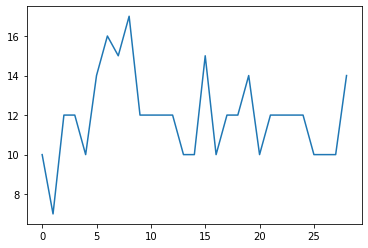

29


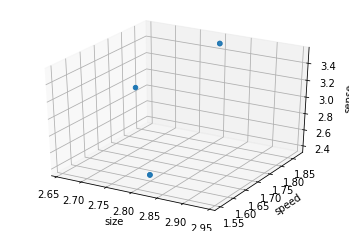

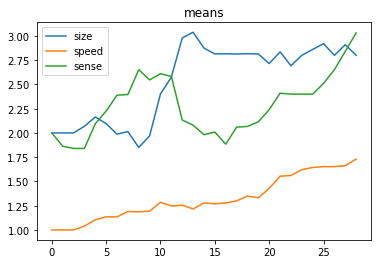

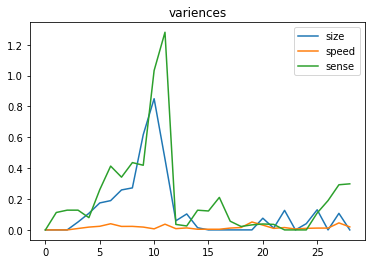

In [381]:
%matplotlib inline

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # for 3D plotting

fig = plt.figure()
plt.plot(np.arange(0,len(stats["population"])), stats["population"])
plt.show()

print(len(stats["attributes"]))
atts = np.array(stats["attributes"][len(stats["attributes"])-1])

si = atts[:,0] 
sp = atts[:,1]
se = atts[:,2]
fig2 = plt.figure()
ax = fig2.gca(projection='3d')
ax.scatter(xs=si,ys=sp,zs=se)
ax.set_xlabel("size")
ax.set_ylabel("speed")
ax.set_zlabel("sense")
plt.show()

#print([atts.shape for atts in stats["attributes"]])
means = np.array([[np.mean(np.array(atts)[:,0]), np.mean(np.array(atts)[:,1]), np.mean(np.array(atts)[:,2])] if len(atts) > 1 else atts[0,:] for atts in stats["attributes"]])
variances =  np.array([[np.var(np.array(atts)[:,0]),  np.var(np.array(atts)[:,1]),  np.var(np.array(atts)[:,2])] if len(atts) > 1 else [0, 0, 0] for atts in stats["attributes"]])

fig = plt.figure()
plt.plot(np.arange(0,len(means)), means[:,0])
plt.plot(np.arange(0,len(means)), means[:,1])
plt.plot(np.arange(0,len(means)), means[:,2])
plt.legend(["size", "speed", "sense"])
plt.title("means")
plt.show()

fig = plt.figure()
plt.plot(np.arange(0,len(variances)), variances[:,0])
plt.plot(np.arange(0,len(variances)), variances[:,1])
plt.plot(np.arange(0,len(variances)), variances[:,2])
plt.legend(["size", "speed", "sense"])
plt.title("variences")
plt.show()